In [53]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import optuna
data = scipy.io.loadmat('data/assignmentImageDenoising_phantom.mat')

print("Keys in the loaded data:")
print(list(data.keys()))

Keys in the loaded data:
['__header__', '__version__', '__globals__', 'imageNoiseless', 'imageNoisy']


In [54]:

image_noiseless = data['imageNoiseless']
image_noisy = data['imageNoisy']


print(f"Noiseless image shape: {image_noiseless.shape}")
print(f"Noisy image shape: {image_noisy.shape}")
print(f"Image data type: {image_noiseless.dtype}")
print(f"Noiseless image range: [{np.min(image_noiseless):.3f}, {np.max(image_noiseless):.3f}]")
print(f"Noisy image range: [{np.min(image_noisy):.3f}, {np.max(image_noisy):.3f}]")

Noiseless image shape: (256, 256)
Noisy image shape: (256, 256)
Image data type: float64
Noiseless image range: [0.000, 1.000]
Noisy image range: [0.000, 1.198]


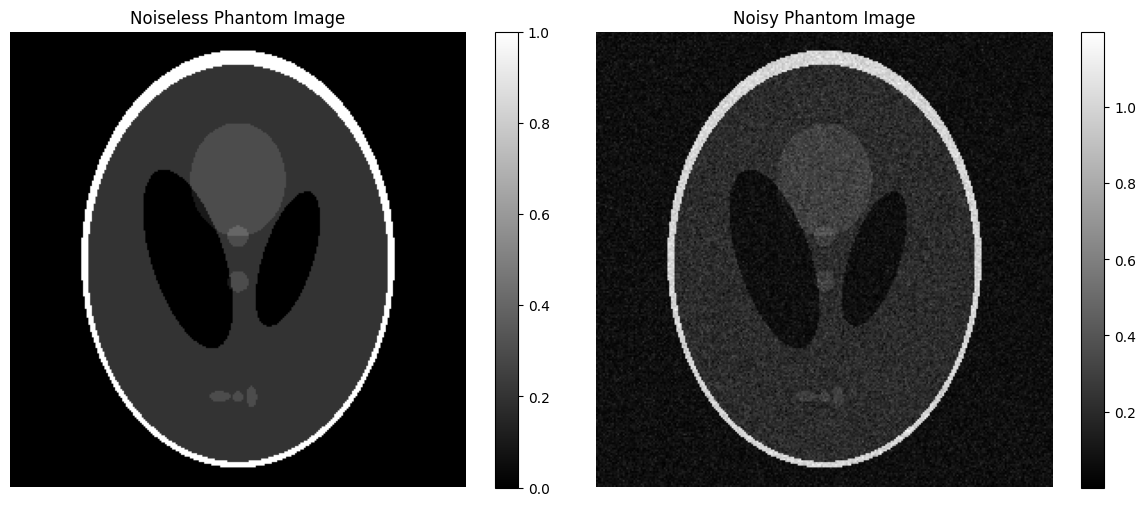

In [55]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Noiseless Phantom Image')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title('Noisy Phantom Image')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

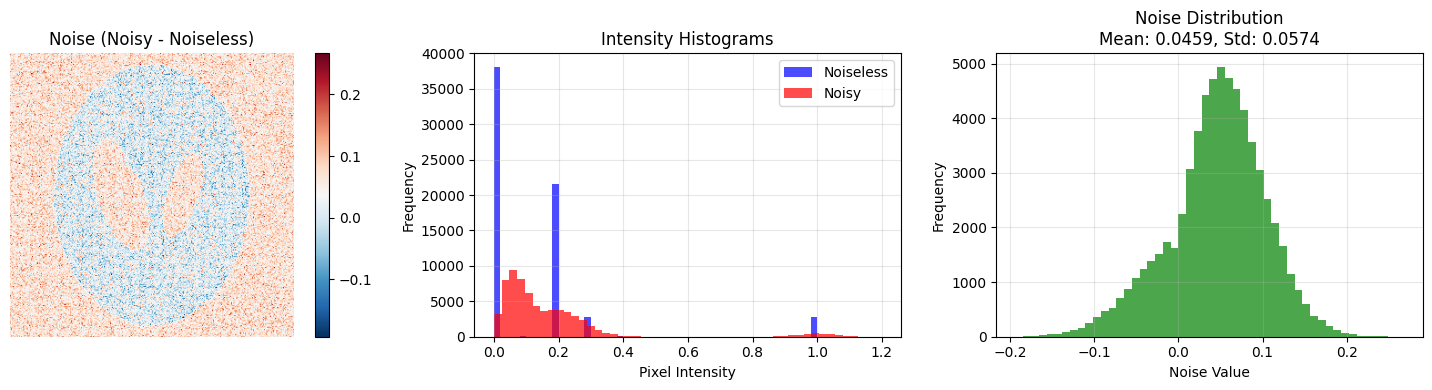

Summary Statistics:
Image size: (256, 256)
Noise standard deviation: 0.0574
Noise mean: 0.0459
Signal-to-Noise ratio (SNR): 11.40 dB


In [56]:
noise = image_noisy - image_noiseless
noise_std = np.std(noise)
noise_mean = np.mean(noise)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(noise, cmap='RdBu_r')
plt.title('Noise (Noisy - Noiseless)')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.hist(image_noiseless.flatten(), bins=50, alpha=0.7, label='Noiseless', color='blue')
plt.hist(image_noisy.flatten(), bins=50, alpha=0.7, label='Noisy', color='red')
plt.title('Intensity Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(noise.flatten(), bins=50, alpha=0.7, color='green')
plt.title(f'Noise Distribution\nMean: {noise_mean:.4f}, Std: {noise_std:.4f}')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Summary Statistics:")
print(f"Image size: {image_noiseless.shape}")
print(f"Noise standard deviation: {noise_std:.4f}")
print(f"Noise mean: {noise_mean:.4f}")
print(f"Signal-to-Noise ratio (SNR): {20 * np.log10(np.std(image_noiseless) / noise_std):.2f} dB")

# Bayesian Denoising with MRF Priors


In [ ]:
import numpy as np
from scipy.ndimage import shift
import time

def circshift(image, shift_vector):
    shifted = np.roll(image, shift_vector[0], axis=0)
    shifted = np.roll(shifted, shift_vector[1], axis=1)
    return shifted

def compute_rrmse(A, B):
    # RRMSE(A,B) = sqrt(sum((A-B)^2) / sum(A^2))
    numerator = np.sum((A - B) ** 2)
    denominator = np.sum(A ** 2)
    return np.sqrt(numerator / denominator)

def quadratic_prior(u):   
    # Quadratic potential function: g1(u) = |u|^2
    return u ** 2

def quadratic_prior_gradient(u):
   
    # Gradient of quadratic potential function: g1'(u) = 2u
  
    return 2 * u

def huber_prior(u, gamma):
    """
    Discontinuity-adaptive Huber potential function:
    g2(u) = 0.5|u|^2 if |u| <= gamma
    g2(u) = gamma|u| - 0.5*gamma^2 if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma, 
                    0.5 * u ** 2,
                    gamma * abs_u - 0.5 * gamma ** 2)

def huber_prior_gradient(u, gamma):
    """
    Gradient of Huber potential function:
    g2'(u) = u if |u| <= gamma
    g2'(u) = gamma*sign(u) if |u| > gamma
    """
    abs_u = np.abs(u)
    return np.where(abs_u <= gamma,
                    u,
                    gamma * np.sign(u))

def discontinuity_preserving_prior(u, gamma):
    """
    Discontinuity-preserving potential function:
    g3(u) = gamma * |u| - gamma**2 * log(1 + |u|/gamma)
    """
    abs_u = np.abs(u)
    return gamma * abs_u - gamma**2 * np.log(1 + abs_u / gamma)

def discontinuity_preserving_prior_gradient(u, gamma):
    """
    Gradient of discontinuity-preserving potential function:
    g3'(u) = u / (1 + |u|/gamma)
    """
    return u / (1 + np.abs(u) / gamma)

print("Prior functions and utility functions defined successfully!")

Prior functions and utility functions defined successfully!


In [ ]:
def compute_neighbor_differences(x):
  
    left_neighbor = circshift(x, [0, -1]) 
    right_neighbor = circshift(x, [0, 1])  
    up_neighbor = circshift(x, [-1, 0])   
    down_neighbor = circshift(x, [1, 0])
    diff_left = x - left_neighbor
    diff_right = x - right_neighbor
    diff_up = x - up_neighbor
    diff_down = x - down_neighbor
    
    return [diff_left, diff_right, diff_up, diff_down]

def compute_mrf_energy(x, prior_func, gamma=None):

    # Compute MRF prior energy for an image
 
    differences = compute_neighbor_differences(x)
    energy = 0
    
    for diff in differences:
        if gamma is not None:
            energy += np.sum(prior_func(diff, gamma))
        else:
            energy += np.sum(prior_func(diff))
    
    return energy

def compute_mrf_gradient(x, prior_gradient_func, gamma=None):

    # Compute gradient of MRF prior energy
  
    differences = compute_neighbor_differences(x)
    gradient = np.zeros_like(x)
    for i, diff in enumerate(differences):
        if gamma is not None:
            grad_diff = prior_gradient_func(diff, gamma)
        else:
            grad_diff = prior_gradient_func(diff)
        gradient += grad_diff
        
        if i == 0:  
            gradient -= circshift(grad_diff, [0, 1])
        elif i == 1:  
            gradient -= circshift(grad_diff, [0, -1])
        elif i == 2:  
            gradient -= circshift(grad_diff, [1, 0])
        elif i == 3:  
            gradient -= circshift(grad_diff, [-1, 0])
    
    return gradient

print("MRF energy and gradient functions defined successfully!")

MRF energy and gradient functions defined successfully!


In [ ]:
def bayesian_denoising(noisy_image, alpha, prior_type='quadratic', gamma=1.0, 
                      max_iterations=100, tolerance=1e-6, sigma=1.0):
    
    x = noisy_image.copy()
    objective_values = []
    
    if prior_type == 'quadratic':
        prior_func = quadratic_prior
        prior_grad_func = quadratic_prior_gradient
        use_gamma = False
    elif prior_type == 'huber':
        prior_func = huber_prior
        prior_grad_func = huber_prior_gradient
        use_gamma = True
    elif prior_type == 'discontinuity_preserving':
        prior_func = discontinuity_preserving_prior
        prior_grad_func = discontinuity_preserving_prior_gradient
        use_gamma = True
    else:
        raise ValueError("prior_type must be 'quadratic', 'huber', or 'discontinuity_preserving'")
    
    step_size = 0.1
    temperature = 1.0
    cooling_rate = 0.975

    for iteration in range(max_iterations):
        likelihood_gradient = (1 / sigma**2) * (noisy_image - x)
        
        if use_gamma:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func, gamma)
        else:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func)
        total_gradient = (1 - alpha) * likelihood_gradient - alpha * prior_gradient
        
        likelihood_energy = -0.5 / (sigma**2) * np.sum((x - noisy_image)**2)
        if use_gamma:
            prior_energy = -compute_mrf_energy(x, prior_func, gamma)
        else:
            prior_energy = -compute_mrf_energy(x, prior_func)
        
        current_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy
        objective_values.append(current_objective)
        
        x_new, new_objective, accepted = simulated_annealing_step(x,total_gradient,current_objective,noisy_image,alpha,prior_func,gamma if use_gamma else None,sigma,step_size,temperature)
        x = x_new
        temperature *= cooling_rate
        if iteration > 0:
            if objective_values[-1] - objective_values[-2] < tolerance:
                print(f"Converged after {iteration + 1} iterations")
                break
            if objective_values[-1] < objective_values[-2]:
                print(f"Warning: Objective decreased at iteration {iteration + 1}")
        
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: Objective = {current_objective:.6f}, Step size = {step_size:.6f}")
    
    return x, objective_values

def simulated_annealing_step(x,gradient,current_obj,noisy_image,alpha,prior_func,gamma,sigma,step,temperature):
 
   #  One simulated annealing update step

    x_trial = x + step * gradient

    likelihood_energy = -0.5 / (sigma**2) * np.sum((x_trial - noisy_image)**2)

    if gamma is not None:
        prior_energy = -compute_mrf_energy(x_trial, prior_func, gamma)
    else:
        prior_energy = -compute_mrf_energy(x_trial, prior_func)

    trial_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy

    delta_obj = trial_objective - current_obj

    if delta_obj >= 0:
        accept = True
    else:
        accept_prob = np.exp(delta_obj / temperature)
        accept = np.random.rand() < accept_prob
    if accept:
        return x_trial, trial_objective, True
    else:
        return x, current_obj, False

print("Bayesian denoising algorithm implemented successfully!")

Bayesian denoising algorithm implemented successfully!


## Testing the Denoising Algorithm

Now let's test our Bayesian denoising algorithm with different MRF priors and find optimal parameters.

In [60]:
def objective_quadratic(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='quadratic',
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_quad = optuna.create_study(direction="minimize")
study_quad.optimize(objective_quadratic, n_trials=50)

best_alpha_quad = study_quad.best_params["alpha"]
best_rrmse_quad = study_quad.best_value

print(f"Best alpha (Quadratic): {best_alpha_quad}")
print(f"Best RRMSE (Quadratic): {best_rrmse_quad:.6f}")


[I 2026-02-06 21:36:55,339] A new study created in memory with name: no-name-51a3573a-b5fd-49c7-bbed-56b9015b3788


Iteration 10: Objective = -254.153983, Step size = 0.100000
Iteration 20: Objective = -241.527143, Step size = 0.100000
Iteration 30: Objective = -240.064008, Step size = 0.100000
Iteration 40: Objective = -239.817032, Step size = 0.100000
Iteration 50: Objective = -239.767248, Step size = 0.100000
Iteration 60: Objective = -239.756075, Step size = 0.100000
Iteration 70: Objective = -239.753377, Step size = 0.100000
Iteration 80: Objective = -239.752691, Step size = 0.100000
Iteration 90: Objective = -239.752509, Step size = 0.100000


[I 2026-02-06 21:36:55,772] Trial 0 finished with value: 0.44699897902040137 and parameters: {'alpha': 0.49058423812994606}. Best is trial 0 with value: 0.44699897902040137.


Iteration 100: Objective = -239.752460, Step size = 0.100000
Iteration 10: Objective = -19.046359, Step size = 0.100000
Iteration 20: Objective = -18.876502, Step size = 0.100000
Iteration 30: Objective = -18.860150, Step size = 0.100000
Iteration 40: Objective = -18.858562, Step size = 0.100000
Iteration 50: Objective = -18.858406, Step size = 0.100000


[I 2026-02-06 21:36:56,005] Trial 1 finished with value: 0.29054623652687206 and parameters: {'alpha': 0.005626881913605705}. Best is trial 1 with value: 0.29054623652687206.


Converged after 57 iterations
Iteration 10: Objective = -136.423242, Step size = 0.100000
Iteration 20: Objective = -134.040765, Step size = 0.100000
Iteration 30: Objective = -133.930600, Step size = 0.100000
Iteration 40: Objective = -133.922185, Step size = 0.100000


[I 2026-02-06 21:36:56,283] Trial 2 finished with value: 0.2919570916391191 and parameters: {'alpha': 0.0689260223538607}. Best is trial 1 with value: 0.29054623652687206.


Iteration 50: Objective = -133.921416, Step size = 0.100000
Iteration 60: Objective = -133.921339, Step size = 0.100000
Converged after 64 iterations
Iteration 10: Objective = -0.567298, Step size = 0.100000
Iteration 20: Objective = -0.567123, Step size = 0.100000
Converged after 29 iterations


[I 2026-02-06 21:36:56,418] Trial 3 finished with value: 0.2983119850193799 and parameters: {'alpha': 0.00015668311636138626}. Best is trial 1 with value: 0.29054623652687206.


Iteration 10: Objective = -8.314887, Step size = 0.100000
Iteration 20: Objective = -8.279509, Step size = 0.100000
Iteration 30: Objective = -8.275621, Step size = 0.100000
Iteration 40: Objective = -8.275194, Step size = 0.100000
Iteration 50: Objective = -8.275147, Step size = 0.100000


[I 2026-02-06 21:36:56,655] Trial 4 finished with value: 0.2947398885335198 and parameters: {'alpha': 0.0023610015735770666}. Best is trial 1 with value: 0.29054623652687206.


Converged after 52 iterations
Iteration 10: Objective = -243.418406, Step size = 0.100000
Iteration 20: Objective = -237.696141, Step size = 0.100000
Iteration 30: Objective = -237.255187, Step size = 0.100000
Iteration 40: Objective = -237.206755, Step size = 0.100000


[I 2026-02-06 21:36:56,978] Trial 5 finished with value: 0.36845111602910174 and parameters: {'alpha': 0.2624504799369858}. Best is trial 1 with value: 0.29054623652687206.


Iteration 50: Objective = -237.200507, Step size = 0.100000
Iteration 60: Objective = -237.199621, Step size = 0.100000
Iteration 70: Objective = -237.199487, Step size = 0.100000
Converged after 79 iterations
Iteration 10: Objective = -3.230119, Step size = 0.100000
Iteration 20: Objective = -3.224562, Step size = 0.100000


[I 2026-02-06 21:36:57,201] Trial 6 finished with value: 0.2970305536936709 and parameters: {'alpha': 0.0009005888977485711}. Best is trial 1 with value: 0.29054623652687206.


Iteration 30: Objective = -3.223912, Step size = 0.100000
Iteration 40: Objective = -3.223836, Step size = 0.100000
Converged after 45 iterations
Iteration 10: Objective = -0.754408, Step size = 0.100000


[I 2026-02-06 21:36:57,383] Trial 7 finished with value: 0.29822104828599 and parameters: {'alpha': 0.00020849892148833046}. Best is trial 1 with value: 0.29054623652687206.


Iteration 20: Objective = -0.754099, Step size = 0.100000
Iteration 30: Objective = -0.754062, Step size = 0.100000
Converged after 31 iterations
Iteration 10: Objective = -0.506699, Step size = 0.100000


[I 2026-02-06 21:36:57,517] Trial 8 finished with value: 0.2983417217716445 and parameters: {'alpha': 0.00013991623659083996}. Best is trial 1 with value: 0.29054623652687206.


Iteration 20: Objective = -0.506559, Step size = 0.100000
Converged after 28 iterations
Iteration 10: Objective = -223.427888, Step size = 0.100000
Iteration 20: Objective = -219.114139, Step size = 0.100000
Iteration 30: Objective = -218.816961, Step size = 0.100000
Iteration 40: Objective = -218.787913, Step size = 0.100000
Iteration 50: Objective = -218.784595, Step size = 0.100000


[I 2026-02-06 21:36:57,856] Trial 9 finished with value: 0.34402442121097593 and parameters: {'alpha': 0.19689606830122808}. Best is trial 1 with value: 0.29054623652687206.


Iteration 60: Objective = -218.784179, Step size = 0.100000
Iteration 70: Objective = -218.784124, Step size = 0.100000
Converged after 74 iterations
Iteration 10: Objective = -62.092194, Step size = 0.100000
Iteration 20: Objective = -60.906063, Step size = 0.100000
Iteration 30: Objective = -60.837073, Step size = 0.100000


[I 2026-02-06 21:36:58,120] Trial 10 finished with value: 0.281634534088683 and parameters: {'alpha': 0.02184671917641088}. Best is trial 10 with value: 0.281634534088683.


Iteration 40: Objective = -60.832408, Step size = 0.100000
Iteration 50: Objective = -60.832048, Step size = 0.100000
Converged after 60 iterations
Iteration 10: Objective = -52.676766, Step size = 0.100000
Iteration 20: Objective = -51.732573, Step size = 0.100000
Iteration 30: Objective = -51.671858, Step size = 0.100000
Iteration 40: Objective = -51.667540, Step size = 0.100000
Iteration 50: Objective = -51.667202, Step size = 0.100000


[I 2026-02-06 21:36:58,405] Trial 11 finished with value: 0.2825708357323136 and parameters: {'alpha': 0.01779949697586236}. Best is trial 10 with value: 0.281634534088683.


Converged after 59 iterations
Iteration 10: Objective = -82.816110, Step size = 0.100000
Iteration 20: Objective = -81.152118, Step size = 0.100000
Iteration 30: Objective = -81.071079, Step size = 0.100000
Iteration 40: Objective = -81.065805, Step size = 0.100000
Iteration 50: Objective = -81.065385, Step size = 0.100000


[I 2026-02-06 21:36:58,655] Trial 12 finished with value: 0.28143219769802535 and parameters: {'alpha': 0.03199054133638613}. Best is trial 12 with value: 0.28143219769802535.


Iteration 60: Objective = -81.065347, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -77.432017, Step size = 0.100000
Iteration 20: Objective = -75.881939, Step size = 0.100000
Iteration 30: Objective = -75.803439, Step size = 0.100000
Iteration 40: Objective = -75.798328, Step size = 0.100000
Iteration 50: Objective = -75.797926, Step size = 0.100000


[I 2026-02-06 21:36:58,879] Trial 13 finished with value: 0.2812443682165798 and parameters: {'alpha': 0.02917699022315339}. Best is trial 13 with value: 0.2812443682165798.


Converged after 60 iterations
Iteration 10: Objective = -125.097990, Step size = 0.100000
Iteration 20: Objective = -122.822756, Step size = 0.100000
Iteration 30: Objective = -122.721300, Step size = 0.100000
Iteration 40: Objective = -122.713844, Step size = 0.100000


[I 2026-02-06 21:36:59,213] Trial 14 finished with value: 0.28846522735833174 and parameters: {'alpha': 0.05953087099244051}. Best is trial 13 with value: 0.2812443682165798.


Iteration 50: Objective = -122.713177, Step size = 0.100000
Iteration 60: Objective = -122.713111, Step size = 0.100000
Converged after 63 iterations
Iteration 10: Objective = -144.153630, Step size = 0.100000
Iteration 20: Objective = -141.698620, Step size = 0.100000


[I 2026-02-06 21:36:59,526] Trial 15 finished with value: 0.29472012993780183 and parameters: {'alpha': 0.0759472549232192}. Best is trial 13 with value: 0.2812443682165798.


Iteration 30: Objective = -141.581231, Step size = 0.100000
Iteration 40: Objective = -141.572051, Step size = 0.100000
Iteration 50: Objective = -141.571201, Step size = 0.100000
Iteration 60: Objective = -141.571115, Step size = 0.100000
Converged after 65 iterations
Iteration 10: Objective = -21.347238, Step size = 0.100000
Iteration 20: Objective = -21.138053, Step size = 0.100000
Iteration 30: Objective = -21.118480, Step size = 0.100000
Iteration 40: Objective = -21.116627, Step size = 0.100000
Iteration 50: Objective = -21.116450, Step size = 0.100000


[I 2026-02-06 21:36:59,837] Trial 16 finished with value: 0.2897569985456352 and parameters: {'alpha': 0.006361718116553824}. Best is trial 13 with value: 0.2812443682165798.


Converged after 57 iterations
Iteration 10: Objective = -77.315750, Step size = 0.100000
Iteration 20: Objective = -75.768221, Step size = 0.100000
Iteration 30: Objective = -75.689779, Step size = 0.100000
Iteration 40: Objective = -75.684672, Step size = 0.100000


[I 2026-02-06 21:37:00,139] Trial 17 finished with value: 0.2812421578506468 and parameters: {'alpha': 0.029117686782946454}. Best is trial 17 with value: 0.2812421578506468.


Iteration 50: Objective = -75.684270, Step size = 0.100000
Converged after 60 iterations
Iteration 10: Objective = -4.630217, Step size = 0.100000
Iteration 20: Objective = -4.618922, Step size = 0.100000
Iteration 30: Objective = -4.617624, Step size = 0.100000


[I 2026-02-06 21:37:00,382] Trial 18 finished with value: 0.2963795322282841 and parameters: {'alpha': 0.0012974159408498016}. Best is trial 17 with value: 0.2812421578506468.


Iteration 40: Objective = -4.617475, Step size = 0.100000
Converged after 48 iterations
Iteration 10: Objective = -27.089992, Step size = 0.100000
Iteration 20: Objective = -26.769790, Step size = 0.100000
Iteration 30: Objective = -26.741882, Step size = 0.100000


[I 2026-02-06 21:37:00,655] Trial 19 finished with value: 0.2879485163362556 and parameters: {'alpha': 0.008252829801986064}. Best is trial 17 with value: 0.2812421578506468.


Iteration 40: Objective = -26.739399, Step size = 0.100000
Iteration 50: Objective = -26.739174, Step size = 0.100000
Converged after 58 iterations
Iteration 10: Objective = -196.132771, Step size = 0.100000
Iteration 20: Objective = -192.837866, Step size = 0.100000
Iteration 30: Objective = -192.635132, Step size = 0.100000
Iteration 40: Objective = -192.617111, Step size = 0.100000
Iteration 50: Objective = -192.615247, Step size = 0.100000
Iteration 60: Objective = -192.615036, Step size = 0.100000


[I 2026-02-06 21:37:01,029] Trial 20 finished with value: 0.321772635132852 and parameters: {'alpha': 0.14103209201293843}. Best is trial 17 with value: 0.2812421578506468.


Converged after 70 iterations
Iteration 10: Objective = -85.338769, Step size = 0.100000
Iteration 20: Objective = -83.624302, Step size = 0.100000
Iteration 30: Objective = -83.542157, Step size = 0.100000
Iteration 40: Objective = -83.536803, Step size = 0.100000
Iteration 50: Objective = -83.536373, Step size = 0.100000


[I 2026-02-06 21:37:01,714] Trial 21 finished with value: 0.28157674009346184 and parameters: {'alpha': 0.03335545157502073}. Best is trial 17 with value: 0.2812421578506468.
[I 2026-02-06 21:37:01,752] Trial 22 finished with value: 0.43707871914005103 and parameters: {'alpha': 0.8361918549434362}. Best is trial 17 with value: 0.2812421578506468.


Iteration 60: Objective = -83.536334, Step size = 0.100000
Converged after 61 iterations
Converged after 3 iterations
Iteration 10: Objective = -50.401905, Step size = 0.100000
Iteration 20: Objective = -49.516849, Step size = 0.100000
Iteration 30: Objective = -49.458465, Step size = 0.100000


[I 2026-02-06 21:37:02,278] Trial 23 finished with value: 0.28287883849718576 and parameters: {'alpha': 0.016868413708943847}. Best is trial 17 with value: 0.2812421578506468.


Iteration 40: Objective = -49.454249, Step size = 0.100000
Iteration 50: Objective = -49.453917, Step size = 0.100000
Converged after 59 iterations
Iteration 10: Objective = -100.073634, Step size = 0.100000


[I 2026-02-06 21:37:02,587] Trial 24 finished with value: 0.2831321840284845 and parameters: {'alpha': 0.0419718131899338}. Best is trial 17 with value: 0.2812421578506468.


Iteration 20: Objective = -98.102835, Step size = 0.100000
Iteration 30: Objective = -98.014597, Step size = 0.100000
Iteration 40: Objective = -98.008665, Step size = 0.100000
Iteration 50: Objective = -98.008167, Step size = 0.100000
Iteration 60: Objective = -98.008121, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -13.972570, Step size = 0.100000
Iteration 20: Objective = -13.877165, Step size = 0.100000
Iteration 30: Objective = -13.867387, Step size = 0.100000
Iteration 40: Objective = -13.866380, Step size = 0.100000


[I 2026-02-06 21:37:02,930] Trial 25 finished with value: 0.29242316818033964 and parameters: {'alpha': 0.0040505230527180195}. Best is trial 17 with value: 0.2812421578506468.


Iteration 50: Objective = -13.866276, Step size = 0.100000
Converged after 55 iterations
Iteration 10: Objective = -172.280944, Step size = 0.100000
Iteration 20: Objective = -169.485841, Step size = 0.100000
Iteration 30: Objective = -169.331680, Step size = 0.100000


[I 2026-02-06 21:37:03,204] Trial 26 finished with value: 0.3074109263254597 and parameters: {'alpha': 0.10657906270259128}. Best is trial 17 with value: 0.2812421578506468.


Iteration 40: Objective = -169.318755, Step size = 0.100000
Iteration 50: Objective = -169.317494, Step size = 0.100000
Iteration 60: Objective = -169.317360, Step size = 0.100000
Converged after 67 iterations
Iteration 10: Objective = -33.317602, Step size = 0.100000
Iteration 20: Objective = -32.860140, Step size = 0.100000


[I 2026-02-06 21:37:03,503] Trial 27 finished with value: 0.28624362680506327 and parameters: {'alpha': 0.010400544707506839}. Best is trial 17 with value: 0.2812421578506468.


Iteration 30: Objective = -32.823202, Step size = 0.100000
Iteration 40: Objective = -32.820119, Step size = 0.100000
Iteration 50: Objective = -32.819853, Step size = 0.100000
Converged after 59 iterations
Iteration 10: Objective = -82.805263, Step size = 0.100000
Iteration 20: Objective = -81.141492, Step size = 0.100000
Iteration 30: Objective = -81.060458, Step size = 0.100000
Iteration 40: Objective = -81.055185, Step size = 0.100000
Iteration 50: Objective = -81.054765, Step size = 0.100000


[I 2026-02-06 21:37:03,782] Trial 28 finished with value: 0.2814316540663072 and parameters: {'alpha': 0.03198473811105933}. Best is trial 17 with value: 0.2812421578506468.


Iteration 60: Objective = -81.054727, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -258.361793, Step size = 0.100000
Iteration 20: Objective = -248.598340, Step size = 0.100000
Iteration 30: Objective = -247.621196, Step size = 0.100000
Iteration 40: Objective = -247.479822, Step size = 0.100000
Iteration 50: Objective = -247.455532, Step size = 0.100000
Iteration 60: Objective = -247.450903, Step size = 0.100000
Iteration 70: Objective = -247.449956, Step size = 0.100000
Iteration 80: Objective = -247.449752, Step size = 0.100000


[I 2026-02-06 21:37:04,262] Trial 29 finished with value: 0.4197681611396362 and parameters: {'alpha': 0.4104632907878224}. Best is trial 17 with value: 0.2812421578506468.


Iteration 90: Objective = -247.449706, Step size = 0.100000
Converged after 96 iterations
Iteration 10: Objective = -8.910274, Step size = 0.100000
Iteration 20: Objective = -8.869842, Step size = 0.100000
Iteration 30: Objective = -8.865431, Step size = 0.100000


[I 2026-02-06 21:37:04,498] Trial 30 finished with value: 0.29448402628861536 and parameters: {'alpha': 0.002535532232660803}. Best is trial 17 with value: 0.2812421578506468.


Iteration 40: Objective = -8.864949, Step size = 0.100000
Iteration 50: Objective = -8.864897, Step size = 0.100000
Converged after 53 iterations
Iteration 10: Objective = -80.427669, Step size = 0.100000
Iteration 20: Objective = -78.813192, Step size = 0.100000


[I 2026-02-06 21:37:04,817] Trial 31 finished with value: 0.28132864590515344 and parameters: {'alpha': 0.03072597176910691}. Best is trial 17 with value: 0.2812421578506468.


Iteration 30: Objective = -78.733244, Step size = 0.100000
Iteration 40: Objective = -78.728045, Step size = 0.100000
Iteration 50: Objective = -78.727633, Step size = 0.100000
Iteration 60: Objective = -78.727596, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -48.754829, Step size = 0.100000


[I 2026-02-06 21:37:05,068] Trial 32 finished with value: 0.2831219943538407 and parameters: {'alpha': 0.016205101632635745}. Best is trial 17 with value: 0.2812421578506468.


Iteration 20: Objective = -47.912548, Step size = 0.100000
Iteration 30: Objective = -47.855934, Step size = 0.100000
Iteration 40: Objective = -47.851799, Step size = 0.100000
Iteration 50: Objective = -47.851471, Step size = 0.100000
Converged after 59 iterations
Iteration 10: Objective = -97.254356, Step size = 0.100000
Iteration 20: Objective = -95.327547, Step size = 0.100000
Iteration 30: Objective = -95.240483, Step size = 0.100000
Iteration 40: Objective = -95.234678, Step size = 0.100000
Iteration 50: Objective = -95.234194, Step size = 0.100000


[I 2026-02-06 21:37:05,337] Trial 33 finished with value: 0.2827419287734779 and parameters: {'alpha': 0.04023380149186843}. Best is trial 17 with value: 0.2812421578506468.


Iteration 60: Objective = -95.234149, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -32.984380, Step size = 0.100000
Iteration 20: Objective = -32.534626, Step size = 0.100000
Iteration 30: Objective = -32.498162, Step size = 0.100000


[I 2026-02-06 21:37:05,638] Trial 34 finished with value: 0.28632818860427456 and parameters: {'alpha': 0.010282963067674877}. Best is trial 17 with value: 0.2812421578506468.


Iteration 40: Objective = -32.495109, Step size = 0.100000
Iteration 50: Objective = -32.494845, Step size = 0.100000
Converged after 59 iterations
Iteration 10: Objective = -150.067697, Step size = 0.100000
Iteration 20: Objective = -147.554091, Step size = 0.100000


[I 2026-02-06 21:37:05,930] Trial 35 finished with value: 0.297040998251189 and parameters: {'alpha': 0.08168635068880975}. Best is trial 17 with value: 0.2812421578506468.


Iteration 30: Objective = -147.430404, Step size = 0.100000
Iteration 40: Objective = -147.420572, Step size = 0.100000
Iteration 50: Objective = -147.419652, Step size = 0.100000
Iteration 60: Objective = -147.419558, Step size = 0.100000
Converged after 65 iterations
Iteration 10: Objective = -74.731820, Step size = 0.100000


[I 2026-02-06 21:37:06,174] Trial 36 finished with value: 0.2812131713227168 and parameters: {'alpha': 0.0278151493496485}. Best is trial 36 with value: 0.2812131713227168.


Iteration 20: Objective = -73.241880, Step size = 0.100000
Iteration 30: Objective = -73.164776, Step size = 0.100000
Iteration 40: Objective = -73.159742, Step size = 0.100000
Iteration 50: Objective = -73.159349, Step size = 0.100000
Converged after 60 iterations


[I 2026-02-06 21:37:06,405] Trial 37 finished with value: 0.29193313767205675 and parameters: {'alpha': 0.004441246958156999}. Best is trial 36 with value: 0.2812131713227168.


Iteration 10: Objective = -15.248150, Step size = 0.100000
Iteration 20: Objective = -15.135730, Step size = 0.100000
Iteration 30: Objective = -15.124388, Step size = 0.100000
Iteration 40: Objective = -15.123237, Step size = 0.100000
Iteration 50: Objective = -15.123120, Step size = 0.100000
Converged after 56 iterations
Iteration 10: Objective = -207.516344, Step size = 0.100000
Iteration 20: Objective = -203.871935, Step size = 0.100000
Iteration 30: Objective = -203.637019, Step size = 0.100000
Iteration 40: Objective = -203.615409, Step size = 0.100000
Iteration 50: Objective = -203.613092, Step size = 0.100000


[I 2026-02-06 21:37:06,720] Trial 38 finished with value: 0.3301004254719732 and parameters: {'alpha': 0.1615188777318867}. Best is trial 36 with value: 0.2812131713227168.


Iteration 60: Objective = -203.612820, Step size = 0.100000
Iteration 70: Objective = -203.612787, Step size = 0.100000
Converged after 71 iterations
Iteration 10: Objective = -250.800389, Step size = 0.100000
Iteration 20: Objective = -244.144083, Step size = 0.100000
Iteration 30: Objective = -243.595606, Step size = 0.100000
Iteration 40: Objective = -243.530937, Step size = 0.100000
Iteration 50: Objective = -243.521956, Step size = 0.100000
Iteration 60: Objective = -243.520580, Step size = 0.100000
Iteration 70: Objective = -243.520355, Step size = 0.100000
Iteration 80: Objective = -243.520317, Step size = 0.100000


[I 2026-02-06 21:37:07,148] Trial 39 finished with value: 0.3822867336889549 and parameters: {'alpha': 0.30130755125387587}. Best is trial 36 with value: 0.2812131713227168.


Converged after 83 iterations
Iteration 10: Objective = -120.635666, Step size = 0.100000
Iteration 20: Objective = -118.405795, Step size = 0.100000
Iteration 30: Objective = -118.307224, Step size = 0.100000


[I 2026-02-06 21:37:07,538] Trial 40 finished with value: 0.28727222563993005 and parameters: {'alpha': 0.0560952035101558}. Best is trial 36 with value: 0.2812131713227168.


Iteration 40: Objective = -118.300097, Step size = 0.100000
Iteration 50: Objective = -118.299466, Step size = 0.100000
Iteration 60: Objective = -118.299404, Step size = 0.100000
Converged after 63 iterations
Iteration 10: Objective = -60.427502, Step size = 0.100000
Iteration 20: Objective = -59.283523, Step size = 0.100000
Iteration 30: Objective = -59.215842, Step size = 0.100000
Iteration 40: Objective = -59.211231, Step size = 0.100000


[I 2026-02-06 21:37:07,960] Trial 41 finished with value: 0.28176084014298713 and parameters: {'alpha': 0.021107632248336946}. Best is trial 36 with value: 0.2812131713227168.


Iteration 50: Objective = -59.210875, Step size = 0.100000
Converged after 60 iterations
Iteration 10: Objective = -37.620750, Step size = 0.100000
Iteration 20: Objective = -37.060770, Step size = 0.100000
Iteration 30: Objective = -37.017854, Step size = 0.100000
Iteration 40: Objective = -37.014417, Step size = 0.100000


[I 2026-02-06 21:37:08,443] Trial 42 finished with value: 0.28521783721064176 and parameters: {'alpha': 0.01194706973718487}. Best is trial 36 with value: 0.2812131713227168.


Iteration 50: Objective = -37.014129, Step size = 0.100000
Converged after 59 iterations
Iteration 10: Objective = -87.808830, Step size = 0.100000
Iteration 20: Objective = -86.046793, Step size = 0.100000
Iteration 30: Objective = -85.963602, Step size = 0.100000
Iteration 40: Objective = -85.958163, Step size = 0.100000
Iteration 50: Objective = -85.957723, Step size = 0.100000


[I 2026-02-06 21:37:08,966] Trial 43 finished with value: 0.2817530634796549 and parameters: {'alpha': 0.034721807494907886}. Best is trial 36 with value: 0.2812131713227168.


Iteration 60: Objective = -85.957683, Step size = 0.100000
Converged after 61 iterations
Iteration 10: Objective = -70.205502, Step size = 0.100000
Iteration 20: Objective = -68.820483, Step size = 0.100000


[I 2026-02-06 21:37:09,300] Trial 44 finished with value: 0.28125588022100617 and parameters: {'alpha': 0.02560281993345496}. Best is trial 36 with value: 0.2812131713227168.


Iteration 30: Objective = -68.745954, Step size = 0.100000
Iteration 40: Objective = -68.741048, Step size = 0.100000
Iteration 50: Objective = -68.740668, Step size = 0.100000
Converged after 60 iterations
Iteration 10: Objective = -64.013013, Step size = 0.100000
Iteration 20: Objective = -62.778738, Step size = 0.100000


[I 2026-02-06 21:37:09,532] Trial 45 finished with value: 0.2815094892699788 and parameters: {'alpha': 0.022712592710739835}. Best is trial 36 with value: 0.2812131713227168.


Iteration 30: Objective = -62.708315, Step size = 0.100000
Iteration 40: Objective = -62.703590, Step size = 0.100000
Iteration 50: Objective = -62.703225, Step size = 0.100000
Converged after 60 iterations
Iteration 10: Objective = -113.379486, Step size = 0.100000


[I 2026-02-06 21:37:09,801] Trial 46 finished with value: 0.2855548190637384 and parameters: {'alpha': 0.05080386596936655}. Best is trial 36 with value: 0.2812131713227168.


Iteration 20: Objective = -111.230190, Step size = 0.100000
Iteration 30: Objective = -111.135746, Step size = 0.100000
Iteration 40: Objective = -111.129100, Step size = 0.100000
Iteration 50: Objective = -111.128521, Step size = 0.100000
Iteration 60: Objective = -111.128465, Step size = 0.100000
Converged after 63 iterations
Iteration 10: Objective = -188.737885, Step size = 0.100000
Iteration 20: Objective = -185.627210, Step size = 0.100000
Iteration 30: Objective = -185.441797, Step size = 0.100000
Iteration 40: Objective = -185.425633, Step size = 0.100000
Iteration 50: Objective = -185.423995, Step size = 0.100000
Iteration 60: Objective = -185.423814, Step size = 0.100000


[I 2026-02-06 21:37:10,082] Trial 47 finished with value: 0.3169162609371048 and parameters: {'alpha': 0.12928622572348356}. Best is trial 36 with value: 0.2812131713227168.


Converged after 69 iterations
Iteration 10: Objective = -146.741153, Step size = 0.100000
Iteration 20: Objective = -144.260989, Step size = 0.100000
Iteration 30: Objective = -144.140930, Step size = 0.100000
Iteration 40: Objective = -144.131472, Step size = 0.100000


[I 2026-02-06 21:37:10,350] Trial 48 finished with value: 0.2957133245840887 and parameters: {'alpha': 0.07841733979726198}. Best is trial 36 with value: 0.2812131713227168.


Iteration 50: Objective = -144.130592, Step size = 0.100000
Iteration 60: Objective = -144.130503, Step size = 0.100000
Converged after 65 iterations
Iteration 10: Objective = -23.475463, Step size = 0.100000
Iteration 20: Objective = -23.227150, Step size = 0.100000
Iteration 30: Objective = -23.204520, Step size = 0.100000


[I 2026-02-06 21:37:10,579] Trial 49 finished with value: 0.28905937549508703 and parameters: {'alpha': 0.007052900221395223}. Best is trial 36 with value: 0.2812131713227168.


Iteration 40: Objective = -23.202427, Step size = 0.100000
Iteration 50: Objective = -23.202231, Step size = 0.100000
Converged after 58 iterations
Best alpha (Quadratic): 0.0278151493496485
Best RRMSE (Quadratic): 0.281213


In [61]:
def objective_huber(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='huber',
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_huber = optuna.create_study(direction="minimize")
study_huber.optimize(objective_huber, n_trials=200)

best_alpha_huber = study_huber.best_params["alpha"]
best_gamma_huber = study_huber.best_params["gamma"]
best_rrmse_huber = study_huber.best_value

print(f"Best Huber params: alpha={best_alpha_huber}, gamma={best_gamma_huber}")
print(f"Best RRMSE (Huber): {best_rrmse_huber:.6f}")


[I 2026-02-06 21:37:10,600] A new study created in memory with name: no-name-2a0070e7-61d6-45da-8ec2-2341b7919d3d
[I 2026-02-06 21:37:10,648] Trial 0 finished with value: 0.29856633222477424 and parameters: {'alpha': 0.002500452425773913, 'gamma': 0.0011162975447638701}. Best is trial 0 with value: 0.29856633222477424.


Converged after 5 iterations
Iteration 10: Objective = -7.006920, Step size = 0.100000
Iteration 20: Objective = -6.968881, Step size = 0.100000
Iteration 30: Objective = -6.964479, Step size = 0.100000
Iteration 40: Objective = -6.963965, Step size = 0.100000


[I 2026-02-06 21:37:11,066] Trial 1 finished with value: 0.2922216836244334 and parameters: {'alpha': 0.012746816952708467, 'gamma': 0.0511606003036038}. Best is trial 1 with value: 0.2922216836244334.


Iteration 50: Objective = -6.963905, Step size = 0.100000
Converged after 54 iterations


[I 2026-02-06 21:37:11,085] Trial 2 finished with value: 0.29857883443056116 and parameters: {'alpha': 0.0003087365943183867, 'gamma': 0.0004904847117334325}. Best is trial 1 with value: 0.2922216836244334.


Converged after 2 iterations
Iteration 10: Objective = -2.767406, Step size = 0.100000
Iteration 20: Objective = -2.761323, Step size = 0.100000


[I 2026-02-06 21:37:11,415] Trial 3 finished with value: 0.2959587188341705 and parameters: {'alpha': 0.0030449690975196835, 'gamma': 0.13220712059086465}. Best is trial 1 with value: 0.2922216836244334.


Iteration 30: Objective = -2.760618, Step size = 0.100000
Iteration 40: Objective = -2.760536, Step size = 0.100000
Converged after 45 iterations
Iteration 10: Objective = -0.276931, Step size = 0.100000


[I 2026-02-06 21:37:11,599] Trial 4 finished with value: 0.29839959325875165 and parameters: {'alpha': 0.002612309198743002, 'gamma': 0.006804829151317504}. Best is trial 1 with value: 0.2922216836244334.


Iteration 20: Objective = -0.276889, Step size = 0.100000
Converged after 22 iterations
Iteration 10: Objective = -64.888890, Step size = 0.100000
Iteration 20: Objective = -62.107889, Step size = 0.100000
Iteration 30: Objective = -61.911423, Step size = 0.100000
Iteration 40: Objective = -61.891228, Step size = 0.100000
Iteration 50: Objective = -61.888655, Step size = 0.100000


[I 2026-02-06 21:37:12,197] Trial 5 finished with value: 0.24689271658462617 and parameters: {'alpha': 0.20429016886116605, 'gamma': 0.046443738365089395}. Best is trial 5 with value: 0.24689271658462617.


Iteration 60: Objective = -61.888283, Step size = 0.100000
Iteration 70: Objective = -61.888225, Step size = 0.100000
Converged after 75 iterations


[I 2026-02-06 21:37:12,460] Trial 6 finished with value: 0.2981000683741122 and parameters: {'alpha': 0.0005300345162329253, 'gamma': 0.20413727328886933}. Best is trial 5 with value: 0.24689271658462617.
[I 2026-02-06 21:37:12,489] Trial 7 finished with value: 0.2985717423607792 and parameters: {'alpha': 0.009001888850798017, 'gamma': 0.0002707620447597666}. Best is trial 5 with value: 0.24689271658462617.


Iteration 10: Objective = -0.579699, Step size = 0.100000
Iteration 20: Objective = -0.579472, Step size = 0.100000
Converged after 30 iterations
Converged after 3 iterations


[I 2026-02-06 21:37:12,683] Trial 8 finished with value: 0.29838460335287587 and parameters: {'alpha': 0.021932827093268832, 'gamma': 0.0008544623346410824}. Best is trial 5 with value: 0.24689271658462617.


Iteration 10: Objective = -0.306078, Step size = 0.100000
Iteration 20: Objective = -0.306028, Step size = 0.100000
Converged after 23 iterations
Iteration 10: Objective = -0.344041, Step size = 0.100000


[I 2026-02-06 21:37:12,894] Trial 9 finished with value: 0.29832118162277127 and parameters: {'alpha': 0.0010284087469404782, 'gamma': 0.024720895185119055}. Best is trial 5 with value: 0.24689271658462617.


Iteration 20: Objective = -0.343965, Step size = 0.100000
Converged after 25 iterations
Iteration 10: Objective = -41.384089, Step size = 0.100000
Iteration 20: Objective = -38.076608, Step size = 0.100000
Iteration 30: Objective = -37.263337, Step size = 0.100000
Iteration 40: Objective = -37.046812, Step size = 0.100000
Iteration 50: Objective = -36.986197, Step size = 0.100000
Iteration 60: Objective = -36.968634, Step size = 0.100000
Iteration 70: Objective = -36.963435, Step size = 0.100000


[I 2026-02-06 21:37:13,720] Trial 10 finished with value: 0.2530064919408146 and parameters: {'alpha': 0.4317787248762096, 'gamma': 0.008036043223242412}. Best is trial 5 with value: 0.24689271658462617.


Iteration 80: Objective = -36.961873, Step size = 0.100000
Iteration 90: Objective = -36.961399, Step size = 0.100000
Iteration 100: Objective = -36.961254, Step size = 0.100000
Iteration 10: Objective = -41.381582, Step size = 0.100000
Iteration 20: Objective = -36.536695, Step size = 0.100000
Iteration 30: Objective = -35.024791, Step size = 0.100000
Iteration 40: Objective = -34.519719, Step size = 0.100000
Iteration 50: Objective = -34.340827, Step size = 0.100000
Iteration 60: Objective = -34.274651, Step size = 0.100000
Iteration 70: Objective = -34.249403, Step size = 0.100000
Iteration 80: Objective = -34.239549, Step size = 0.100000
Iteration 90: Objective = -34.235648, Step size = 0.100000


[I 2026-02-06 21:37:14,477] Trial 11 finished with value: 0.24580080256544734 and parameters: {'alpha': 0.5681161963467749, 'gamma': 0.006222669497063233}. Best is trial 11 with value: 0.24580080256544734.


Iteration 100: Objective = -34.234088, Step size = 0.100000
Iteration 10: Objective = -189.820221, Step size = 0.100000
Iteration 20: Objective = -174.558790, Step size = 0.100000
Iteration 30: Objective = -172.099782, Step size = 0.100000
Iteration 40: Objective = -171.540034, Step size = 0.100000
Iteration 50: Objective = -171.390632, Step size = 0.100000
Iteration 60: Objective = -171.346766, Step size = 0.100000
Iteration 70: Objective = -171.333024, Step size = 0.100000
Iteration 80: Objective = -171.328510, Step size = 0.100000


[I 2026-02-06 21:37:15,815] Trial 12 finished with value: 0.42806862770153636 and parameters: {'alpha': 0.6066770007659329, 'gamma': 0.9426241739348422}. Best is trial 11 with value: 0.24580080256544734.


Iteration 90: Objective = -171.326973, Step size = 0.100000
Iteration 100: Objective = -171.326433, Step size = 0.100000
Iteration 10: Objective = -7.268778, Step size = 0.100000
Iteration 20: Objective = -7.230860, Step size = 0.100000
Iteration 30: Objective = -7.225136, Step size = 0.100000
Iteration 40: Objective = -7.224262, Step size = 0.100000


[I 2026-02-06 21:37:16,753] Trial 13 finished with value: 0.29287585698654695 and parameters: {'alpha': 0.10968373690557912, 'gamma': 0.004281653426305952}. Best is trial 11 with value: 0.24580080256544734.


Iteration 50: Objective = -7.224128, Step size = 0.100000
Converged after 59 iterations
Iteration 10: Objective = -4.188043, Step size = 0.100000
Iteration 20: Objective = -4.175754, Step size = 0.100000
Iteration 30: Objective = -4.173880, Step size = 0.100000
Iteration 40: Objective = -4.173593, Step size = 0.100000


[I 2026-02-06 21:37:17,521] Trial 14 finished with value: 0.29534473662050154 and parameters: {'alpha': 0.10933944517022867, 'gamma': 0.00240863048681905}. Best is trial 11 with value: 0.24580080256544734.


Iteration 50: Objective = -4.173548, Step size = 0.100000
Converged after 53 iterations
Iteration 10: Objective = -44.562630, Step size = 0.100000
Iteration 20: Objective = -42.851934, Step size = 0.100000
Iteration 30: Objective = -42.666184, Step size = 0.100000
Iteration 40: Objective = -42.642530, Step size = 0.100000
Iteration 50: Objective = -42.639237, Step size = 0.100000
Iteration 60: Objective = -42.638755, Step size = 0.100000
Iteration 70: Objective = -42.638683, Step size = 0.100000


[I 2026-02-06 21:37:18,708] Trial 15 finished with value: 0.25942205093573956 and parameters: {'alpha': 0.13597551708916095, 'gamma': 0.034438787946966226}. Best is trial 11 with value: 0.24580080256544734.


Converged after 76 iterations
Iteration 10: Objective = -1.443215, Step size = 0.100000
Iteration 20: Objective = -1.434310, Step size = 0.100000
Iteration 30: Objective = -1.428590, Step size = 0.100000
Iteration 40: Objective = -1.424910, Step size = 0.100000
Iteration 50: Objective = -1.422541, Step size = 0.100000
Iteration 60: Objective = -1.421014, Step size = 0.100000
Iteration 70: Objective = -1.420029, Step size = 0.100000
Iteration 80: Objective = -1.419393, Step size = 0.100000
Iteration 90: Objective = -1.418983, Step size = 0.100000


[I 2026-02-06 21:37:20,141] Trial 16 finished with value: 0.2945820952062566 and parameters: {'alpha': 0.7845762642444525, 'gamma': 0.00011279712522257166}. Best is trial 11 with value: 0.24580080256544734.
[I 2026-02-06 21:37:20,188] Trial 17 finished with value: 0.298574596750546 and parameters: {'alpha': 0.00010736849846976832, 'gamma': 0.020270650486828672}. Best is trial 11 with value: 0.24580080256544734.


Iteration 100: Objective = -1.418718, Step size = 0.100000
Converged after 2 iterations
Iteration 10: Objective = -106.836534, Step size = 0.100000
Iteration 20: Objective = -105.320576, Step size = 0.100000
Iteration 30: Objective = -105.150867, Step size = 0.100000
Iteration 40: Objective = -105.121654, Step size = 0.100000
Iteration 50: Objective = -105.116193, Step size = 0.100000
Iteration 60: Objective = -105.115142, Step size = 0.100000
Iteration 70: Objective = -105.114936, Step size = 0.100000


[I 2026-02-06 21:37:21,365] Trial 18 finished with value: 0.253924652667771 and parameters: {'alpha': 0.23204600617922697, 'gamma': 0.12351603727364058}. Best is trial 11 with value: 0.24580080256544734.


Iteration 80: Objective = -105.114896, Step size = 0.100000
Converged after 84 iterations
Iteration 10: Objective = -50.893347, Step size = 0.100000
Iteration 20: Objective = -49.884053, Step size = 0.100000
Iteration 30: Objective = -49.800493, Step size = 0.100000
Iteration 40: Objective = -49.792915, Step size = 0.100000
Iteration 50: Objective = -49.792167, Step size = 0.100000
Iteration 60: Objective = -49.792089, Step size = 0.100000


[I 2026-02-06 21:37:22,577] Trial 19 finished with value: 0.2823383344659898 and parameters: {'alpha': 0.03426036720533718, 'gamma': 0.7419802121093493}. Best is trial 11 with value: 0.24580080256544734.


Converged after 65 iterations
Iteration 10: Objective = -1.884079, Step size = 0.100000
Iteration 20: Objective = -1.881946, Step size = 0.100000
Iteration 30: Objective = -1.881655, Step size = 0.100000


[I 2026-02-06 21:37:23,129] Trial 20 finished with value: 0.29722051235118363 and parameters: {'alpha': 0.05453569402970678, 'gamma': 0.0021490945194852684}. Best is trial 11 with value: 0.24580080256544734.


Iteration 40: Objective = -1.881615, Step size = 0.100000
Converged after 42 iterations
Iteration 10: Objective = -51.142097, Step size = 0.100000
Iteration 20: Objective = -46.981626, Step size = 0.100000
Iteration 30: Objective = -46.224768, Step size = 0.100000
Iteration 40: Objective = -46.067584, Step size = 0.100000
Iteration 50: Objective = -46.032040, Step size = 0.100000
Iteration 60: Objective = -46.023585, Step size = 0.100000
Iteration 70: Objective = -46.021503, Step size = 0.100000
Iteration 80: Objective = -46.020978, Step size = 0.100000


[I 2026-02-06 21:37:24,710] Trial 21 finished with value: 0.24818024252493057 and parameters: {'alpha': 0.3567259479912737, 'gamma': 0.013718671672875373}. Best is trial 11 with value: 0.24580080256544734.


Iteration 90: Objective = -46.020845, Step size = 0.100000
Iteration 100: Objective = -46.020810, Step size = 0.100000
Iteration 10: Objective = -54.148728, Step size = 0.100000
Iteration 20: Objective = -49.678640, Step size = 0.100000
Iteration 30: Objective = -48.935586, Step size = 0.100000
Iteration 40: Objective = -48.791050, Step size = 0.100000
Iteration 50: Objective = -48.759885, Step size = 0.100000
Iteration 60: Objective = -48.752751, Step size = 0.100000
Iteration 70: Objective = -48.751054, Step size = 0.100000
Iteration 80: Objective = -48.750641, Step size = 0.100000


[I 2026-02-06 21:37:26,265] Trial 22 finished with value: 0.24647138295406845 and parameters: {'alpha': 0.3456770940440207, 'gamma': 0.01578726633426774}. Best is trial 11 with value: 0.24580080256544734.


Iteration 90: Objective = -48.750539, Step size = 0.100000
Iteration 100: Objective = -48.750513, Step size = 0.100000
Iteration 10: Objective = -137.198976, Step size = 0.100000
Iteration 20: Objective = -113.573580, Step size = 0.100000
Iteration 30: Objective = -93.407210, Step size = 0.100000
Iteration 40: Objective = -74.833450, Step size = 0.100000
Iteration 50: Objective = -58.304612, Step size = 0.100000
Iteration 60: Objective = -45.512967, Step size = 0.100000
Iteration 70: Objective = -36.315397, Step size = 0.100000
Iteration 80: Objective = -29.900396, Step size = 0.100000


[I 2026-02-06 21:37:27,806] Trial 23 finished with value: 0.6021542698116908 and parameters: {'alpha': 0.9858782060563119, 'gamma': 0.06244383545860321}. Best is trial 11 with value: 0.24580080256544734.


Iteration 90: Objective = -25.525005, Step size = 0.100000
Iteration 100: Objective = -22.637639, Step size = 0.100000
Iteration 10: Objective = -169.895466, Step size = 0.100000
Iteration 20: Objective = -163.324959, Step size = 0.100000
Iteration 30: Objective = -162.231324, Step size = 0.100000
Iteration 40: Objective = -162.022189, Step size = 0.100000
Iteration 50: Objective = -161.980752, Step size = 0.100000
Iteration 60: Objective = -161.972390, Step size = 0.100000
Iteration 70: Objective = -161.970683, Step size = 0.100000
Iteration 80: Objective = -161.970332, Step size = 0.100000


[I 2026-02-06 21:37:29,250] Trial 24 finished with value: 0.2963546187258032 and parameters: {'alpha': 0.25542588011617523, 'gamma': 0.2869261002453391}. Best is trial 11 with value: 0.24580080256544734.


Iteration 90: Objective = -161.970260, Step size = 0.100000
Converged after 98 iterations
Iteration 10: Objective = -4.507232, Step size = 0.100000
Iteration 20: Objective = -4.494111, Step size = 0.100000
Iteration 30: Objective = -4.492269, Step size = 0.100000
Iteration 40: Objective = -4.492008, Step size = 0.100000


[I 2026-02-06 21:37:30,094] Trial 25 finished with value: 0.29519153792616226 and parameters: {'alpha': 0.07324976293040689, 'gamma': 0.003920345088684154}. Best is trial 11 with value: 0.24580080256544734.


Iteration 50: Objective = -4.491971, Step size = 0.100000
Converged after 52 iterations
Iteration 10: Objective = -45.098008, Step size = 0.100000
Iteration 20: Objective = -42.371288, Step size = 0.100000
Iteration 30: Objective = -41.887898, Step size = 0.100000
Iteration 40: Objective = -41.793488, Step size = 0.100000
Iteration 50: Objective = -41.773890, Step size = 0.100000
Iteration 60: Objective = -41.769666, Step size = 0.100000
Iteration 70: Objective = -41.768736, Step size = 0.100000
Iteration 80: Objective = -41.768528, Step size = 0.100000


[I 2026-02-06 21:37:31,569] Trial 26 finished with value: 0.255421608131272 and parameters: {'alpha': 0.2937865530361941, 'gamma': 0.013626237307769948}. Best is trial 11 with value: 0.24580080256544734.


Iteration 90: Objective = -41.768481, Step size = 0.100000
Converged after 96 iterations
Iteration 10: Objective = -73.532453, Step size = 0.100000
Iteration 20: Objective = -71.917231, Step size = 0.100000
Iteration 30: Objective = -71.840555, Step size = 0.100000
Iteration 40: Objective = -71.832586, Step size = 0.100000
Iteration 50: Objective = -71.831461, Step size = 0.100000
Iteration 60: Objective = -71.831282, Step size = 0.100000


[I 2026-02-06 21:37:32,755] Trial 27 finished with value: 0.24911398954822317 and parameters: {'alpha': 0.18191569405707225, 'gamma': 0.07628990646054395}. Best is trial 11 with value: 0.24580080256544734.


Iteration 70: Objective = -71.831253, Step size = 0.100000
Converged after 71 iterations
Iteration 10: Objective = -22.855620, Step size = 0.100000
Iteration 20: Objective = -22.447841, Step size = 0.100000
Iteration 30: Objective = -22.401518, Step size = 0.100000
Iteration 40: Objective = -22.395930, Step size = 0.100000
Iteration 50: Objective = -22.395228, Step size = 0.100000


[I 2026-02-06 21:37:33,927] Trial 28 finished with value: 0.2785050219021312 and parameters: {'alpha': 0.05691019730444097, 'gamma': 0.0365855600363218}. Best is trial 11 with value: 0.24580080256544734.


Iteration 60: Objective = -22.395138, Step size = 0.100000
Converged after 66 iterations
Iteration 10: Objective = -16.470786, Step size = 0.100000
Iteration 20: Objective = -15.815483, Step size = 0.100000
Iteration 30: Objective = -15.570505, Step size = 0.100000
Iteration 40: Objective = -15.476822, Step size = 0.100000
Iteration 50: Objective = -15.440431, Step size = 0.100000
Iteration 60: Objective = -15.426136, Step size = 0.100000
Iteration 70: Objective = -15.420484, Step size = 0.100000
Iteration 80: Objective = -15.418239, Step size = 0.100000


[I 2026-02-06 21:37:35,365] Trial 29 finished with value: 0.2749322324865485 and parameters: {'alpha': 0.5524090224782031, 'gamma': 0.0020118864059900372}. Best is trial 11 with value: 0.24580080256544734.


Iteration 90: Objective = -15.417345, Step size = 0.100000
Iteration 100: Objective = -15.416989, Step size = 0.100000
Iteration 10: Objective = -0.719304, Step size = 0.100000
Iteration 20: Objective = -0.719016, Step size = 0.100000


[I 2026-02-06 21:37:35,805] Trial 30 finished with value: 0.29807962667716464 and parameters: {'alpha': 0.006790518195674645, 'gamma': 0.006810541236266384}. Best is trial 11 with value: 0.24580080256544734.


Iteration 30: Objective = -0.718981, Step size = 0.100000
Converged after 31 iterations
Iteration 10: Objective = -58.669933, Step size = 0.100000
Iteration 20: Objective = -51.515276, Step size = 0.100000
Iteration 30: Objective = -50.241771, Step size = 0.100000
Iteration 40: Objective = -49.966230, Step size = 0.100000
Iteration 50: Objective = -49.898221, Step size = 0.100000
Iteration 60: Objective = -49.879851, Step size = 0.100000
Iteration 70: Objective = -49.874595, Step size = 0.100000
Iteration 80: Objective = -49.873028, Step size = 0.100000
Iteration 90: Objective = -49.872546, Step size = 0.100000


[I 2026-02-06 21:37:37,517] Trial 31 finished with value: 0.23984878034761425 and parameters: {'alpha': 0.46678959602441794, 'gamma': 0.014007836275385514}. Best is trial 31 with value: 0.23984878034761425.


Iteration 100: Objective = -49.872395, Step size = 0.100000
Iteration 10: Objective = -54.279588, Step size = 0.100000
Iteration 20: Objective = -47.853972, Step size = 0.100000
Iteration 30: Objective = -46.531240, Step size = 0.100000
Iteration 40: Objective = -46.214043, Step size = 0.100000
Iteration 50: Objective = -46.129200, Step size = 0.100000
Iteration 60: Objective = -46.104872, Step size = 0.100000
Iteration 70: Objective = -46.097545, Step size = 0.100000
Iteration 80: Objective = -46.095268, Step size = 0.100000
Iteration 90: Objective = -46.094544, Step size = 0.100000


[I 2026-02-06 21:37:39,004] Trial 32 finished with value: 0.24158986824337134 and parameters: {'alpha': 0.4717168019431383, 'gamma': 0.01171706543839261}. Best is trial 31 with value: 0.23984878034761425.


Iteration 100: Objective = -46.094311, Step size = 0.100000
Iteration 10: Objective = -58.827704, Step size = 0.100000
Iteration 20: Objective = -52.033012, Step size = 0.100000
Iteration 30: Objective = -50.858795, Step size = 0.100000
Iteration 40: Objective = -50.611408, Step size = 0.100000
Iteration 50: Objective = -50.552017, Step size = 0.100000
Iteration 60: Objective = -50.536438, Step size = 0.100000
Iteration 70: Objective = -50.532110, Step size = 0.100000
Iteration 80: Objective = -50.530861, Step size = 0.100000
Iteration 90: Objective = -50.530492, Step size = 0.100000


[I 2026-02-06 21:37:40,584] Trial 33 finished with value: 0.240370042894601 and parameters: {'alpha': 0.4473560493569351, 'gamma': 0.014619688646333095}. Best is trial 31 with value: 0.23984878034761425.


Iteration 100: Objective = -50.530380, Step size = 0.100000
Iteration 10: Objective = -40.555265, Step size = 0.100000
Iteration 20: Objective = -28.867976, Step size = 0.100000
Iteration 30: Objective = -23.569409, Step size = 0.100000
Iteration 40: Objective = -21.207501, Step size = 0.100000
Iteration 50: Objective = -20.157786, Step size = 0.100000
Iteration 60: Objective = -19.680052, Step size = 0.100000
Iteration 70: Objective = -19.452369, Step size = 0.100000
Iteration 80: Objective = -19.341574, Step size = 0.100000
Iteration 90: Objective = -19.284709, Step size = 0.100000


[I 2026-02-06 21:37:42,170] Trial 34 finished with value: 0.23692944212253786 and parameters: {'alpha': 0.8835044324744322, 'gamma': 0.004371154408418115}. Best is trial 34 with value: 0.23692944212253786.


Iteration 100: Objective = -19.253328, Step size = 0.100000
Iteration 10: Objective = -39.365286, Step size = 0.100000
Iteration 20: Objective = -25.906114, Step size = 0.100000
Iteration 30: Objective = -19.378440, Step size = 0.100000
Iteration 40: Objective = -16.434095, Step size = 0.100000
Iteration 50: Objective = -15.179304, Step size = 0.100000
Iteration 60: Objective = -14.644774, Step size = 0.100000
Iteration 70: Objective = -14.415473, Step size = 0.100000
Iteration 80: Objective = -14.299267, Step size = 0.100000
Iteration 90: Objective = -14.226650, Step size = 0.100000


[I 2026-02-06 21:37:43,619] Trial 35 finished with value: 0.23931765588022408 and parameters: {'alpha': 0.9516779670114549, 'gamma': 0.0040127548469923}. Best is trial 34 with value: 0.23692944212253786.


Iteration 100: Objective = -14.174275, Step size = 0.100000
Iteration 10: Objective = -14.027503, Step size = 0.100000
Iteration 20: Objective = -12.970546, Step size = 0.100000
Iteration 30: Objective = -12.264719, Step size = 0.100000
Iteration 40: Objective = -11.788690, Step size = 0.100000
Iteration 50: Objective = -11.464282, Step size = 0.100000
Iteration 60: Objective = -11.241799, Step size = 0.100000
Iteration 70: Objective = -11.088089, Step size = 0.100000
Iteration 80: Objective = -10.981284, Step size = 0.100000
Iteration 90: Objective = -10.906512, Step size = 0.100000


[I 2026-02-06 21:37:44,969] Trial 36 finished with value: 0.25902754513809406 and parameters: {'alpha': 0.8439013562617355, 'gamma': 0.001120880574124161}. Best is trial 34 with value: 0.23692944212253786.


Iteration 100: Objective = -10.853777, Step size = 0.100000
Iteration 10: Objective = -37.788021, Step size = 0.100000
Iteration 20: Objective = -23.950330, Step size = 0.100000
Iteration 30: Objective = -16.726815, Step size = 0.100000
Iteration 40: Objective = -13.332770, Step size = 0.100000
Iteration 50: Objective = -11.876482, Step size = 0.100000
Iteration 60: Objective = -11.272563, Step size = 0.100000
Iteration 70: Objective = -11.012489, Step size = 0.100000
Iteration 80: Objective = -10.865663, Step size = 0.100000
Iteration 90: Objective = -10.761203, Step size = 0.100000


[I 2026-02-06 21:37:46,536] Trial 37 finished with value: 0.24101737803245502 and parameters: {'alpha': 0.9907065772633145, 'gamma': 0.0036643512679659282}. Best is trial 34 with value: 0.23692944212253786.


Iteration 100: Objective = -10.674534, Step size = 0.100000
Iteration 10: Objective = -2.544283, Step size = 0.100000
Iteration 20: Objective = -2.539125, Step size = 0.100000
Iteration 30: Objective = -2.538232, Step size = 0.100000


[I 2026-02-06 21:37:47,209] Trial 38 finished with value: 0.29651848139623116 and parameters: {'alpha': 0.1635528642506527, 'gamma': 0.0009613613690678918}. Best is trial 34 with value: 0.23692944212253786.


Iteration 40: Objective = -2.538077, Step size = 0.100000
Iteration 50: Objective = -2.538050, Step size = 0.100000
Converged after 51 iterations


[I 2026-02-06 21:37:47,384] Trial 39 finished with value: 0.29850806059850343 and parameters: {'alpha': 0.015794294585169563, 'gamma': 0.0005010848530101864}. Best is trial 34 with value: 0.23692944212253786.


Iteration 10: Objective = -0.129699, Step size = 0.100000
Converged after 15 iterations
Iteration 10: Objective = -9.136666, Step size = 0.100000
Iteration 20: Objective = -9.078566, Step size = 0.100000
Iteration 30: Objective = -9.071493, Step size = 0.100000
Iteration 40: Objective = -9.070621, Step size = 0.100000
Iteration 50: Objective = -9.070512, Step size = 0.100000


[I 2026-02-06 21:37:48,303] Trial 40 finished with value: 0.2910544717931754 and parameters: {'alpha': 0.028349419159479125, 'gamma': 0.024773567882943947}. Best is trial 34 with value: 0.23692944212253786.


Converged after 57 iterations
Iteration 10: Objective = -39.712504, Step size = 0.100000
Iteration 20: Objective = -23.809748, Step size = 0.100000
Iteration 30: Objective = -16.277444, Step size = 0.100000
Iteration 40: Objective = -13.173833, Step size = 0.100000
Iteration 50: Objective = -12.008424, Step size = 0.100000
Iteration 60: Objective = -11.575801, Step size = 0.100000
Iteration 70: Objective = -11.360758, Step size = 0.100000
Iteration 80: Objective = -11.212482, Step size = 0.100000
Iteration 90: Objective = -11.088709, Step size = 0.100000


[I 2026-02-06 21:37:49,717] Trial 41 finished with value: 0.24339286552861258 and parameters: {'alpha': 0.9991547351013172, 'gamma': 0.004041398437092459}. Best is trial 34 with value: 0.23692944212253786.


Iteration 100: Objective = -10.977124, Step size = 0.100000
Iteration 10: Objective = -25.550688, Step size = 0.100000
Iteration 20: Objective = -23.508226, Step size = 0.100000
Iteration 30: Objective = -22.668182, Step size = 0.100000
Iteration 40: Objective = -22.310787, Step size = 0.100000
Iteration 50: Objective = -22.154662, Step size = 0.100000
Iteration 60: Objective = -22.084898, Step size = 0.100000
Iteration 70: Objective = -22.053262, Step size = 0.100000
Iteration 80: Objective = -22.038782, Step size = 0.100000
Iteration 90: Objective = -22.032107, Step size = 0.100000


[I 2026-02-06 21:37:51,395] Trial 42 finished with value: 0.2583881984602976 and parameters: {'alpha': 0.6301325085137166, 'gamma': 0.002958290320999221}. Best is trial 34 with value: 0.23692944212253786.


Iteration 100: Objective = -22.029011, Step size = 0.100000
Iteration 10: Objective = -7.873322, Step size = 0.100000
Iteration 20: Objective = -7.783939, Step size = 0.100000
Iteration 30: Objective = -7.759861, Step size = 0.100000
Iteration 40: Objective = -7.753302, Step size = 0.100000
Iteration 50: Objective = -7.751505, Step size = 0.100000
Iteration 60: Objective = -7.751011, Step size = 0.100000
Iteration 70: Objective = -7.750875, Step size = 0.100000


[I 2026-02-06 21:37:52,651] Trial 43 finished with value: 0.29003282709891526 and parameters: {'alpha': 0.3766680430560377, 'gamma': 0.0013290719566607058}. Best is trial 34 with value: 0.23692944212253786.


Iteration 80: Objective = -7.750837, Step size = 0.100000
Converged after 86 iterations
Iteration 10: Objective = -50.974380, Step size = 0.100000
Iteration 20: Objective = -43.698427, Step size = 0.100000
Iteration 30: Objective = -41.866675, Step size = 0.100000
Iteration 40: Objective = -41.346511, Step size = 0.100000
Iteration 50: Objective = -41.183140, Step size = 0.100000
Iteration 60: Objective = -41.128245, Step size = 0.100000
Iteration 70: Objective = -41.108835, Step size = 0.100000
Iteration 80: Objective = -41.101737, Step size = 0.100000


[I 2026-02-06 21:37:54,330] Trial 44 finished with value: 0.2400284635552581 and parameters: {'alpha': 0.5570857247311997, 'gamma': 0.009007757703077731}. Best is trial 34 with value: 0.23692944212253786.


Iteration 90: Objective = -41.099072, Step size = 0.100000
Iteration 100: Objective = -41.098053, Step size = 0.100000
Iteration 10: Objective = -0.605929, Step size = 0.100000
Iteration 20: Objective = -0.605720, Step size = 0.100000


[I 2026-02-06 21:37:54,799] Trial 45 finished with value: 0.2981516305343724 and parameters: {'alpha': 0.0040112340675471725, 'gamma': 0.009953499118264826}. Best is trial 34 with value: 0.23692944212253786.


Converged after 30 iterations
Iteration 10: Objective = -23.510864, Step size = 0.100000
Iteration 20: Objective = -22.905351, Step size = 0.100000
Iteration 30: Objective = -22.789532, Step size = 0.100000
Iteration 40: Objective = -22.766469, Step size = 0.100000
Iteration 50: Objective = -22.761775, Step size = 0.100000
Iteration 60: Objective = -22.760809, Step size = 0.100000
Iteration 70: Objective = -22.760610, Step size = 0.100000


[I 2026-02-06 21:37:55,927] Trial 46 finished with value: 0.27688880915957664 and parameters: {'alpha': 0.24561426676352174, 'gamma': 0.006848292250786989}. Best is trial 34 with value: 0.23692944212253786.


Iteration 80: Objective = -22.760568, Step size = 0.100000
Converged after 84 iterations
Iteration 10: Objective = -7.110857, Step size = 0.100000
Iteration 20: Objective = -7.076024, Step size = 0.100000
Iteration 30: Objective = -7.070975, Step size = 0.100000
Iteration 40: Objective = -7.070235, Step size = 0.100000


[I 2026-02-06 21:37:56,721] Trial 47 finished with value: 0.2930763404032102 and parameters: {'alpha': 0.09167693096818953, 'gamma': 0.005037928575084721}. Best is trial 34 with value: 0.23692944212253786.


Iteration 50: Objective = -7.070126, Step size = 0.100000
Converged after 58 iterations
Iteration 10: Objective = -47.364636, Step size = 0.100000
Iteration 20: Objective = -42.143056, Step size = 0.100000
Iteration 30: Objective = -40.838050, Step size = 0.100000
Iteration 40: Objective = -40.478344, Step size = 0.100000
Iteration 50: Objective = -40.371163, Step size = 0.100000
Iteration 60: Objective = -40.337571, Step size = 0.100000
Iteration 70: Objective = -40.326641, Step size = 0.100000
Iteration 80: Objective = -40.323002, Step size = 0.100000


[I 2026-02-06 21:37:58,096] Trial 48 finished with value: 0.24504466787934343 and parameters: {'alpha': 0.49294833428318413, 'gamma': 0.008768421809737293}. Best is trial 34 with value: 0.23692944212253786.


Iteration 90: Objective = -40.321769, Step size = 0.100000
Iteration 100: Objective = -40.321347, Step size = 0.100000
Iteration 10: Objective = -67.948161, Step size = 0.100000
Iteration 20: Objective = -60.030452, Step size = 0.100000
Iteration 30: Objective = -59.453258, Step size = 0.100000
Iteration 40: Objective = -59.309222, Step size = 0.100000
Iteration 50: Objective = -59.252989, Step size = 0.100000
Iteration 60: Objective = -59.228573, Step size = 0.100000
Iteration 70: Objective = -59.217513, Step size = 0.100000
Iteration 80: Objective = -59.212402, Step size = 0.100000


[I 2026-02-06 21:37:59,545] Trial 49 finished with value: 0.2435607511770756 and parameters: {'alpha': 0.64174044383641, 'gamma': 0.020458952122657942}. Best is trial 34 with value: 0.23692944212253786.
[I 2026-02-06 21:37:59,593] Trial 50 finished with value: 0.29857740898759555 and parameters: {'alpha': 0.0005059699015875347, 'gamma': 0.0016214783727225806}. Best is trial 34 with value: 0.23692944212253786.


Iteration 90: Objective = -59.210012, Step size = 0.100000
Iteration 100: Objective = -59.208888, Step size = 0.100000
Converged after 2 iterations
Iteration 10: Objective = -33.539780, Step size = 0.100000
Iteration 20: Objective = -23.158641, Step size = 0.100000
Iteration 30: Objective = -16.814990, Step size = 0.100000
Iteration 40: Objective = -13.225340, Step size = 0.100000
Iteration 50: Objective = -11.300597, Step size = 0.100000
Iteration 60: Objective = -10.324895, Step size = 0.100000
Iteration 70: Objective = -9.834707, Step size = 0.100000
Iteration 80: Objective = -9.593430, Step size = 0.100000


[I 2026-02-06 21:38:00,984] Trial 51 finished with value: 0.23825792537947177 and parameters: {'alpha': 0.9852573972982119, 'gamma': 0.002985803222097435}. Best is trial 34 with value: 0.23692944212253786.


Iteration 90: Objective = -9.462829, Step size = 0.100000
Iteration 100: Objective = -9.378567, Step size = 0.100000
Iteration 10: Objective = -4.086080, Step size = 0.100000
Iteration 20: Objective = -4.060309, Step size = 0.100000
Iteration 30: Objective = -4.052812, Step size = 0.100000
Iteration 40: Objective = -4.050620, Step size = 0.100000
Iteration 50: Objective = -4.049977, Step size = 0.100000
Iteration 60: Objective = -4.049788, Step size = 0.100000
Iteration 70: Objective = -4.049732, Step size = 0.100000


[I 2026-02-06 21:38:02,358] Trial 52 finished with value: 0.2939301087084737 and parameters: {'alpha': 0.4071483616303774, 'gamma': 0.0006239186768436647}. Best is trial 34 with value: 0.23692944212253786.


Converged after 80 iterations
Iteration 10: Objective = -44.616361, Step size = 0.100000
Iteration 20: Objective = -36.600287, Step size = 0.100000
Iteration 30: Objective = -33.844046, Step size = 0.100000
Iteration 40: Objective = -32.831935, Step size = 0.100000
Iteration 50: Objective = -32.430859, Step size = 0.100000
Iteration 60: Objective = -32.262187, Step size = 0.100000
Iteration 70: Objective = -32.188043, Step size = 0.100000
Iteration 80: Objective = -32.154196, Step size = 0.100000
Iteration 90: Objective = -32.138236, Step size = 0.100000


[I 2026-02-06 21:38:04,058] Trial 53 finished with value: 0.2380595296463232 and parameters: {'alpha': 0.686347983508623, 'gamma': 0.006034737752701893}. Best is trial 34 with value: 0.23692944212253786.


Iteration 100: Objective = -32.130539, Step size = 0.100000
Iteration 10: Objective = -42.153313, Step size = 0.100000
Iteration 20: Objective = -35.319859, Step size = 0.100000
Iteration 30: Objective = -32.869411, Step size = 0.100000
Iteration 40: Objective = -31.937678, Step size = 0.100000
Iteration 50: Objective = -31.560691, Step size = 0.100000
Iteration 60: Objective = -31.399102, Step size = 0.100000
Iteration 70: Objective = -31.327128, Step size = 0.100000
Iteration 80: Objective = -31.294015, Step size = 0.100000
Iteration 90: Objective = -31.278392, Step size = 0.100000


[I 2026-02-06 21:38:05,610] Trial 54 finished with value: 0.23969743302804197 and parameters: {'alpha': 0.6737740446079875, 'gamma': 0.005559501781056981}. Best is trial 34 with value: 0.23692944212253786.


Iteration 100: Objective = -31.270889, Step size = 0.100000
Iteration 10: Objective = -25.256779, Step size = 0.100000
Iteration 20: Objective = -22.414433, Step size = 0.100000
Iteration 30: Objective = -20.945154, Step size = 0.100000
Iteration 40: Objective = -20.167469, Step size = 0.100000
Iteration 50: Objective = -19.744945, Step size = 0.100000
Iteration 60: Objective = -19.511220, Step size = 0.100000
Iteration 70: Objective = -19.379861, Step size = 0.100000
Iteration 80: Objective = -19.304889, Step size = 0.100000


[I 2026-02-06 21:38:07,180] Trial 55 finished with value: 0.24905052978831804 and parameters: {'alpha': 0.7557149802073475, 'gamma': 0.0024712565036299353}. Best is trial 34 with value: 0.23692944212253786.


Iteration 90: Objective = -19.261557, Step size = 0.100000
Iteration 100: Objective = -19.236248, Step size = 0.100000
Iteration 10: Objective = -12.542343, Step size = 0.100000
Iteration 20: Objective = -12.410900, Step size = 0.100000
Iteration 30: Objective = -12.389129, Step size = 0.100000
Iteration 40: Objective = -12.385447, Step size = 0.100000
Iteration 50: Objective = -12.384818, Step size = 0.100000
Iteration 60: Objective = -12.384710, Step size = 0.100000


[I 2026-02-06 21:38:08,151] Trial 56 finished with value: 0.28811973942762964 and parameters: {'alpha': 0.15935200101911265, 'gamma': 0.005245040500808853}. Best is trial 34 with value: 0.23692944212253786.
[I 2026-02-06 21:38:08,180] Trial 57 finished with value: 0.2985784178663771 and parameters: {'alpha': 0.0013133379331009333, 'gamma': 0.0002641300651323054}. Best is trial 34 with value: 0.23692944212253786.


Converged after 69 iterations
Converged after 2 iterations
Iteration 10: Objective = -13.561215, Step size = 0.100000
Iteration 20: Objective = -13.346194, Step size = 0.100000
Iteration 30: Objective = -13.299016, Step size = 0.100000
Iteration 40: Objective = -13.288448, Step size = 0.100000
Iteration 50: Objective = -13.286056, Step size = 0.100000
Iteration 60: Objective = -13.285512, Step size = 0.100000
Iteration 70: Objective = -13.285387, Step size = 0.100000


[I 2026-02-06 21:38:09,279] Trial 58 finished with value: 0.28552604798846387 and parameters: {'alpha': 0.2891954631139605, 'gamma': 0.003097956207489774}. Best is trial 34 with value: 0.23692944212253786.


Iteration 80: Objective = -13.285359, Step size = 0.100000
Converged after 82 iterations
Iteration 10: Objective = -16.700998, Step size = 0.100000
Iteration 20: Objective = -15.490992, Step size = 0.100000
Iteration 30: Objective = -14.811569, Step size = 0.100000
Iteration 40: Objective = -14.422834, Step size = 0.100000
Iteration 50: Objective = -14.197254, Step size = 0.100000
Iteration 60: Objective = -14.064927, Step size = 0.100000
Iteration 70: Objective = -13.986508, Step size = 0.100000
Iteration 80: Objective = -13.939680, Step size = 0.100000
Iteration 90: Objective = -13.911540, Step size = 0.100000


[I 2026-02-06 21:38:10,726] Trial 59 finished with value: 0.2614409001156333 and parameters: {'alpha': 0.7626206698480547, 'gamma': 0.0015001788806976997}. Best is trial 34 with value: 0.23692944212253786.


Iteration 100: Objective = -13.894511, Step size = 0.100000
Iteration 10: Objective = -15.684715, Step size = 0.100000
Iteration 20: Objective = -15.450396, Step size = 0.100000
Iteration 30: Objective = -15.407889, Step size = 0.100000
Iteration 40: Objective = -15.399988, Step size = 0.100000
Iteration 50: Objective = -15.398500, Step size = 0.100000
Iteration 60: Objective = -15.398217, Step size = 0.100000


[I 2026-02-06 21:38:11,931] Trial 60 finished with value: 0.2848190547238629 and parameters: {'alpha': 0.2055166365002784, 'gamma': 0.005163236599357721}. Best is trial 34 with value: 0.23692944212253786.


Iteration 70: Objective = -15.398164, Step size = 0.100000
Converged after 75 iterations
Iteration 10: Objective = -50.538784, Step size = 0.100000
Iteration 20: Objective = -41.887558, Step size = 0.100000
Iteration 30: Objective = -39.523417, Step size = 0.100000
Iteration 40: Objective = -38.799292, Step size = 0.100000
Iteration 50: Objective = -38.554839, Step size = 0.100000
Iteration 60: Objective = -38.466093, Step size = 0.100000
Iteration 70: Objective = -38.431930, Step size = 0.100000
Iteration 80: Objective = -38.418152, Step size = 0.100000


[I 2026-02-06 21:38:13,357] Trial 61 finished with value: 0.23799903503352215 and parameters: {'alpha': 0.6234152186220846, 'gamma': 0.008146689696255293}. Best is trial 34 with value: 0.23692944212253786.


Iteration 90: Objective = -38.412424, Step size = 0.100000
Iteration 100: Objective = -38.409976, Step size = 0.100000
Iteration 10: Objective = -49.449287, Step size = 0.100000
Iteration 20: Objective = -37.273717, Step size = 0.100000
Iteration 30: Objective = -33.565329, Step size = 0.100000
Iteration 40: Objective = -32.359359, Step size = 0.100000
Iteration 50: Objective = -31.934479, Step size = 0.100000
Iteration 60: Objective = -31.772373, Step size = 0.100000
Iteration 70: Objective = -31.705133, Step size = 0.100000
Iteration 80: Objective = -31.675651, Step size = 0.100000
Iteration 90: Objective = -31.661972, Step size = 0.100000


[I 2026-02-06 21:38:14,699] Trial 62 finished with value: 0.23667749383704964 and parameters: {'alpha': 0.7561522805242472, 'gamma': 0.006995511821184263}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -31.655277, Step size = 0.100000
Iteration 10: Objective = -26.851547, Step size = 0.100000
Iteration 20: Objective = -24.230994, Step size = 0.100000
Iteration 30: Objective = -23.061732, Step size = 0.100000
Iteration 40: Objective = -22.522827, Step size = 0.100000
Iteration 50: Objective = -22.266495, Step size = 0.100000
Iteration 60: Objective = -22.142001, Step size = 0.100000
Iteration 70: Objective = -22.080504, Step size = 0.100000
Iteration 80: Objective = -22.049720, Step size = 0.100000
Iteration 90: Objective = -22.034145, Step size = 0.100000


[I 2026-02-06 21:38:16,388] Trial 63 finished with value: 0.2530552759170387 and parameters: {'alpha': 0.6809294042253939, 'gamma': 0.002929830237177882}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -22.026216, Step size = 0.100000
Iteration 10: Objective = -28.651035, Step size = 0.100000
Iteration 20: Objective = -27.565448, Step size = 0.100000
Iteration 30: Objective = -27.333112, Step size = 0.100000
Iteration 40: Objective = -27.280990, Step size = 0.100000
Iteration 50: Objective = -27.268971, Step size = 0.100000
Iteration 60: Objective = -27.266155, Step size = 0.100000
Iteration 70: Objective = -27.265489, Step size = 0.100000
Iteration 80: Objective = -27.265331, Step size = 0.100000
Iteration 90: Objective = -27.265293, Step size = 0.100000


[I 2026-02-06 21:38:17,804] Trial 64 finished with value: 0.2702618740484935 and parameters: {'alpha': 0.3097847412541695, 'gamma': 0.006853044477884085}. Best is trial 62 with value: 0.23667749383704964.


Converged after 95 iterations
Iteration 10: Objective = -44.598671, Step size = 0.100000
Iteration 20: Objective = -25.347294, Step size = 0.100000
Iteration 30: Objective = -18.844365, Step size = 0.100000
Iteration 40: Objective = -16.964216, Step size = 0.100000
Iteration 50: Objective = -16.416893, Step size = 0.100000
Iteration 60: Objective = -16.162910, Step size = 0.100000
Iteration 70: Objective = -15.985383, Step size = 0.100000
Iteration 80: Objective = -15.838148, Step size = 0.100000
Iteration 90: Objective = -15.708802, Step size = 0.100000


[I 2026-02-06 21:38:19,241] Trial 65 finished with value: 0.24683131234809957 and parameters: {'alpha': 0.9786168430123074, 'gamma': 0.005384859310856434}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -15.591217, Step size = 0.100000
Iteration 10: Objective = -18.565557, Step size = 0.100000
Iteration 20: Objective = -17.397977, Step size = 0.100000
Iteration 30: Objective = -16.854413, Step size = 0.100000
Iteration 40: Objective = -16.594804, Step size = 0.100000
Iteration 50: Objective = -16.468578, Step size = 0.100000
Iteration 60: Objective = -16.406471, Step size = 0.100000
Iteration 70: Objective = -16.375573, Step size = 0.100000
Iteration 80: Objective = -16.360081, Step size = 0.100000
Iteration 90: Objective = -16.352276, Step size = 0.100000


[I 2026-02-06 21:38:20,670] Trial 66 finished with value: 0.26538682634944005 and parameters: {'alpha': 0.670800760401982, 'gamma': 0.0019107776039670042}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -16.348326, Step size = 0.100000
Iteration 10: Objective = -7.379036, Step size = 0.100000
Iteration 20: Objective = -7.338929, Step size = 0.100000
Iteration 30: Objective = -7.332726, Step size = 0.100000
Iteration 40: Objective = -7.331756, Step size = 0.100000
Iteration 50: Objective = -7.331603, Step size = 0.100000


[I 2026-02-06 21:38:21,682] Trial 67 finished with value: 0.29273382582921453 and parameters: {'alpha': 0.12055166445129457, 'gamma': 0.003946325105610019}. Best is trial 62 with value: 0.23667749383704964.


Converged after 60 iterations
Iteration 10: Objective = -60.378583, Step size = 0.100000
Iteration 20: Objective = -54.817357, Step size = 0.100000
Iteration 30: Objective = -54.009934, Step size = 0.100000
Iteration 40: Objective = -53.863989, Step size = 0.100000
Iteration 50: Objective = -53.833815, Step size = 0.100000
Iteration 60: Objective = -53.827003, Step size = 0.100000
Iteration 70: Objective = -53.825377, Step size = 0.100000
Iteration 80: Objective = -53.824975, Step size = 0.100000
Iteration 90: Objective = -53.824874, Step size = 0.100000


[I 2026-02-06 21:38:23,184] Trial 68 finished with value: 0.24222034180843732 and parameters: {'alpha': 0.3686495158541727, 'gamma': 0.018673294638912756}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -53.824847, Step size = 0.100000
Iteration 10: Objective = -51.292632, Step size = 0.100000
Iteration 20: Objective = -44.350259, Step size = 0.100000
Iteration 30: Objective = -42.660962, Step size = 0.100000
Iteration 40: Objective = -42.195833, Step size = 0.100000
Iteration 50: Objective = -42.054103, Step size = 0.100000
Iteration 60: Objective = -42.007987, Step size = 0.100000
Iteration 70: Objective = -41.992236, Step size = 0.100000
Iteration 80: Objective = -41.986661, Step size = 0.100000


[I 2026-02-06 21:38:24,569] Trial 69 finished with value: 0.2406663552859983 and parameters: {'alpha': 0.5363402738333154, 'gamma': 0.00939941716120955}. Best is trial 62 with value: 0.23667749383704964.


Iteration 90: Objective = -41.984644, Step size = 0.100000
Iteration 100: Objective = -41.983903, Step size = 0.100000
Iteration 10: Objective = -78.364431, Step size = 0.100000
Iteration 20: Objective = -74.469028, Step size = 0.100000
Iteration 30: Objective = -73.297941, Step size = 0.100000
Iteration 40: Objective = -72.697816, Step size = 0.100000
Iteration 50: Objective = -72.361726, Step size = 0.100000
Iteration 60: Objective = -72.166945, Step size = 0.100000
Iteration 70: Objective = -72.052410, Step size = 0.100000
Iteration 80: Objective = -71.984487, Step size = 0.100000


[I 2026-02-06 21:38:25,844] Trial 70 finished with value: 0.2685968128283723 and parameters: {'alpha': 0.754466992819981, 'gamma': 0.029639547951900616}. Best is trial 62 with value: 0.23667749383704964.


Iteration 90: Objective = -71.943958, Step size = 0.100000
Iteration 100: Objective = -71.919689, Step size = 0.100000
Iteration 10: Objective = -54.636881, Step size = 0.100000
Iteration 20: Objective = -48.060965, Step size = 0.100000
Iteration 30: Objective = -46.713442, Step size = 0.100000
Iteration 40: Objective = -46.390456, Step size = 0.100000
Iteration 50: Objective = -46.304056, Step size = 0.100000
Iteration 60: Objective = -46.279191, Step size = 0.100000
Iteration 70: Objective = -46.271677, Step size = 0.100000
Iteration 80: Objective = -46.269330, Step size = 0.100000


[I 2026-02-06 21:38:27,119] Trial 71 finished with value: 0.2412557784553978 and parameters: {'alpha': 0.4757964353191824, 'gamma': 0.011785345628452487}. Best is trial 62 with value: 0.23667749383704964.


Iteration 90: Objective = -46.268580, Step size = 0.100000
Iteration 100: Objective = -46.268337, Step size = 0.100000
Iteration 10: Objective = -31.112417, Step size = 0.100000
Iteration 20: Objective = -29.775254, Step size = 0.100000
Iteration 30: Objective = -29.486322, Step size = 0.100000
Iteration 40: Objective = -29.420402, Step size = 0.100000
Iteration 50: Objective = -29.404899, Step size = 0.100000
Iteration 60: Objective = -29.401189, Step size = 0.100000
Iteration 70: Objective = -29.400292, Step size = 0.100000
Iteration 80: Objective = -29.400073, Step size = 0.100000


[I 2026-02-06 21:38:28,305] Trial 72 finished with value: 0.2674537287739333 and parameters: {'alpha': 0.3221752119675288, 'gamma': 0.007306763647145085}. Best is trial 62 with value: 0.23667749383704964.


Iteration 90: Objective = -29.400020, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -27.014540, Step size = 0.100000
Iteration 20: Objective = -23.163987, Step size = 0.100000
Iteration 30: Objective = -21.021817, Step size = 0.100000
Iteration 40: Objective = -19.806454, Step size = 0.100000
Iteration 50: Objective = -19.106153, Step size = 0.100000
Iteration 60: Objective = -18.694299, Step size = 0.100000
Iteration 70: Objective = -18.447097, Step size = 0.100000
Iteration 80: Objective = -18.296588, Step size = 0.100000


[I 2026-02-06 21:38:29,620] Trial 73 finished with value: 0.2425856693606566 and parameters: {'alpha': 0.8110843190269903, 'gamma': 0.002531775703248088}. Best is trial 62 with value: 0.23667749383704964.


Iteration 90: Objective = -18.203376, Step size = 0.100000
Iteration 100: Objective = -18.144743, Step size = 0.100000
Iteration 10: Objective = -32.843683, Step size = 0.100000
Iteration 20: Objective = -31.664737, Step size = 0.100000
Iteration 30: Objective = -31.461070, Step size = 0.100000
Iteration 40: Objective = -31.423584, Step size = 0.100000
Iteration 50: Objective = -31.416441, Step size = 0.100000
Iteration 60: Objective = -31.415054, Step size = 0.100000
Iteration 70: Objective = -31.414782, Step size = 0.100000
Iteration 80: Objective = -31.414728, Step size = 0.100000


[I 2026-02-06 21:38:30,905] Trial 74 finished with value: 0.2685634002798551 and parameters: {'alpha': 0.22677200414204812, 'gamma': 0.011377739936864946}. Best is trial 62 with value: 0.23667749383704964.
[I 2026-02-06 21:38:30,952] Trial 75 finished with value: 0.2985778065722002 and parameters: {'alpha': 0.0001347203519810157, 'gamma': 0.004708850233673742}. Best is trial 62 with value: 0.23667749383704964.


Converged after 86 iterations
Converged after 2 iterations
Iteration 10: Objective = -88.721193, Step size = 0.100000
Iteration 20: Objective = -86.452392, Step size = 0.100000
Iteration 30: Objective = -86.205435, Step size = 0.100000
Iteration 40: Objective = -86.144965, Step size = 0.100000
Iteration 50: Objective = -86.128067, Step size = 0.100000
Iteration 60: Objective = -86.123132, Step size = 0.100000
Iteration 70: Objective = -86.121661, Step size = 0.100000
Iteration 80: Objective = -86.121218, Step size = 0.100000
Iteration 90: Objective = -86.121083, Step size = 0.100000


[I 2026-02-06 21:38:32,238] Trial 76 finished with value: 0.24634174317282687 and parameters: {'alpha': 0.4325661625198896, 'gamma': 0.04655239912921295}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -86.121042, Step size = 0.100000
Iteration 10: Objective = -50.778005, Step size = 0.100000
Iteration 20: Objective = -40.985860, Step size = 0.100000
Iteration 30: Objective = -39.145301, Step size = 0.100000
Iteration 40: Objective = -37.764406, Step size = 0.100000
Iteration 50: Objective = -36.564024, Step size = 0.100000
Iteration 60: Objective = -35.477527, Step size = 0.100000
Iteration 70: Objective = -34.470371, Step size = 0.100000
Iteration 80: Objective = -33.524184, Step size = 0.100000
Iteration 90: Objective = -32.628872, Step size = 0.100000


[I 2026-02-06 21:38:33,443] Trial 77 finished with value: 0.3059748490994935 and parameters: {'alpha': 0.9852263705003396, 'gamma': 0.015038856972104723}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -31.777381, Step size = 0.100000
Iteration 10: Objective = -28.048250, Step size = 0.100000
Iteration 20: Objective = -25.974496, Step size = 0.100000
Iteration 30: Objective = -25.234357, Step size = 0.100000
Iteration 40: Objective = -24.959120, Step size = 0.100000
Iteration 50: Objective = -24.853633, Step size = 0.100000
Iteration 60: Objective = -24.812242, Step size = 0.100000
Iteration 70: Objective = -24.795777, Step size = 0.100000
Iteration 80: Objective = -24.789162, Step size = 0.100000
Iteration 90: Objective = -24.786488, Step size = 0.100000


[I 2026-02-06 21:38:34,787] Trial 78 finished with value: 0.2595462843928716 and parameters: {'alpha': 0.5645298197166473, 'gamma': 0.0036817142467651417}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -24.785402, Step size = 0.100000
Iteration 10: Objective = -60.591203, Step size = 0.100000
Iteration 20: Objective = -54.682390, Step size = 0.100000
Iteration 30: Objective = -53.802560, Step size = 0.100000
Iteration 40: Objective = -53.639480, Step size = 0.100000
Iteration 50: Objective = -53.604795, Step size = 0.100000
Iteration 60: Objective = -53.596709, Step size = 0.100000
Iteration 70: Objective = -53.594720, Step size = 0.100000
Iteration 80: Objective = -53.594214, Step size = 0.100000
Iteration 90: Objective = -53.594081, Step size = 0.100000


[I 2026-02-06 21:38:36,021] Trial 79 finished with value: 0.241534757941631 and parameters: {'alpha': 0.3877067205983845, 'gamma': 0.017907428740279275}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -53.594045, Step size = 0.100000
Iteration 10: Objective = -44.871451, Step size = 0.100000
Iteration 20: Objective = -38.044859, Step size = 0.100000
Iteration 30: Objective = -35.869706, Step size = 0.100000
Iteration 40: Objective = -35.121757, Step size = 0.100000
Iteration 50: Objective = -34.845067, Step size = 0.100000
Iteration 60: Objective = -34.736121, Step size = 0.100000
Iteration 70: Objective = -34.691555, Step size = 0.100000
Iteration 80: Objective = -34.672726, Step size = 0.100000
Iteration 90: Objective = -34.664568, Step size = 0.100000


[I 2026-02-06 21:38:37,386] Trial 80 finished with value: 0.24032154270652425 and parameters: {'alpha': 0.6268331172494934, 'gamma': 0.006524344112004384}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -34.660973, Step size = 0.100000
Iteration 10: Objective = -47.246691, Step size = 0.100000
Iteration 20: Objective = -41.479621, Step size = 0.100000
Iteration 30: Objective = -39.950921, Step size = 0.100000
Iteration 40: Objective = -39.504604, Step size = 0.100000
Iteration 50: Objective = -39.363792, Step size = 0.100000
Iteration 60: Objective = -39.316784, Step size = 0.100000
Iteration 70: Objective = -39.300428, Step size = 0.100000
Iteration 80: Objective = -39.294590, Step size = 0.100000
Iteration 90: Objective = -39.292469, Step size = 0.100000


[I 2026-02-06 21:38:38,817] Trial 81 finished with value: 0.2433731396535104 and parameters: {'alpha': 0.5298507209783616, 'gamma': 0.00818857147119156}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -39.291688, Step size = 0.100000
Iteration 10: Objective = -56.496401, Step size = 0.100000
Iteration 20: Objective = -41.531836, Step size = 0.100000
Iteration 30: Objective = -39.127333, Step size = 0.100000
Iteration 40: Objective = -38.683198, Step size = 0.100000
Iteration 50: Objective = -38.555103, Step size = 0.100000
Iteration 60: Objective = -38.498308, Step size = 0.100000
Iteration 70: Objective = -38.467802, Step size = 0.100000
Iteration 80: Objective = -38.450158, Step size = 0.100000
Iteration 90: Objective = -38.439620, Step size = 0.100000


[I 2026-02-06 21:38:40,080] Trial 82 finished with value: 0.2411435772488146 and parameters: {'alpha': 0.7748273911643256, 'gamma': 0.010676966408172112}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -38.433235, Step size = 0.100000
Iteration 10: Objective = -47.185495, Step size = 0.100000
Iteration 20: Objective = -41.600025, Step size = 0.100000
Iteration 30: Objective = -40.140230, Step size = 0.100000
Iteration 40: Objective = -39.720094, Step size = 0.100000
Iteration 50: Objective = -39.589467, Step size = 0.100000
Iteration 60: Objective = -39.546560, Step size = 0.100000
Iteration 70: Objective = -39.531921, Step size = 0.100000
Iteration 80: Objective = -39.526785, Step size = 0.100000
Iteration 90: Objective = -39.524953, Step size = 0.100000


[I 2026-02-06 21:38:41,560] Trial 83 finished with value: 0.24390546281063089 and parameters: {'alpha': 0.5195417426810071, 'gamma': 0.008312345146805148}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -39.524293, Step size = 0.100000
Iteration 10: Objective = -13.847622, Step size = 0.100000
Iteration 20: Objective = -13.625265, Step size = 0.100000
Iteration 30: Objective = -13.576900, Step size = 0.100000
Iteration 40: Objective = -13.566157, Step size = 0.100000
Iteration 50: Objective = -13.563744, Step size = 0.100000
Iteration 60: Objective = -13.563199, Step size = 0.100000
Iteration 70: Objective = -13.563076, Step size = 0.100000


[I 2026-02-06 21:38:42,682] Trial 84 finished with value: 0.28530803844365926 and parameters: {'alpha': 0.2855671270093762, 'gamma': 0.0032104454908027246}. Best is trial 62 with value: 0.23667749383704964.


Iteration 80: Objective = -13.563048, Step size = 0.100000
Converged after 82 iterations
Iteration 10: Objective = -46.251887, Step size = 0.100000
Iteration 20: Objective = -31.364169, Step size = 0.100000
Iteration 30: Objective = -26.173080, Step size = 0.100000
Iteration 40: Objective = -24.406922, Step size = 0.100000
Iteration 50: Objective = -23.788926, Step size = 0.100000
Iteration 60: Objective = -23.560925, Step size = 0.100000
Iteration 70: Objective = -23.466505, Step size = 0.100000
Iteration 80: Objective = -23.417798, Step size = 0.100000
Iteration 90: Objective = -23.388868, Step size = 0.100000


[I 2026-02-06 21:38:43,922] Trial 85 finished with value: 0.23869828928640727 and parameters: {'alpha': 0.8694179563717138, 'gamma': 0.005783047732118537}. Best is trial 62 with value: 0.23667749383704964.


Iteration 100: Objective = -23.370111, Step size = 0.100000
Iteration 10: Objective = -25.990841, Step size = 0.100000
Iteration 20: Objective = -20.172650, Step size = 0.100000
Iteration 30: Objective = -15.914411, Step size = 0.100000
Iteration 40: Objective = -12.920705, Step size = 0.100000
Iteration 50: Objective = -10.883613, Step size = 0.100000
Iteration 60: Objective = -9.522768, Step size = 0.100000
Iteration 70: Objective = -8.631515, Step size = 0.100000
Iteration 80: Objective = -8.064757, Step size = 0.100000
Iteration 90: Objective = -7.706800, Step size = 0.100000


[I 2026-02-06 21:38:45,138] Trial 86 finished with value: 0.23612241742269274 and parameters: {'alpha': 0.9815269183576202, 'gamma': 0.0020651351881182216}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -7.479202, Step size = 0.100000
Iteration 10: Objective = -10.408446, Step size = 0.100000
Iteration 20: Objective = -9.778515, Step size = 0.100000
Iteration 30: Objective = -9.315322, Step size = 0.100000
Iteration 40: Objective = -8.973586, Step size = 0.100000
Iteration 50: Objective = -8.719971, Step size = 0.100000
Iteration 60: Objective = -8.530526, Step size = 0.100000
Iteration 70: Objective = -8.388333, Step size = 0.100000
Iteration 80: Objective = -8.281328, Step size = 0.100000
Iteration 90: Objective = -8.200454, Step size = 0.100000


[I 2026-02-06 21:38:46,425] Trial 87 finished with value: 0.26392161823962695 and parameters: {'alpha': 0.8795371142013612, 'gamma': 0.0007764256348991431}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -8.139112, Step size = 0.100000
Iteration 10: Objective = -19.392860, Step size = 0.100000
Iteration 20: Objective = -18.091211, Step size = 0.100000
Iteration 30: Objective = -17.481240, Step size = 0.100000
Iteration 40: Objective = -17.187645, Step size = 0.100000
Iteration 50: Objective = -17.043876, Step size = 0.100000
Iteration 60: Objective = -16.972446, Step size = 0.100000
Iteration 70: Objective = -16.936570, Step size = 0.100000
Iteration 80: Objective = -16.918396, Step size = 0.100000
Iteration 90: Objective = -16.909138, Step size = 0.100000


[I 2026-02-06 21:38:47,682] Trial 88 finished with value: 0.2636885631524475 and parameters: {'alpha': 0.6770343032521741, 'gamma': 0.001991792542448403}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -16.904402, Step size = 0.100000
Iteration 10: Objective = -26.825062, Step size = 0.100000
Iteration 20: Objective = -22.751684, Step size = 0.100000
Iteration 30: Objective = -20.387133, Step size = 0.100000
Iteration 40: Objective = -18.994880, Step size = 0.100000
Iteration 50: Objective = -18.166137, Step size = 0.100000
Iteration 60: Objective = -17.662932, Step size = 0.100000
Iteration 70: Objective = -17.352615, Step size = 0.100000
Iteration 80: Objective = -17.157999, Step size = 0.100000
Iteration 90: Objective = -17.033474, Step size = 0.100000


[I 2026-02-06 21:38:49,165] Trial 89 finished with value: 0.24096075538677483 and parameters: {'alpha': 0.8358528879173986, 'gamma': 0.002446159720737717}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -16.952508, Step size = 0.100000
Iteration 10: Objective = -45.389458, Step size = 0.100000
Iteration 20: Objective = -25.156325, Step size = 0.100000
Iteration 30: Objective = -19.007259, Step size = 0.100000
Iteration 40: Objective = -17.422692, Step size = 0.100000
Iteration 50: Objective = -16.952380, Step size = 0.100000
Iteration 60: Objective = -16.694547, Step size = 0.100000
Iteration 70: Objective = -16.495388, Step size = 0.100000


[I 2026-02-06 21:38:50,391] Trial 90 finished with value: 0.2491039947155944 and parameters: {'alpha': 0.9833961115779372, 'gamma': 0.005733961486498821}. Best is trial 86 with value: 0.23612241742269274.


Iteration 80: Objective = -16.323645, Step size = 0.100000
Iteration 90: Objective = -16.168316, Step size = 0.100000
Iteration 100: Objective = -16.024601, Step size = 0.100000
Iteration 10: Objective = -27.689897, Step size = 0.100000
Iteration 20: Objective = -26.308849, Step size = 0.100000
Iteration 30: Objective = -25.930380, Step size = 0.100000
Iteration 40: Objective = -25.822103, Step size = 0.100000
Iteration 50: Objective = -25.790234, Step size = 0.100000
Iteration 60: Objective = -25.780691, Step size = 0.100000
Iteration 70: Objective = -25.777807, Step size = 0.100000
Iteration 80: Objective = -25.776930, Step size = 0.100000


[I 2026-02-06 21:38:51,900] Trial 91 finished with value: 0.26696238092404573 and parameters: {'alpha': 0.4270572694789353, 'gamma': 0.004748749510541003}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -25.776662, Step size = 0.100000
Iteration 100: Objective = -25.776580, Step size = 0.100000
Iteration 10: Objective = -12.320535, Step size = 0.100000
Iteration 20: Objective = -11.845403, Step size = 0.100000
Iteration 30: Objective = -11.623302, Step size = 0.100000
Iteration 40: Objective = -11.518032, Step size = 0.100000
Iteration 50: Objective = -11.467534, Step size = 0.100000
Iteration 60: Objective = -11.443118, Step size = 0.100000
Iteration 70: Objective = -11.431240, Step size = 0.100000
Iteration 80: Objective = -11.425438, Step size = 0.100000


[I 2026-02-06 21:38:53,334] Trial 92 finished with value: 0.2764675938120011 and parameters: {'alpha': 0.6533666088453414, 'gamma': 0.0012408252089277218}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -11.422594, Step size = 0.100000
Iteration 100: Objective = -11.421198, Step size = 0.100000
Iteration 10: Objective = -19.350649, Step size = 0.100000
Iteration 20: Objective = -17.588564, Step size = 0.100000
Iteration 30: Objective = -16.574389, Step size = 0.100000
Iteration 40: Objective = -15.979803, Step size = 0.100000
Iteration 50: Objective = -15.626293, Step size = 0.100000
Iteration 60: Objective = -15.413164, Step size = 0.100000
Iteration 70: Objective = -15.282645, Step size = 0.100000
Iteration 80: Objective = -15.202114, Step size = 0.100000
Iteration 90: Objective = -15.152007, Step size = 0.100000


[I 2026-02-06 21:38:54,205] Trial 93 finished with value: 0.2547706266249827 and parameters: {'alpha': 0.7864887820159174, 'gamma': 0.0017280627418225804}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -15.120591, Step size = 0.100000
Iteration 10: Objective = -17.326171, Step size = 0.100000
Iteration 20: Objective = -16.909763, Step size = 0.100000
Iteration 30: Objective = -16.807955, Step size = 0.100000
Iteration 40: Objective = -16.782417, Step size = 0.100000
Iteration 50: Objective = -16.775914, Step size = 0.100000
Iteration 60: Objective = -16.774245, Step size = 0.100000
Iteration 70: Objective = -16.773815, Step size = 0.100000
Iteration 80: Objective = -16.773704, Step size = 0.100000


[I 2026-02-06 21:38:55,062] Trial 94 finished with value: 0.28059401399969924 and parameters: {'alpha': 0.34703240071987357, 'gamma': 0.0033780744307891054}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -16.773675, Step size = 0.100000
Converged after 93 iterations
Iteration 10: Objective = -27.998578, Step size = 0.100000
Iteration 20: Objective = -26.425043, Step size = 0.100000
Iteration 30: Objective = -25.959920, Step size = 0.100000
Iteration 40: Objective = -25.816403, Step size = 0.100000
Iteration 50: Objective = -25.770772, Step size = 0.100000
Iteration 60: Objective = -25.756008, Step size = 0.100000
Iteration 70: Objective = -25.751177, Step size = 0.100000


[I 2026-02-06 21:38:55,944] Trial 95 finished with value: 0.2648767406697918 and parameters: {'alpha': 0.466186732418659, 'gamma': 0.004416383072916287}. Best is trial 86 with value: 0.23612241742269274.


Iteration 80: Objective = -25.749585, Step size = 0.100000
Iteration 90: Objective = -25.749058, Step size = 0.100000
Iteration 100: Objective = -25.748883, Step size = 0.100000
Iteration 10: Objective = -41.617209, Step size = 0.100000
Iteration 20: Objective = -36.402248, Step size = 0.100000
Iteration 30: Objective = -34.725111, Step size = 0.100000
Iteration 40: Objective = -34.148535, Step size = 0.100000
Iteration 50: Objective = -33.937965, Step size = 0.100000
Iteration 60: Objective = -33.857482, Step size = 0.100000
Iteration 70: Objective = -33.825704, Step size = 0.100000
Iteration 80: Objective = -33.812856, Step size = 0.100000


[I 2026-02-06 21:38:56,844] Trial 96 finished with value: 0.2444140128415176 and parameters: {'alpha': 0.5896344719641269, 'gamma': 0.006077299259006006}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -33.807561, Step size = 0.100000
Iteration 100: Objective = -33.805355, Step size = 0.100000
Iteration 10: Objective = -10.113990, Step size = 0.100000
Iteration 20: Objective = -10.005801, Step size = 0.100000
Iteration 30: Objective = -9.983399, Step size = 0.100000
Iteration 40: Objective = -9.978687, Step size = 0.100000


[I 2026-02-06 21:38:57,442] Trial 97 finished with value: 0.28924973956082256 and parameters: {'alpha': 0.257119228516717, 'gamma': 0.002543551741032827}. Best is trial 86 with value: 0.23612241742269274.


Iteration 50: Objective = -9.977688, Step size = 0.100000
Iteration 60: Objective = -9.977476, Step size = 0.100000
Iteration 70: Objective = -9.977431, Step size = 0.100000
Converged after 75 iterations
Iteration 10: Objective = -64.284833, Step size = 0.100000
Iteration 20: Objective = -58.089646, Step size = 0.100000
Iteration 30: Objective = -54.573286, Step size = 0.100000
Iteration 40: Objective = -51.589222, Step size = 0.100000
Iteration 50: Objective = -48.857092, Step size = 0.100000
Iteration 60: Objective = -46.277771, Step size = 0.100000
Iteration 70: Objective = -43.810446, Step size = 0.100000
Iteration 80: Objective = -41.433408, Step size = 0.100000
Iteration 90: Objective = -39.132109, Step size = 0.100000
Iteration 100: Objective = -36.896958, Step size = 0.100000


[I 2026-02-06 21:38:58,185] Trial 98 finished with value: 0.37373148975077924 and parameters: {'alpha': 0.9916810687813316, 'gamma': 0.023266030626045434}. Best is trial 86 with value: 0.23612241742269274.


Iteration 10: Objective = -11.458265, Step size = 0.100000
Iteration 20: Objective = -11.341411, Step size = 0.100000
Iteration 30: Objective = -11.320725, Step size = 0.100000
Iteration 40: Objective = -11.316993, Step size = 0.100000
Iteration 50: Objective = -11.316313, Step size = 0.100000
Iteration 60: Objective = -11.316189, Step size = 0.100000


[I 2026-02-06 21:38:58,757] Trial 99 finished with value: 0.2887866873547432 and parameters: {'alpha': 0.1876417344566519, 'gamma': 0.004012219176880821}. Best is trial 86 with value: 0.23612241742269274.


Converged after 70 iterations
Iteration 10: Objective = -61.739914, Step size = 0.100000
Iteration 20: Objective = -50.338520, Step size = 0.100000
Iteration 30: Objective = -48.742503, Step size = 0.100000
Iteration 40: Objective = -48.459605, Step size = 0.100000
Iteration 50: Objective = -48.393249, Step size = 0.100000
Iteration 60: Objective = -48.372324, Step size = 0.100000
Iteration 70: Objective = -48.364216, Step size = 0.100000
Iteration 80: Objective = -48.360834, Step size = 0.100000
Iteration 90: Objective = -48.359361, Step size = 0.100000


[I 2026-02-06 21:38:59,831] Trial 100 finished with value: 0.23872496460361595 and parameters: {'alpha': 0.6418482594194997, 'gamma': 0.013837339566863257}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -48.358692, Step size = 0.100000
Iteration 10: Objective = -62.597678, Step size = 0.100000
Iteration 20: Objective = -51.184285, Step size = 0.100000
Iteration 30: Objective = -49.975543, Step size = 0.100000
Iteration 40: Objective = -49.775140, Step size = 0.100000
Iteration 50: Objective = -49.711410, Step size = 0.100000
Iteration 60: Objective = -49.684583, Step size = 0.100000
Iteration 70: Objective = -49.672036, Step size = 0.100000
Iteration 80: Objective = -49.665922, Step size = 0.100000
Iteration 90: Objective = -49.662884, Step size = 0.100000


[I 2026-02-06 21:39:00,774] Trial 101 finished with value: 0.24094740221431288 and parameters: {'alpha': 0.6792786643252359, 'gamma': 0.015067590174690365}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -49.661358, Step size = 0.100000
Iteration 10: Objective = -56.519971, Step size = 0.100000
Iteration 20: Objective = -42.229021, Step size = 0.100000
Iteration 30: Objective = -40.846962, Step size = 0.100000
Iteration 40: Objective = -40.484764, Step size = 0.100000
Iteration 50: Objective = -40.290278, Step size = 0.100000
Iteration 60: Objective = -40.168257, Step size = 0.100000
Iteration 70: Objective = -40.087288, Step size = 0.100000
Iteration 80: Objective = -40.032366, Step size = 0.100000


[I 2026-02-06 21:39:02,208] Trial 102 finished with value: 0.24928261819569175 and parameters: {'alpha': 0.8302349302579235, 'gamma': 0.012636190497306733}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -39.994710, Step size = 0.100000
Iteration 100: Objective = -39.968670, Step size = 0.100000
Iteration 10: Objective = -47.456531, Step size = 0.100000
Iteration 20: Objective = -41.328292, Step size = 0.100000
Iteration 30: Objective = -39.668261, Step size = 0.100000
Iteration 40: Objective = -39.172740, Step size = 0.100000
Iteration 50: Objective = -39.012614, Step size = 0.100000
Iteration 60: Objective = -38.957575, Step size = 0.100000
Iteration 70: Objective = -38.937867, Step size = 0.100000
Iteration 80: Objective = -38.930629, Step size = 0.100000


[I 2026-02-06 21:39:04,353] Trial 103 finished with value: 0.24238769142516603 and parameters: {'alpha': 0.5479276876633488, 'gamma': 0.008016677292396945}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -38.927919, Step size = 0.100000
Iteration 100: Objective = -38.926891, Step size = 0.100000
Iteration 10: Objective = -33.638105, Step size = 0.100000
Iteration 20: Objective = -31.573412, Step size = 0.100000
Iteration 30: Objective = -31.036909, Step size = 0.100000
Iteration 40: Objective = -30.889186, Step size = 0.100000
Iteration 50: Objective = -30.846938, Step size = 0.100000
Iteration 60: Objective = -30.834586, Step size = 0.100000
Iteration 70: Objective = -30.830922, Step size = 0.100000
Iteration 80: Objective = -30.829825, Step size = 0.100000
Iteration 90: Objective = -30.829496, Step size = 0.100000


[I 2026-02-06 21:39:05,515] Trial 104 finished with value: 0.26097236416919134 and parameters: {'alpha': 0.42197979310829714, 'gamma': 0.006157435197899303}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -30.829396, Step size = 0.100000
Iteration 10: Objective = -80.872602, Step size = 0.100000
Iteration 20: Objective = -77.270471, Step size = 0.100000
Iteration 30: Objective = -76.290070, Step size = 0.100000
Iteration 40: Objective = -75.828998, Step size = 0.100000
Iteration 50: Objective = -75.591787, Step size = 0.100000
Iteration 60: Objective = -75.465424, Step size = 0.100000
Iteration 70: Objective = -75.397066, Step size = 0.100000
Iteration 80: Objective = -75.359765, Step size = 0.100000


[I 2026-02-06 21:39:06,396] Trial 105 finished with value: 0.26319329634471317 and parameters: {'alpha': 0.7138113182502817, 'gamma': 0.031406013620119286}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -75.339303, Step size = 0.100000
Iteration 100: Objective = -75.328037, Step size = 0.100000


[I 2026-02-06 21:39:06,688] Trial 106 finished with value: 0.2980430595063634 and parameters: {'alpha': 0.004925144537449193, 'gamma': 0.010078471295633164}. Best is trial 86 with value: 0.23612241742269274.


Iteration 10: Objective = -0.752173, Step size = 0.100000
Iteration 20: Objective = -0.751849, Step size = 0.100000
Iteration 30: Objective = -0.751809, Step size = 0.100000
Converged after 32 iterations
Iteration 10: Objective = -15.768929, Step size = 0.100000
Iteration 20: Objective = -15.415377, Step size = 0.100000
Iteration 30: Objective = -15.326139, Step size = 0.100000
Iteration 40: Objective = -15.303104, Step size = 0.100000
Iteration 50: Objective = -15.297078, Step size = 0.100000
Iteration 60: Objective = -15.295490, Step size = 0.100000


[I 2026-02-06 21:39:07,521] Trial 107 finished with value: 0.2819326351908867 and parameters: {'alpha': 0.35892729549868346, 'gamma': 0.00293992576830675}. Best is trial 86 with value: 0.23612241742269274.


Iteration 70: Objective = -15.295070, Step size = 0.100000
Iteration 80: Objective = -15.294959, Step size = 0.100000
Iteration 90: Objective = -15.294929, Step size = 0.100000
Converged after 94 iterations
Iteration 10: Objective = -29.935380, Step size = 0.100000
Iteration 20: Objective = -27.968042, Step size = 0.100000
Iteration 30: Objective = -27.361068, Step size = 0.100000
Iteration 40: Objective = -27.164737, Step size = 0.100000
Iteration 50: Objective = -27.099176, Step size = 0.100000
Iteration 60: Objective = -27.076770, Step size = 0.100000
Iteration 70: Objective = -27.069012, Step size = 0.100000
Iteration 80: Objective = -27.066305, Step size = 0.100000


[I 2026-02-06 21:39:08,436] Trial 108 finished with value: 0.2612823252306423 and parameters: {'alpha': 0.49544956290703274, 'gamma': 0.004527111750729144}. Best is trial 86 with value: 0.23612241742269274.
[I 2026-02-06 21:39:08,508] Trial 109 finished with value: 0.29855875008656857 and parameters: {'alpha': 0.0015815557638039616, 'gamma': 0.002204902490016862}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -27.065354, Step size = 0.100000
Iteration 100: Objective = -27.065018, Step size = 0.100000
Converged after 7 iterations
Iteration 10: Objective = -1.397808, Step size = 0.100000
Iteration 20: Objective = -1.396700, Step size = 0.100000
Iteration 30: Objective = -1.396563, Step size = 0.100000


[I 2026-02-06 21:39:08,845] Trial 110 finished with value: 0.2975803208332764 and parameters: {'alpha': 0.012632403249422618, 'gamma': 0.007151076603601641}. Best is trial 86 with value: 0.23612241742269274.


Converged after 38 iterations
Iteration 10: Objective = -54.347360, Step size = 0.100000
Iteration 20: Objective = -45.234897, Step size = 0.100000
Iteration 30: Objective = -43.100485, Step size = 0.100000
Iteration 40: Objective = -42.521560, Step size = 0.100000
Iteration 50: Objective = -42.345650, Step size = 0.100000
Iteration 60: Objective = -42.287079, Step size = 0.100000
Iteration 70: Objective = -42.266280, Step size = 0.100000
Iteration 80: Objective = -42.258505, Step size = 0.100000


[I 2026-02-06 21:39:09,713] Trial 111 finished with value: 0.23775339101129048 and parameters: {'alpha': 0.5943889331282267, 'gamma': 0.009812803212085469}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -42.255504, Step size = 0.100000
Iteration 100: Objective = -42.254311, Step size = 0.100000
Iteration 10: Objective = -56.728957, Step size = 0.100000
Iteration 20: Objective = -42.584335, Step size = 0.100000
Iteration 30: Objective = -41.226667, Step size = 0.100000
Iteration 40: Objective = -40.870429, Step size = 0.100000
Iteration 50: Objective = -40.680166, Step size = 0.100000
Iteration 60: Objective = -40.561597, Step size = 0.100000
Iteration 70: Objective = -40.483474, Step size = 0.100000
Iteration 80: Objective = -40.430858, Step size = 0.100000


[I 2026-02-06 21:39:10,798] Trial 112 finished with value: 0.2490997991498753 and parameters: {'alpha': 0.826651649897295, 'gamma': 0.01275606871566562}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -40.395040, Step size = 0.100000
Iteration 100: Objective = -40.370452, Step size = 0.100000
Iteration 10: Objective = -66.298442, Step size = 0.100000
Iteration 20: Objective = -56.991450, Step size = 0.100000
Iteration 30: Objective = -56.164692, Step size = 0.100000
Iteration 40: Objective = -56.030256, Step size = 0.100000
Iteration 50: Objective = -55.989781, Step size = 0.100000
Iteration 60: Objective = -55.974474, Step size = 0.100000
Iteration 70: Objective = -55.968151, Step size = 0.100000


[I 2026-02-06 21:39:11,849] Trial 113 finished with value: 0.24065542654358407 and parameters: {'alpha': 0.6140629605288952, 'gamma': 0.018227366357822534}. Best is trial 86 with value: 0.23612241742269274.


Iteration 80: Objective = -55.965448, Step size = 0.100000
Iteration 90: Objective = -55.964272, Step size = 0.100000
Iteration 100: Objective = -55.963753, Step size = 0.100000
Iteration 10: Objective = -53.694519, Step size = 0.100000
Iteration 20: Objective = -36.622377, Step size = 0.100000
Iteration 30: Objective = -33.869148, Step size = 0.100000
Iteration 40: Objective = -33.360538, Step size = 0.100000
Iteration 50: Objective = -33.173281, Step size = 0.100000
Iteration 60: Objective = -33.067069, Step size = 0.100000
Iteration 70: Objective = -32.997786, Step size = 0.100000
Iteration 80: Objective = -32.950490, Step size = 0.100000
Iteration 90: Objective = -32.917332, Step size = 0.100000


[I 2026-02-06 21:39:12,764] Trial 114 finished with value: 0.2448322369050842 and parameters: {'alpha': 0.8486683770356016, 'gamma': 0.009605297784725039}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -32.893700, Step size = 0.100000
Iteration 10: Objective = -45.701270, Step size = 0.100000
Iteration 20: Objective = -24.291898, Step size = 0.100000
Iteration 30: Objective = -18.500600, Step size = 0.100000
Iteration 40: Objective = -17.180001, Step size = 0.100000
Iteration 50: Objective = -16.727425, Step size = 0.100000
Iteration 60: Objective = -16.426857, Step size = 0.100000
Iteration 70: Objective = -16.172614, Step size = 0.100000
Iteration 80: Objective = -15.940599, Step size = 0.100000


[I 2026-02-06 21:39:13,794] Trial 115 finished with value: 0.253159038447747 and parameters: {'alpha': 0.9981376926207771, 'gamma': 0.006026358685466151}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -15.721720, Step size = 0.100000
Iteration 100: Objective = -15.512254, Step size = 0.100000
Iteration 10: Objective = -71.894035, Step size = 0.100000
Iteration 20: Objective = -65.812128, Step size = 0.100000
Iteration 30: Objective = -65.367027, Step size = 0.100000
Iteration 40: Objective = -65.245927, Step size = 0.100000
Iteration 50: Objective = -65.200734, Step size = 0.100000
Iteration 60: Objective = -65.182423, Step size = 0.100000
Iteration 70: Objective = -65.174761, Step size = 0.100000
Iteration 80: Objective = -65.171504, Step size = 0.100000
Iteration 90: Objective = -65.170107, Step size = 0.100000


[I 2026-02-06 21:39:16,214] Trial 116 finished with value: 0.2440804211540366 and parameters: {'alpha': 0.5997526381452375, 'gamma': 0.024289634276221727}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -65.169503, Step size = 0.100000
Iteration 10: Objective = -42.625238, Step size = 0.100000
Iteration 20: Objective = -38.791463, Step size = 0.100000
Iteration 30: Objective = -37.809046, Step size = 0.100000
Iteration 40: Objective = -37.536438, Step size = 0.100000
Iteration 50: Objective = -37.456454, Step size = 0.100000
Iteration 60: Objective = -37.432039, Step size = 0.100000
Iteration 70: Objective = -37.424401, Step size = 0.100000
Iteration 80: Objective = -37.421971, Step size = 0.100000


[I 2026-02-06 21:39:18,597] Trial 117 finished with value: 0.25039137626091357 and parameters: {'alpha': 0.4623325931915878, 'gamma': 0.007864516603058995}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -37.421188, Step size = 0.100000
Iteration 100: Objective = -37.420934, Step size = 0.100000
Iteration 10: Objective = -2.447859, Step size = 0.100000
Iteration 20: Objective = -2.444315, Step size = 0.100000
Iteration 30: Objective = -2.443847, Step size = 0.100000
Iteration 40: Objective = -2.443785, Step size = 0.100000


[I 2026-02-06 21:39:19,345] Trial 118 finished with value: 0.2968103069182939 and parameters: {'alpha': 0.04224349927973413, 'gamma': 0.00365562491465152}. Best is trial 86 with value: 0.23612241742269274.


Converged after 44 iterations
Iteration 10: Objective = -22.306943, Step size = 0.100000
Iteration 20: Objective = -21.686464, Step size = 0.100000
Iteration 30: Objective = -21.552774, Step size = 0.100000
Iteration 40: Objective = -21.522855, Step size = 0.100000
Iteration 50: Objective = -21.516034, Step size = 0.100000
Iteration 60: Objective = -21.514463, Step size = 0.100000
Iteration 70: Objective = -21.514098, Step size = 0.100000


[I 2026-02-06 21:39:20,831] Trial 119 finished with value: 0.276805026552577 and parameters: {'alpha': 0.29820052372661715, 'gamma': 0.005264394313671809}. Best is trial 86 with value: 0.23612241742269274.


Iteration 80: Objective = -21.514014, Step size = 0.100000
Converged after 90 iterations
Iteration 10: Objective = -62.183575, Step size = 0.100000
Iteration 20: Objective = -51.471731, Step size = 0.100000
Iteration 30: Objective = -50.598252, Step size = 0.100000
Iteration 40: Objective = -50.365150, Step size = 0.100000
Iteration 50: Objective = -50.256866, Step size = 0.100000
Iteration 60: Objective = -50.199913, Step size = 0.100000
Iteration 70: Objective = -50.168561, Step size = 0.100000
Iteration 80: Objective = -50.150925, Step size = 0.100000


[I 2026-02-06 21:39:22,514] Trial 120 finished with value: 0.24572588415534133 and parameters: {'alpha': 0.7370027814194265, 'gamma': 0.016168703902827347}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -50.140903, Step size = 0.100000
Iteration 100: Objective = -50.135168, Step size = 0.100000
Iteration 10: Objective = -53.916006, Step size = 0.100000
Iteration 20: Objective = -45.799297, Step size = 0.100000
Iteration 30: Objective = -43.925965, Step size = 0.100000
Iteration 40: Objective = -43.424775, Step size = 0.100000
Iteration 50: Objective = -43.275041, Step size = 0.100000
Iteration 60: Objective = -43.226591, Step size = 0.100000
Iteration 70: Objective = -43.209931, Step size = 0.100000
Iteration 80: Objective = -43.203947, Step size = 0.100000


[I 2026-02-06 21:39:24,177] Trial 121 finished with value: 0.23878521245540166 and parameters: {'alpha': 0.5583993404753381, 'gamma': 0.010070527511345548}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -43.201737, Step size = 0.100000
Iteration 100: Objective = -43.200903, Step size = 0.100000
Iteration 10: Objective = -54.257394, Step size = 0.100000
Iteration 20: Objective = -46.009218, Step size = 0.100000
Iteration 30: Objective = -44.124018, Step size = 0.100000
Iteration 40: Objective = -43.623159, Step size = 0.100000
Iteration 50: Objective = -43.474379, Step size = 0.100000
Iteration 60: Objective = -43.426359, Step size = 0.100000
Iteration 70: Objective = -43.409866, Step size = 0.100000
Iteration 80: Objective = -43.403963, Step size = 0.100000


[I 2026-02-06 21:39:25,727] Trial 122 finished with value: 0.23862404410293642 and parameters: {'alpha': 0.560140537670468, 'gamma': 0.010184617740478031}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -43.401779, Step size = 0.100000
Iteration 100: Objective = -43.400953, Step size = 0.100000
Iteration 10: Objective = -55.593350, Step size = 0.100000
Iteration 20: Objective = -47.097483, Step size = 0.100000
Iteration 30: Objective = -45.251534, Step size = 0.100000
Iteration 40: Objective = -44.780083, Step size = 0.100000
Iteration 50: Objective = -44.644478, Step size = 0.100000
Iteration 60: Objective = -44.601767, Step size = 0.100000
Iteration 70: Objective = -44.587439, Step size = 0.100000
Iteration 80: Objective = -44.582415, Step size = 0.100000


[I 2026-02-06 21:39:27,317] Trial 123 finished with value: 0.23834814872019663 and parameters: {'alpha': 0.556104765649721, 'gamma': 0.01080455561271553}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -44.580589, Step size = 0.100000
Iteration 100: Objective = -44.579909, Step size = 0.100000
Iteration 10: Objective = -47.842090, Step size = 0.100000
Iteration 20: Objective = -43.665442, Step size = 0.100000
Iteration 30: Objective = -42.774315, Step size = 0.100000
Iteration 40: Objective = -42.563591, Step size = 0.100000
Iteration 50: Objective = -42.509873, Step size = 0.100000
Iteration 60: Objective = -42.495514, Step size = 0.100000
Iteration 70: Objective = -42.491562, Step size = 0.100000
Iteration 80: Objective = -42.490453, Step size = 0.100000
Iteration 90: Objective = -42.490137, Step size = 0.100000


[I 2026-02-06 21:39:28,983] Trial 124 finished with value: 0.24868958188773865 and parameters: {'alpha': 0.40579052548970496, 'gamma': 0.010724824108180606}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -42.490047, Step size = 0.100000
Iteration 10: Objective = -50.694832, Step size = 0.100000
Iteration 20: Objective = -43.503806, Step size = 0.100000
Iteration 30: Objective = -41.680431, Step size = 0.100000
Iteration 40: Objective = -41.160166, Step size = 0.100000
Iteration 50: Objective = -40.996141, Step size = 0.100000
Iteration 60: Objective = -40.940881, Step size = 0.100000
Iteration 70: Objective = -40.921312, Step size = 0.100000
Iteration 80: Objective = -40.914140, Step size = 0.100000


[I 2026-02-06 21:39:30,587] Trial 125 finished with value: 0.24017557208559986 and parameters: {'alpha': 0.5567716668392824, 'gamma': 0.008917457409397258}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -40.911447, Step size = 0.100000
Iteration 100: Objective = -40.910417, Step size = 0.100000
Iteration 10: Objective = -49.337116, Step size = 0.100000
Iteration 20: Objective = -31.928170, Step size = 0.100000
Iteration 30: Objective = -27.264039, Step size = 0.100000
Iteration 40: Objective = -26.063453, Step size = 0.100000
Iteration 50: Objective = -25.728236, Step size = 0.100000
Iteration 60: Objective = -25.592298, Step size = 0.100000
Iteration 70: Objective = -25.515639, Step size = 0.100000
Iteration 80: Objective = -25.464179, Step size = 0.100000


[I 2026-02-06 21:39:32,162] Trial 126 finished with value: 0.24186100655961945 and parameters: {'alpha': 0.8814654298383305, 'gamma': 0.006968365797614934}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -25.427219, Step size = 0.100000
Iteration 100: Objective = -25.399829, Step size = 0.100000
Iteration 10: Objective = -59.624179, Step size = 0.100000
Iteration 20: Objective = -47.140015, Step size = 0.100000
Iteration 30: Objective = -45.168162, Step size = 0.100000
Iteration 40: Objective = -44.792578, Step size = 0.100000
Iteration 50: Objective = -44.701234, Step size = 0.100000
Iteration 60: Objective = -44.671585, Step size = 0.100000
Iteration 70: Objective = -44.659445, Step size = 0.100000
Iteration 80: Objective = -44.654061, Step size = 0.100000
Iteration 90: Objective = -44.651527, Step size = 0.100000


[I 2026-02-06 21:39:33,822] Trial 127 finished with value: 0.23872473007072867 and parameters: {'alpha': 0.6805616287978102, 'gamma': 0.012261682391995769}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -44.650289, Step size = 0.100000
Iteration 10: Objective = -58.536755, Step size = 0.100000
Iteration 20: Objective = -45.931701, Step size = 0.100000
Iteration 30: Objective = -43.719392, Step size = 0.100000
Iteration 40: Objective = -43.263108, Step size = 0.100000
Iteration 50: Objective = -43.148450, Step size = 0.100000
Iteration 60: Objective = -43.113150, Step size = 0.100000
Iteration 70: Objective = -43.099725, Step size = 0.100000
Iteration 80: Objective = -43.093832, Step size = 0.100000
Iteration 90: Objective = -43.091085, Step size = 0.100000


[I 2026-02-06 21:39:35,308] Trial 128 finished with value: 0.2382520396375813 and parameters: {'alpha': 0.684239267573703, 'gamma': 0.011463766898205118}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -43.089778, Step size = 0.100000
Iteration 10: Objective = -60.254156, Step size = 0.100000
Iteration 20: Objective = -47.428451, Step size = 0.100000
Iteration 30: Objective = -45.867892, Step size = 0.100000
Iteration 40: Objective = -45.604699, Step size = 0.100000
Iteration 50: Objective = -45.521410, Step size = 0.100000
Iteration 60: Objective = -45.484791, Step size = 0.100000
Iteration 70: Objective = -45.466463, Step size = 0.100000
Iteration 80: Objective = -45.456848, Step size = 0.100000
Iteration 90: Objective = -45.451692, Step size = 0.100000


[I 2026-02-06 21:39:36,909] Trial 129 finished with value: 0.24111797113459613 and parameters: {'alpha': 0.7178803262002872, 'gamma': 0.013288072133219885}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -45.448901, Step size = 0.100000
Iteration 10: Objective = -57.165979, Step size = 0.100000
Iteration 20: Objective = -51.728832, Step size = 0.100000
Iteration 30: Objective = -50.831924, Step size = 0.100000
Iteration 40: Objective = -50.653394, Step size = 0.100000
Iteration 50: Objective = -50.613528, Step size = 0.100000
Iteration 60: Objective = -50.603968, Step size = 0.100000
Iteration 70: Objective = -50.601566, Step size = 0.100000
Iteration 80: Objective = -50.600943, Step size = 0.100000


[I 2026-02-06 21:39:38,629] Trial 130 finished with value: 0.2432610189433553 and parameters: {'alpha': 0.383652191437865, 'gamma': 0.015848454494737412}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -50.600778, Step size = 0.100000
Iteration 100: Objective = -50.600734, Step size = 0.100000
Iteration 10: Objective = -68.844403, Step size = 0.100000
Iteration 20: Objective = -61.345963, Step size = 0.100000
Iteration 30: Objective = -60.644450, Step size = 0.100000
Iteration 40: Objective = -60.544432, Step size = 0.100000
Iteration 50: Objective = -60.524161, Step size = 0.100000
Iteration 60: Objective = -60.518835, Step size = 0.100000
Iteration 70: Objective = -60.517231, Step size = 0.100000
Iteration 80: Objective = -60.516715, Step size = 0.100000


[I 2026-02-06 21:39:40,246] Trial 131 finished with value: 0.23939288282334903 and parameters: {'alpha': 0.4966065766015851, 'gamma': 0.02146534808018486}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -60.516543, Step size = 0.100000
Iteration 100: Objective = -60.516485, Step size = 0.100000
Iteration 10: Objective = -54.296728, Step size = 0.100000
Iteration 20: Objective = -44.224107, Step size = 0.100000
Iteration 30: Objective = -41.812916, Step size = 0.100000
Iteration 40: Objective = -41.150709, Step size = 0.100000
Iteration 50: Objective = -40.946157, Step size = 0.100000
Iteration 60: Objective = -40.876544, Step size = 0.100000
Iteration 70: Objective = -40.851209, Step size = 0.100000
Iteration 80: Objective = -40.841372, Step size = 0.100000


[I 2026-02-06 21:39:41,829] Trial 132 finished with value: 0.2371528149031374 and parameters: {'alpha': 0.6305514039401908, 'gamma': 0.009451914035634968}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -40.837359, Step size = 0.100000
Iteration 100: Objective = -40.835682, Step size = 0.100000
Iteration 10: Objective = -59.576194, Step size = 0.100000
Iteration 20: Objective = -46.545351, Step size = 0.100000
Iteration 30: Objective = -44.690028, Step size = 0.100000
Iteration 40: Objective = -44.363219, Step size = 0.100000
Iteration 50: Objective = -44.276940, Step size = 0.100000
Iteration 60: Objective = -44.243198, Step size = 0.100000
Iteration 70: Objective = -44.227650, Step size = 0.100000
Iteration 80: Objective = -44.219868, Step size = 0.100000


[I 2026-02-06 21:39:43,404] Trial 133 finished with value: 0.23989157970135286 and parameters: {'alpha': 0.7087051019096237, 'gamma': 0.012469189759692148}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -44.215818, Step size = 0.100000
Iteration 100: Objective = -44.213671, Step size = 0.100000
Iteration 10: Objective = -193.998954, Step size = 0.100000
Iteration 20: Objective = -173.746889, Step size = 0.100000
Iteration 30: Objective = -170.678044, Step size = 0.100000
Iteration 40: Objective = -169.986472, Step size = 0.100000
Iteration 50: Objective = -169.801275, Step size = 0.100000
Iteration 60: Objective = -169.746415, Step size = 0.100000
Iteration 70: Objective = -169.729025, Step size = 0.100000
Iteration 80: Objective = -169.723234, Step size = 0.100000


[I 2026-02-06 21:39:44,762] Trial 134 finished with value: 0.43112617033820594 and parameters: {'alpha': 0.6154668514868242, 'gamma': 0.4481524181690464}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -169.721233, Step size = 0.100000
Iteration 100: Objective = -169.720520, Step size = 0.100000
Iteration 10: Objective = -74.314885, Step size = 0.100000
Iteration 20: Objective = -70.626947, Step size = 0.100000
Iteration 30: Objective = -70.401096, Step size = 0.100000
Iteration 40: Objective = -70.375707, Step size = 0.100000
Iteration 50: Objective = -70.371540, Step size = 0.100000
Iteration 60: Objective = -70.370711, Step size = 0.100000


[I 2026-02-06 21:39:45,833] Trial 135 finished with value: 0.24243769019296507 and parameters: {'alpha': 0.3179018976924252, 'gamma': 0.0389559696794729}. Best is trial 86 with value: 0.23612241742269274.


Iteration 70: Objective = -70.370532, Step size = 0.100000
Iteration 80: Objective = -70.370492, Step size = 0.100000
Converged after 85 iterations
Iteration 10: Objective = -52.047430, Step size = 0.100000
Iteration 20: Objective = -35.550157, Step size = 0.100000
Iteration 30: Objective = -31.774634, Step size = 0.100000
Iteration 40: Objective = -30.894134, Step size = 0.100000
Iteration 50: Objective = -30.656534, Step size = 0.100000
Iteration 60: Objective = -30.561217, Step size = 0.100000
Iteration 70: Objective = -30.510684, Step size = 0.100000
Iteration 80: Objective = -30.479514, Step size = 0.100000


[I 2026-02-06 21:39:47,368] Trial 136 finished with value: 0.24084630970982698 and parameters: {'alpha': 0.8341649352826056, 'gamma': 0.008118980169071963}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -30.459031, Step size = 0.100000
Iteration 100: Objective = -30.445202, Step size = 0.100000
Iteration 10: Objective = -50.523836, Step size = 0.100000
Iteration 20: Objective = -45.041542, Step size = 0.100000
Iteration 30: Objective = -43.817577, Step size = 0.100000
Iteration 40: Objective = -43.509012, Step size = 0.100000
Iteration 50: Objective = -43.424148, Step size = 0.100000
Iteration 60: Objective = -43.399315, Step size = 0.100000
Iteration 70: Objective = -43.391771, Step size = 0.100000
Iteration 80: Objective = -43.389421, Step size = 0.100000
Iteration 90: Objective = -43.388676, Step size = 0.100000


[I 2026-02-06 21:39:48,961] Trial 137 finished with value: 0.2441709639542815 and parameters: {'alpha': 0.46354026514483065, 'gamma': 0.01038162507338973}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -43.388438, Step size = 0.100000
Iteration 10: Objective = -74.981013, Step size = 0.100000
Iteration 20: Objective = -70.628452, Step size = 0.100000
Iteration 30: Objective = -70.038024, Step size = 0.100000
Iteration 40: Objective = -69.806337, Step size = 0.100000
Iteration 50: Objective = -69.702462, Step size = 0.100000
Iteration 60: Objective = -69.653801, Step size = 0.100000
Iteration 70: Objective = -69.630529, Step size = 0.100000
Iteration 80: Objective = -69.619264, Step size = 0.100000
Iteration 90: Objective = -69.613769, Step size = 0.100000


[I 2026-02-06 21:39:50,395] Trial 138 finished with value: 0.2511079870778754 and parameters: {'alpha': 0.6591752931711898, 'gamma': 0.027302491141771416}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -69.611076, Step size = 0.100000
Iteration 10: Objective = -53.759854, Step size = 0.100000
Iteration 20: Objective = -46.456880, Step size = 0.100000
Iteration 30: Objective = -44.133726, Step size = 0.100000
Iteration 40: Objective = -42.266912, Step size = 0.100000
Iteration 50: Objective = -40.606661, Step size = 0.100000
Iteration 60: Objective = -39.069340, Step size = 0.100000
Iteration 70: Objective = -37.619227, Step size = 0.100000
Iteration 80: Objective = -36.235658, Step size = 0.100000
Iteration 90: Objective = -34.906214, Step size = 0.100000


[I 2026-02-06 21:39:51,735] Trial 139 finished with value: 0.3283052487769842 and parameters: {'alpha': 0.9907622093649493, 'gamma': 0.017628443945148564}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -33.622853, Step size = 0.100000
Iteration 10: Objective = -23.882062, Step size = 0.100000
Iteration 20: Objective = -23.258411, Step size = 0.100000
Iteration 30: Objective = -23.139714, Step size = 0.100000
Iteration 40: Objective = -23.116168, Step size = 0.100000
Iteration 50: Objective = -23.111393, Step size = 0.100000
Iteration 60: Objective = -23.110415, Step size = 0.100000
Iteration 70: Objective = -23.110213, Step size = 0.100000


[I 2026-02-06 21:39:53,006] Trial 140 finished with value: 0.27657060238106396 and parameters: {'alpha': 0.2441871117593259, 'gamma': 0.00702099558799137}. Best is trial 86 with value: 0.23612241742269274.


Iteration 80: Objective = -23.110172, Step size = 0.100000
Converged after 84 iterations
Iteration 10: Objective = -58.068201, Step size = 0.100000
Iteration 20: Objective = -48.069445, Step size = 0.100000
Iteration 30: Objective = -46.085341, Step size = 0.100000
Iteration 40: Objective = -45.617320, Step size = 0.100000
Iteration 50: Objective = -45.489770, Step size = 0.100000
Iteration 60: Objective = -45.450724, Step size = 0.100000
Iteration 70: Objective = -45.437682, Step size = 0.100000
Iteration 80: Objective = -45.433100, Step size = 0.100000


[I 2026-02-06 21:39:54,453] Trial 141 finished with value: 0.23741254914547344 and parameters: {'alpha': 0.593071397715888, 'gamma': 0.011566895292562454}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -45.431402, Step size = 0.100000
Iteration 100: Objective = -45.430747, Step size = 0.100000
Iteration 10: Objective = -57.503543, Step size = 0.100000
Iteration 20: Objective = -42.936296, Step size = 0.100000
Iteration 30: Objective = -41.038311, Step size = 0.100000
Iteration 40: Objective = -40.702703, Step size = 0.100000
Iteration 50: Objective = -40.581537, Step size = 0.100000
Iteration 60: Objective = -40.519674, Step size = 0.100000
Iteration 70: Objective = -40.484315, Step size = 0.100000
Iteration 80: Objective = -40.463315, Step size = 0.100000
Iteration 90: Objective = -40.450522, Step size = 0.100000


[I 2026-02-06 21:39:55,953] Trial 142 finished with value: 0.24286297422334951 and parameters: {'alpha': 0.7782812938898499, 'gamma': 0.0117590700864219}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -40.442621, Step size = 0.100000
Iteration 10: Objective = -48.656468, Step size = 0.100000
Iteration 20: Objective = -42.387706, Step size = 0.100000
Iteration 30: Objective = -40.757597, Step size = 0.100000
Iteration 40: Objective = -40.286811, Step size = 0.100000
Iteration 50: Objective = -40.138765, Step size = 0.100000
Iteration 60: Objective = -40.089112, Step size = 0.100000
Iteration 70: Objective = -40.071800, Step size = 0.100000
Iteration 80: Objective = -40.065597, Step size = 0.100000
Iteration 90: Objective = -40.063327, Step size = 0.100000


[I 2026-02-06 21:39:57,410] Trial 143 finished with value: 0.24209740707033262 and parameters: {'alpha': 0.5377298000099322, 'gamma': 0.008510275351186817}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -40.062485, Step size = 0.100000
Iteration 10: Objective = -54.482892, Step size = 0.100000
Iteration 20: Objective = -49.406471, Step size = 0.100000
Iteration 30: Objective = -48.500740, Step size = 0.100000
Iteration 40: Objective = -48.311669, Step size = 0.100000
Iteration 50: Objective = -48.267817, Step size = 0.100000
Iteration 60: Objective = -48.256969, Step size = 0.100000
Iteration 70: Objective = -48.254177, Step size = 0.100000
Iteration 80: Objective = -48.253441, Step size = 0.100000
Iteration 90: Objective = -48.253243, Step size = 0.100000


[I 2026-02-06 21:39:58,837] Trial 144 finished with value: 0.2447311130530625 and parameters: {'alpha': 0.3864145383281772, 'gamma': 0.01424987793815663}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -48.253189, Step size = 0.100000
Iteration 10: Objective = -43.222964, Step size = 0.100000
Iteration 20: Objective = -36.834531, Step size = 0.100000
Iteration 30: Objective = -34.713240, Step size = 0.100000
Iteration 40: Objective = -33.959106, Step size = 0.100000
Iteration 50: Objective = -33.672688, Step size = 0.100000
Iteration 60: Objective = -33.557684, Step size = 0.100000
Iteration 70: Objective = -33.509478, Step size = 0.100000
Iteration 80: Objective = -33.488749, Step size = 0.100000
Iteration 90: Objective = -33.479649, Step size = 0.100000


[I 2026-02-06 21:40:00,383] Trial 145 finished with value: 0.2410641098425601 and parameters: {'alpha': 0.6317717389787495, 'gamma': 0.006092624186258419}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -33.475585, Step size = 0.100000
Iteration 10: Objective = -43.325480, Step size = 0.100000
Iteration 20: Objective = -31.076175, Step size = 0.100000
Iteration 30: Objective = -26.141464, Step size = 0.100000
Iteration 40: Objective = -24.147844, Step size = 0.100000
Iteration 50: Objective = -23.328924, Step size = 0.100000
Iteration 60: Objective = -22.976459, Step size = 0.100000
Iteration 70: Objective = -22.815837, Step size = 0.100000
Iteration 80: Objective = -22.739912, Step size = 0.100000
Iteration 90: Objective = -22.701757, Step size = 0.100000


[I 2026-02-06 21:40:01,954] Trial 146 finished with value: 0.23687757315390076 and parameters: {'alpha': 0.8508504550514512, 'gamma': 0.005043305957770512}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -22.681221, Step size = 0.100000
Iteration 10: Objective = -42.655546, Step size = 0.100000
Iteration 20: Objective = -32.557705, Step size = 0.100000
Iteration 30: Objective = -28.502642, Step size = 0.100000
Iteration 40: Objective = -26.825465, Step size = 0.100000
Iteration 50: Objective = -26.097336, Step size = 0.100000
Iteration 60: Objective = -25.768254, Step size = 0.100000
Iteration 70: Objective = -25.610475, Step size = 0.100000
Iteration 80: Objective = -25.531901, Step size = 0.100000
Iteration 90: Objective = -25.490972, Step size = 0.100000


[I 2026-02-06 21:40:03,337] Trial 147 finished with value: 0.23622251391086535 and parameters: {'alpha': 0.7977033504115655, 'gamma': 0.005054777468235996}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -25.468724, Step size = 0.100000
Iteration 10: Objective = -41.297344, Step size = 0.100000
Iteration 20: Objective = -29.801528, Step size = 0.100000
Iteration 30: Objective = -24.772088, Step size = 0.100000
Iteration 40: Objective = -22.582684, Step size = 0.100000
Iteration 50: Objective = -21.621464, Step size = 0.100000
Iteration 60: Objective = -21.185341, Step size = 0.100000
Iteration 70: Objective = -20.977761, Step size = 0.100000
Iteration 80: Objective = -20.875685, Step size = 0.100000
Iteration 90: Objective = -20.823300, Step size = 0.100000


[I 2026-02-06 21:40:04,900] Trial 148 finished with value: 0.23666897246674035 and parameters: {'alpha': 0.8647239817735062, 'gamma': 0.004566214531582014}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -20.794869, Step size = 0.100000
Iteration 10: Objective = -32.569388, Step size = 0.100000
Iteration 20: Objective = -25.884092, Step size = 0.100000
Iteration 30: Objective = -22.205892, Step size = 0.100000
Iteration 40: Objective = -20.188779, Step size = 0.100000
Iteration 50: Objective = -19.067893, Step size = 0.100000
Iteration 60: Objective = -18.429206, Step size = 0.100000
Iteration 70: Objective = -18.056111, Step size = 0.100000
Iteration 80: Objective = -17.835768, Step size = 0.100000
Iteration 90: Objective = -17.702675, Step size = 0.100000


[I 2026-02-06 21:40:06,566] Trial 149 finished with value: 0.23659691675004588 and parameters: {'alpha': 0.8601476944271345, 'gamma': 0.003118461333252825}. Best is trial 86 with value: 0.23612241742269274.


Iteration 100: Objective = -17.620735, Step size = 0.100000
Iteration 10: Objective = -30.243393, Step size = 0.100000
Iteration 20: Objective = -25.375036, Step size = 0.100000
Iteration 30: Objective = -22.794177, Step size = 0.100000
Iteration 40: Objective = -21.400689, Step size = 0.100000
Iteration 50: Objective = -20.632737, Step size = 0.100000
Iteration 60: Objective = -20.199084, Step size = 0.100000
Iteration 70: Objective = -19.948622, Step size = 0.100000
Iteration 80: Objective = -19.800071, Step size = 0.100000


[I 2026-02-06 21:40:08,247] Trial 150 finished with value: 0.24010712510778964 and parameters: {'alpha': 0.807317592313278, 'gamma': 0.0029522420786029934}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -19.710283, Step size = 0.100000
Iteration 100: Objective = -19.655235, Step size = 0.100000
Iteration 10: Objective = -41.501545, Step size = 0.100000
Iteration 20: Objective = -24.630413, Step size = 0.100000
Iteration 30: Objective = -17.398092, Step size = 0.100000
Iteration 40: Objective = -14.706785, Step size = 0.100000
Iteration 50: Objective = -13.774308, Step size = 0.100000
Iteration 60: Objective = -13.431664, Step size = 0.100000
Iteration 70: Objective = -13.246346, Step size = 0.100000
Iteration 80: Objective = -13.111529, Step size = 0.100000


[I 2026-02-06 21:40:09,706] Trial 151 finished with value: 0.24380637328193058 and parameters: {'alpha': 0.986289819919804, 'gamma': 0.0044598890926770265}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -12.997941, Step size = 0.100000
Iteration 100: Objective = -12.896570, Step size = 0.100000
Iteration 10: Objective = -25.860639, Step size = 0.100000
Iteration 20: Objective = -24.433867, Step size = 0.100000
Iteration 30: Objective = -23.984363, Step size = 0.100000
Iteration 40: Objective = -23.837031, Step size = 0.100000
Iteration 50: Objective = -23.787491, Step size = 0.100000
Iteration 60: Objective = -23.770530, Step size = 0.100000
Iteration 70: Objective = -23.764666, Step size = 0.100000
Iteration 80: Objective = -23.762624, Step size = 0.100000


[I 2026-02-06 21:40:11,123] Trial 152 finished with value: 0.26605489765116463 and parameters: {'alpha': 0.4918921672974946, 'gamma': 0.0038020333534829883}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -23.761909, Step size = 0.100000
Iteration 100: Objective = -23.761659, Step size = 0.100000
Iteration 10: Objective = -27.422819, Step size = 0.100000
Iteration 20: Objective = -23.815775, Step size = 0.100000
Iteration 30: Objective = -21.927611, Step size = 0.100000
Iteration 40: Objective = -20.913487, Step size = 0.100000
Iteration 50: Objective = -20.357181, Step size = 0.100000
Iteration 60: Objective = -20.045583, Step size = 0.100000
Iteration 70: Objective = -19.867164, Step size = 0.100000
Iteration 80: Objective = -19.763187, Step size = 0.100000


[I 2026-02-06 21:40:12,705] Trial 153 finished with value: 0.2447880987060171 and parameters: {'alpha': 0.7771019137149431, 'gamma': 0.0026773560531495617}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -19.701815, Step size = 0.100000
Iteration 100: Objective = -19.665140, Step size = 0.100000
Iteration 10: Objective = -33.886942, Step size = 0.100000
Iteration 20: Objective = -30.996262, Step size = 0.100000
Iteration 30: Objective = -30.062619, Step size = 0.100000
Iteration 40: Objective = -29.743232, Step size = 0.100000
Iteration 50: Objective = -29.629586, Step size = 0.100000
Iteration 60: Objective = -29.588031, Step size = 0.100000
Iteration 70: Objective = -29.572563, Step size = 0.100000
Iteration 80: Objective = -29.566726, Step size = 0.100000


[I 2026-02-06 21:40:14,281] Trial 154 finished with value: 0.25463894483057636 and parameters: {'alpha': 0.5380417698879792, 'gamma': 0.0049196374877880575}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -29.564506, Step size = 0.100000
Iteration 100: Objective = -29.563657, Step size = 0.100000
Iteration 10: Objective = -20.185450, Step size = 0.100000
Iteration 20: Objective = -18.400123, Step size = 0.100000
Iteration 30: Objective = -17.428417, Step size = 0.100000
Iteration 40: Objective = -16.888371, Step size = 0.100000
Iteration 50: Objective = -16.583272, Step size = 0.100000
Iteration 60: Objective = -16.408295, Step size = 0.100000
Iteration 70: Objective = -16.306307, Step size = 0.100000
Iteration 80: Objective = -16.246339, Step size = 0.100000


[I 2026-02-06 21:40:16,007] Trial 155 finished with value: 0.25586888522128365 and parameters: {'alpha': 0.7596158241453308, 'gamma': 0.0018748787985407443}. Best is trial 86 with value: 0.23612241742269274.


Iteration 90: Objective = -16.210828, Step size = 0.100000
Iteration 100: Objective = -16.189628, Step size = 0.100000
Iteration 10: Objective = -35.637280, Step size = 0.100000
Iteration 20: Objective = -27.371221, Step size = 0.100000
Iteration 30: Objective = -23.095318, Step size = 0.100000
Iteration 40: Objective = -20.900913, Step size = 0.100000
Iteration 50: Objective = -19.752963, Step size = 0.100000
Iteration 60: Objective = -19.137940, Step size = 0.100000
Iteration 70: Objective = -18.804397, Step size = 0.100000
Iteration 80: Objective = -18.617751, Step size = 0.100000


[I 2026-02-06 21:40:17,803] Trial 156 finished with value: 0.23607840718420456 and parameters: {'alpha': 0.8642752706495666, 'gamma': 0.0035583296056905652}. Best is trial 156 with value: 0.23607840718420456.


Iteration 90: Objective = -18.509990, Step size = 0.100000
Iteration 100: Objective = -18.446271, Step size = 0.100000
Iteration 10: Objective = -35.789824, Step size = 0.100000
Iteration 20: Objective = -24.018202, Step size = 0.100000
Iteration 30: Objective = -17.384805, Step size = 0.100000
Iteration 40: Objective = -13.928169, Step size = 0.100000
Iteration 50: Objective = -12.245766, Step size = 0.100000
Iteration 60: Objective = -11.455815, Step size = 0.100000
Iteration 70: Objective = -11.089615, Step size = 0.100000
Iteration 80: Objective = -10.912904, Step size = 0.100000
Iteration 90: Objective = -10.809140, Step size = 0.100000
Iteration 100: Objective = -10.737109, Step size = 0.100000


[I 2026-02-06 21:40:19,474] Trial 157 finished with value: 0.2389551712280148 and parameters: {'alpha': 0.9782242316208828, 'gamma': 0.003338320642566363}. Best is trial 156 with value: 0.23607840718420456.


Iteration 10: Objective = -38.998559, Step size = 0.100000
Iteration 20: Objective = -29.768173, Step size = 0.100000
Iteration 30: Objective = -25.517398, Step size = 0.100000
Iteration 40: Objective = -23.547324, Step size = 0.100000
Iteration 50: Objective = -22.601238, Step size = 0.100000
Iteration 60: Objective = -22.135527, Step size = 0.100000
Iteration 70: Objective = -21.898060, Step size = 0.100000
Iteration 80: Objective = -21.771358, Step size = 0.100000
Iteration 90: Objective = -21.702103, Step size = 0.100000


[I 2026-02-06 21:40:20,912] Trial 158 finished with value: 0.23612257440962459 and parameters: {'alpha': 0.8339356669953275, 'gamma': 0.004211303962446369}. Best is trial 156 with value: 0.23607840718420456.


Iteration 100: Objective = -21.662436, Step size = 0.100000
Iteration 10: Objective = -18.506458, Step size = 0.100000
Iteration 20: Objective = -16.610506, Step size = 0.100000
Iteration 30: Objective = -15.386510, Step size = 0.100000
Iteration 40: Objective = -14.587080, Step size = 0.100000
Iteration 50: Objective = -14.060189, Step size = 0.100000
Iteration 60: Objective = -13.707972, Step size = 0.100000
Iteration 70: Objective = -13.470586, Step size = 0.100000
Iteration 80: Objective = -13.309266, Step size = 0.100000
Iteration 90: Objective = -13.198802, Step size = 0.100000


[I 2026-02-06 21:40:22,136] Trial 159 finished with value: 0.25042547881282273 and parameters: {'alpha': 0.8455570232069282, 'gamma': 0.0015354236483040072}. Best is trial 156 with value: 0.23607840718420456.


Iteration 100: Objective = -13.122514, Step size = 0.100000
Iteration 10: Objective = -40.594793, Step size = 0.100000
Iteration 20: Objective = -23.930266, Step size = 0.100000
Iteration 30: Objective = -16.433916, Step size = 0.100000
Iteration 40: Objective = -13.530067, Step size = 0.100000
Iteration 50: Objective = -12.497842, Step size = 0.100000
Iteration 60: Objective = -12.117792, Step size = 0.100000
Iteration 70: Objective = -11.913602, Step size = 0.100000
Iteration 80: Objective = -11.763761, Step size = 0.100000
Iteration 90: Objective = -11.635147, Step size = 0.100000
Iteration 100: Objective = -11.518020, Step size = 0.100000


[I 2026-02-06 21:40:23,063] Trial 160 finished with value: 0.2441835658437472 and parameters: {'alpha': 0.9982106445637743, 'gamma': 0.004241032952593706}. Best is trial 156 with value: 0.23607840718420456.


Iteration 10: Objective = -41.252142, Step size = 0.100000
Iteration 20: Objective = -33.924197, Step size = 0.100000
Iteration 30: Objective = -31.109148, Step size = 0.100000
Iteration 40: Objective = -29.974386, Step size = 0.100000
Iteration 50: Objective = -29.489179, Step size = 0.100000
Iteration 60: Objective = -29.270150, Step size = 0.100000
Iteration 70: Objective = -29.166978, Step size = 0.100000
Iteration 80: Objective = -29.116876, Step size = 0.100000
Iteration 90: Objective = -29.091946, Step size = 0.100000


[I 2026-02-06 21:40:24,206] Trial 161 finished with value: 0.2384246796487594 and parameters: {'alpha': 0.7139026768135581, 'gamma': 0.005137543077381981}. Best is trial 156 with value: 0.23607840718420456.


Iteration 100: Objective = -29.079224, Step size = 0.100000
Iteration 10: Objective = -20.839941, Step size = 0.100000
Iteration 20: Objective = -19.505132, Step size = 0.100000
Iteration 30: Objective = -18.936557, Step size = 0.100000
Iteration 40: Objective = -18.686888, Step size = 0.100000
Iteration 50: Objective = -18.575177, Step size = 0.100000
Iteration 60: Objective = -18.524400, Step size = 0.100000
Iteration 70: Objective = -18.501066, Step size = 0.100000
Iteration 80: Objective = -18.490258, Step size = 0.100000


[I 2026-02-06 21:40:25,410] Trial 162 finished with value: 0.2646081875910886 and parameters: {'alpha': 0.631955627815111, 'gamma': 0.002311736632869019}. Best is trial 156 with value: 0.23607840718420456.


Iteration 90: Objective = -18.485220, Step size = 0.100000
Iteration 100: Objective = -18.482865, Step size = 0.100000
Iteration 10: Objective = -33.079407, Step size = 0.100000
Iteration 20: Objective = -27.036773, Step size = 0.100000
Iteration 30: Objective = -23.939666, Step size = 0.100000
Iteration 40: Objective = -22.332228, Step size = 0.100000
Iteration 50: Objective = -21.476882, Step size = 0.100000
Iteration 60: Objective = -21.008255, Step size = 0.100000
Iteration 70: Objective = -20.743427, Step size = 0.100000


[I 2026-02-06 21:40:26,464] Trial 163 finished with value: 0.23802455991591173 and parameters: {'alpha': 0.8140697897970797, 'gamma': 0.0033239157342211728}. Best is trial 156 with value: 0.23607840718420456.


Iteration 80: Objective = -20.589964, Step size = 0.100000
Iteration 90: Objective = -20.498906, Step size = 0.100000
Iteration 100: Objective = -20.444322, Step size = 0.100000
Iteration 10: Objective = -1.188523, Step size = 0.100000
Iteration 20: Objective = -1.187735, Step size = 0.100000
Iteration 30: Objective = -1.187635, Step size = 0.100000


[I 2026-02-06 21:40:26,857] Trial 164 finished with value: 0.29775016037416346 and parameters: {'alpha': 0.022135990711241175, 'gamma': 0.003364121872428165}. Best is trial 156 with value: 0.23607840718420456.


Converged after 36 iterations
Iteration 10: Objective = -30.251578, Step size = 0.100000
Iteration 20: Objective = -25.138694, Step size = 0.100000
Iteration 30: Objective = -22.359152, Step size = 0.100000
Iteration 40: Objective = -20.827836, Step size = 0.100000
Iteration 50: Objective = -19.968387, Step size = 0.100000
Iteration 60: Objective = -19.475637, Step size = 0.100000
Iteration 70: Objective = -19.185851, Step size = 0.100000
Iteration 80: Objective = -19.011118, Step size = 0.100000
Iteration 90: Objective = -18.904093, Step size = 0.100000


[I 2026-02-06 21:40:27,885] Trial 165 finished with value: 0.2391271644503881 and parameters: {'alpha': 0.8239728436959142, 'gamma': 0.002905095668489611}. Best is trial 156 with value: 0.23607840718420456.


Iteration 100: Objective = -18.837149, Step size = 0.100000
Iteration 10: Objective = -38.778123, Step size = 0.100000
Iteration 20: Objective = -29.441124, Step size = 0.100000
Iteration 30: Objective = -25.083978, Step size = 0.100000
Iteration 40: Objective = -23.045254, Step size = 0.100000
Iteration 50: Objective = -22.059874, Step size = 0.100000
Iteration 60: Objective = -21.573350, Step size = 0.100000
Iteration 70: Objective = -21.324505, Step size = 0.100000


[I 2026-02-06 21:40:28,815] Trial 166 finished with value: 0.23610374436591763 and parameters: {'alpha': 0.8420014151078915, 'gamma': 0.004146906224466001}. Best is trial 156 with value: 0.23607840718420456.


Iteration 80: Objective = -21.191728, Step size = 0.100000
Iteration 90: Objective = -21.118837, Step size = 0.100000
Iteration 100: Objective = -21.076924, Step size = 0.100000
Iteration 10: Objective = -36.966197, Step size = 0.100000
Iteration 20: Objective = -30.338061, Step size = 0.100000
Iteration 30: Objective = -27.385699, Step size = 0.100000
Iteration 40: Objective = -26.032435, Step size = 0.100000
Iteration 50: Objective = -25.386935, Step size = 0.100000
Iteration 60: Objective = -25.065024, Step size = 0.100000
Iteration 70: Objective = -24.898910, Step size = 0.100000
Iteration 80: Objective = -24.810322, Step size = 0.100000
Iteration 90: Objective = -24.762056, Step size = 0.100000


[I 2026-02-06 21:40:29,734] Trial 167 finished with value: 0.2384182526910178 and parameters: {'alpha': 0.7620213354673222, 'gamma': 0.004118026756878056}. Best is trial 156 with value: 0.23607840718420456.


Iteration 100: Objective = -24.735356, Step size = 0.100000
Iteration 10: Objective = -31.072385, Step size = 0.100000
Iteration 20: Objective = -29.257797, Step size = 0.100000
Iteration 30: Objective = -28.762357, Step size = 0.100000
Iteration 40: Objective = -28.619940, Step size = 0.100000
Iteration 50: Objective = -28.577671, Step size = 0.100000
Iteration 60: Objective = -28.564843, Step size = 0.100000
Iteration 70: Objective = -28.560901, Step size = 0.100000
Iteration 80: Objective = -28.559681, Step size = 0.100000


[I 2026-02-06 21:40:30,637] Trial 168 finished with value: 0.262931429702419 and parameters: {'alpha': 0.4369999984314995, 'gamma': 0.00536533940196677}. Best is trial 156 with value: 0.23607840718420456.


Iteration 90: Objective = -28.559301, Step size = 0.100000
Iteration 100: Objective = -28.559183, Step size = 0.100000
Iteration 10: Objective = -1.145608, Step size = 0.100000
Iteration 20: Objective = -1.141582, Step size = 0.100000
Iteration 30: Objective = -1.139559, Step size = 0.100000
Iteration 40: Objective = -1.138542, Step size = 0.100000
Iteration 50: Objective = -1.138029, Step size = 0.100000
Iteration 60: Objective = -1.137771, Step size = 0.100000
Iteration 70: Objective = -1.137641, Step size = 0.100000


[I 2026-02-06 21:40:31,484] Trial 169 finished with value: 0.2963446782538623 and parameters: {'alpha': 0.6638424624440931, 'gamma': 0.00010556522890447374}. Best is trial 156 with value: 0.23607840718420456.


Iteration 80: Objective = -1.137576, Step size = 0.100000
Iteration 90: Objective = -1.137543, Step size = 0.100000
Iteration 100: Objective = -1.137526, Step size = 0.100000


[I 2026-02-06 21:40:31,557] Trial 170 finished with value: 0.29855669829965137 and parameters: {'alpha': 0.0005783303737271803, 'gamma': 0.006648859028243075}. Best is trial 156 with value: 0.23607840718420456.


Converged after 7 iterations
Iteration 10: Objective = -35.283501, Step size = 0.100000
Iteration 20: Objective = -26.956152, Step size = 0.100000
Iteration 30: Objective = -22.565849, Step size = 0.100000
Iteration 40: Objective = -20.279418, Step size = 0.100000
Iteration 50: Objective = -19.070205, Step size = 0.100000
Iteration 60: Objective = -18.418085, Step size = 0.100000
Iteration 70: Objective = -18.063077, Step size = 0.100000
Iteration 80: Objective = -17.863405, Step size = 0.100000
Iteration 90: Objective = -17.748480, Step size = 0.100000


[I 2026-02-06 21:40:32,719] Trial 171 finished with value: 0.23604769495073621 and parameters: {'alpha': 0.8742201695929175, 'gamma': 0.0034769948587975077}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -17.679727, Step size = 0.100000
Iteration 10: Objective = -34.261174, Step size = 0.100000
Iteration 20: Objective = -27.008635, Step size = 0.100000
Iteration 30: Objective = -23.202044, Step size = 0.100000
Iteration 40: Objective = -21.205198, Step size = 0.100000
Iteration 50: Objective = -20.137903, Step size = 0.100000
Iteration 60: Objective = -19.550467, Step size = 0.100000
Iteration 70: Objective = -19.218994, Step size = 0.100000


[I 2026-02-06 21:40:34,052] Trial 172 finished with value: 0.2364426060267609 and parameters: {'alpha': 0.8497287864003409, 'gamma': 0.003389886228111783}. Best is trial 171 with value: 0.23604769495073621.


Iteration 80: Objective = -19.029192, Step size = 0.100000
Iteration 90: Objective = -18.917605, Step size = 0.100000
Iteration 100: Objective = -18.849831, Step size = 0.100000
Iteration 10: Objective = -35.751350, Step size = 0.100000
Iteration 20: Objective = -27.790278, Step size = 0.100000
Iteration 30: Objective = -23.749225, Step size = 0.100000
Iteration 40: Objective = -21.700787, Step size = 0.100000
Iteration 50: Objective = -20.637962, Step size = 0.100000
Iteration 60: Objective = -20.069396, Step size = 0.100000
Iteration 70: Objective = -19.760543, Step size = 0.100000
Iteration 80: Objective = -19.587875, Step size = 0.100000
Iteration 90: Objective = -19.487712, Step size = 0.100000


[I 2026-02-06 21:40:35,162] Trial 173 finished with value: 0.23620942071159004 and parameters: {'alpha': 0.849246066531419, 'gamma': 0.003618480330422354}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -19.428402, Step size = 0.100000
Iteration 10: Objective = -25.443694, Step size = 0.100000
Iteration 20: Objective = -21.236345, Step size = 0.100000
Iteration 30: Objective = -18.539804, Step size = 0.100000
Iteration 40: Objective = -16.807886, Step size = 0.100000
Iteration 50: Objective = -15.695450, Step size = 0.100000
Iteration 60: Objective = -14.972619, Step size = 0.100000
Iteration 70: Objective = -14.499240, Step size = 0.100000
Iteration 80: Objective = -14.183132, Step size = 0.100000


[I 2026-02-06 21:40:37,421] Trial 174 finished with value: 0.23877615318304413 and parameters: {'alpha': 0.8865730572361988, 'gamma': 0.0021754912627090558}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -13.969833, Step size = 0.100000
Iteration 100: Objective = -13.823728, Step size = 0.100000
Iteration 10: Objective = -35.230413, Step size = 0.100000
Iteration 20: Objective = -26.941562, Step size = 0.100000
Iteration 30: Objective = -22.567871, Step size = 0.100000
Iteration 40: Objective = -20.287617, Step size = 0.100000
Iteration 50: Objective = -19.080346, Step size = 0.100000
Iteration 60: Objective = -18.428209, Step size = 0.100000
Iteration 70: Objective = -18.072651, Step size = 0.100000
Iteration 80: Objective = -17.872519, Step size = 0.100000


[I 2026-02-06 21:40:39,124] Trial 175 finished with value: 0.2360495698248265 and parameters: {'alpha': 0.8737932199814193, 'gamma': 0.003469975951566674}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -17.757099, Step size = 0.100000
Iteration 100: Objective = -17.688104, Step size = 0.100000
Iteration 10: Objective = -37.424949, Step size = 0.100000
Iteration 20: Objective = -27.976608, Step size = 0.100000
Iteration 30: Objective = -23.274679, Step size = 0.100000
Iteration 40: Objective = -20.963216, Step size = 0.100000
Iteration 50: Objective = -19.805334, Step size = 0.100000
Iteration 60: Objective = -19.219993, Step size = 0.100000
Iteration 70: Objective = -18.915256, Step size = 0.100000
Iteration 80: Objective = -18.751805, Step size = 0.100000


[I 2026-02-06 21:40:40,716] Trial 176 finished with value: 0.236132009455514 and parameters: {'alpha': 0.8724280860190162, 'gamma': 0.003825985780178984}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -18.659783, Step size = 0.100000
Iteration 100: Objective = -18.607336, Step size = 0.100000
Iteration 10: Objective = -38.222559, Step size = 0.100000
Iteration 20: Objective = -23.803634, Step size = 0.100000
Iteration 30: Objective = -16.424901, Step size = 0.100000
Iteration 40: Objective = -13.061916, Step size = 0.100000
Iteration 50: Objective = -11.667801, Step size = 0.100000
Iteration 60: Objective = -11.111805, Step size = 0.100000
Iteration 70: Objective = -10.866861, Step size = 0.100000
Iteration 80: Objective = -10.719776, Step size = 0.100000
Iteration 90: Objective = -10.608627, Step size = 0.100000


[I 2026-02-06 21:40:41,886] Trial 177 finished with value: 0.24175262977488715 and parameters: {'alpha': 0.9955985919066179, 'gamma': 0.0037407528484625645}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -10.513064, Step size = 0.100000
Iteration 10: Objective = -28.325893, Step size = 0.100000
Iteration 20: Objective = -23.516909, Step size = 0.100000
Iteration 30: Objective = -20.710210, Step size = 0.100000
Iteration 40: Objective = -19.059818, Step size = 0.100000
Iteration 50: Objective = -18.079172, Step size = 0.100000
Iteration 60: Objective = -17.486780, Step size = 0.100000
Iteration 70: Objective = -17.122054, Step size = 0.100000
Iteration 80: Objective = -16.892186, Step size = 0.100000


[I 2026-02-06 21:40:43,087] Trial 178 finished with value: 0.23879664341974755 and parameters: {'alpha': 0.8522878865584075, 'gamma': 0.002586585573801537}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -16.745437, Step size = 0.100000
Iteration 100: Objective = -16.649778, Step size = 0.100000
Iteration 10: Objective = -36.889784, Step size = 0.100000
Iteration 20: Objective = -30.587435, Step size = 0.100000
Iteration 30: Objective = -27.834220, Step size = 0.100000
Iteration 40: Objective = -26.591801, Step size = 0.100000
Iteration 50: Objective = -26.007259, Step size = 0.100000
Iteration 60: Objective = -25.720487, Step size = 0.100000
Iteration 70: Objective = -25.574281, Step size = 0.100000
Iteration 80: Objective = -25.497809, Step size = 0.100000


[I 2026-02-06 21:40:44,101] Trial 179 finished with value: 0.23918541576823238 and parameters: {'alpha': 0.7463392618123299, 'gamma': 0.004171024371464735}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -25.456704, Step size = 0.100000
Iteration 100: Objective = -25.434203, Step size = 0.100000
Iteration 10: Objective = -35.937370, Step size = 0.100000
Iteration 20: Objective = -32.000087, Step size = 0.100000
Iteration 30: Objective = -30.604452, Step size = 0.100000
Iteration 40: Objective = -30.080304, Step size = 0.100000
Iteration 50: Objective = -29.875296, Step size = 0.100000
Iteration 60: Objective = -29.792258, Step size = 0.100000
Iteration 70: Objective = -29.757795, Step size = 0.100000


[I 2026-02-06 21:40:45,081] Trial 180 finished with value: 0.24859011975555964 and parameters: {'alpha': 0.6026493514295979, 'gamma': 0.004806143548433986}. Best is trial 171 with value: 0.23604769495073621.


Iteration 80: Objective = -29.743210, Step size = 0.100000
Iteration 90: Objective = -29.736958, Step size = 0.100000
Iteration 100: Objective = -29.734254, Step size = 0.100000
Iteration 10: Objective = -35.495106, Step size = 0.100000
Iteration 20: Objective = -26.620936, Step size = 0.100000
Iteration 30: Objective = -21.888099, Step size = 0.100000
Iteration 40: Objective = -19.415615, Step size = 0.100000
Iteration 50: Objective = -18.111243, Step size = 0.100000
Iteration 60: Objective = -17.419305, Step size = 0.100000
Iteration 70: Objective = -17.047433, Step size = 0.100000
Iteration 80: Objective = -16.842004, Step size = 0.100000


[I 2026-02-06 21:40:46,088] Trial 181 finished with value: 0.2361007023836626 and parameters: {'alpha': 0.8910280630556894, 'gamma': 0.003466979412376142}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -16.724074, Step size = 0.100000
Iteration 100: Objective = -16.655085, Step size = 0.100000
Iteration 10: Objective = -33.495316, Step size = 0.100000
Iteration 20: Objective = -26.611147, Step size = 0.100000
Iteration 30: Objective = -22.943889, Step size = 0.100000
Iteration 40: Objective = -20.989944, Step size = 0.100000
Iteration 50: Objective = -19.930659, Step size = 0.100000
Iteration 60: Objective = -19.339788, Step size = 0.100000
Iteration 70: Objective = -19.001021, Step size = 0.100000


[I 2026-02-06 21:40:47,167] Trial 182 finished with value: 0.2366378950735513 and parameters: {'alpha': 0.8490504226353306, 'gamma': 0.003279875404481099}. Best is trial 171 with value: 0.23604769495073621.


Iteration 80: Objective = -18.804477, Step size = 0.100000
Iteration 90: Objective = -18.687395, Step size = 0.100000
Iteration 100: Objective = -18.616264, Step size = 0.100000
Iteration 10: Objective = -33.728433, Step size = 0.100000
Iteration 20: Objective = -26.262308, Step size = 0.100000
Iteration 30: Objective = -22.195874, Step size = 0.100000
Iteration 40: Objective = -20.001220, Step size = 0.100000
Iteration 50: Objective = -18.802104, Step size = 0.100000
Iteration 60: Objective = -18.130926, Step size = 0.100000
Iteration 70: Objective = -17.750117, Step size = 0.100000
Iteration 80: Objective = -17.530398, Step size = 0.100000
Iteration 90: Objective = -17.399717, Step size = 0.100000


[I 2026-02-06 21:40:48,346] Trial 183 finished with value: 0.23616906964394552 and parameters: {'alpha': 0.8712784332304309, 'gamma': 0.003253266850724666}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -17.320254, Step size = 0.100000
Iteration 10: Objective = -35.999369, Step size = 0.100000
Iteration 20: Objective = -23.280115, Step size = 0.100000
Iteration 30: Objective = -16.108615, Step size = 0.100000
Iteration 40: Objective = -12.450309, Step size = 0.100000
Iteration 50: Objective = -10.752137, Step size = 0.100000
Iteration 60: Objective = -9.997344, Step size = 0.100000
Iteration 70: Objective = -9.668479, Step size = 0.100000
Iteration 80: Objective = -9.496160, Step size = 0.100000


[I 2026-02-06 21:40:49,464] Trial 184 finished with value: 0.24045223119232234 and parameters: {'alpha': 0.9991395324023973, 'gamma': 0.0033423879387667493}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -9.381222, Step size = 0.100000
Iteration 100: Objective = -9.289422, Step size = 0.100000
Iteration 10: Objective = -29.047925, Step size = 0.100000
Iteration 20: Objective = -24.111376, Step size = 0.100000
Iteration 30: Objective = -21.302785, Step size = 0.100000
Iteration 40: Objective = -19.689795, Step size = 0.100000
Iteration 50: Objective = -18.750975, Step size = 0.100000
Iteration 60: Objective = -18.194522, Step size = 0.100000
Iteration 70: Objective = -17.857493, Step size = 0.100000
Iteration 80: Objective = -17.648435, Step size = 0.100000
Iteration 90: Objective = -17.516914, Step size = 0.100000


[I 2026-02-06 21:40:50,721] Trial 185 finished with value: 0.2388793895275743 and parameters: {'alpha': 0.8424061479184174, 'gamma': 0.0027007944198525944}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -17.432397, Step size = 0.100000
Iteration 10: Objective = -22.267989, Step size = 0.100000
Iteration 20: Objective = -19.403926, Step size = 0.100000
Iteration 30: Objective = -17.598277, Step size = 0.100000
Iteration 40: Objective = -16.450104, Step size = 0.100000
Iteration 50: Objective = -15.709654, Step size = 0.100000
Iteration 60: Objective = -15.228301, Step size = 0.100000
Iteration 70: Objective = -14.911367, Step size = 0.100000


[I 2026-02-06 21:40:52,042] Trial 186 finished with value: 0.2443577207112707 and parameters: {'alpha': 0.8526737092742734, 'gamma': 0.0019017376389312377}. Best is trial 171 with value: 0.23604769495073621.


Iteration 80: Objective = -14.699653, Step size = 0.100000
Iteration 90: Objective = -14.556946, Step size = 0.100000
Iteration 100: Objective = -14.459868, Step size = 0.100000
Iteration 10: Objective = -37.255034, Step size = 0.100000
Iteration 20: Objective = -23.778185, Step size = 0.100000
Iteration 30: Objective = -16.575126, Step size = 0.100000
Iteration 40: Objective = -13.101747, Step size = 0.100000
Iteration 50: Objective = -11.574089, Step size = 0.100000
Iteration 60: Objective = -10.925387, Step size = 0.100000
Iteration 70: Objective = -10.646506, Step size = 0.100000
Iteration 80: Objective = -10.493321, Step size = 0.100000


[I 2026-02-06 21:40:53,061] Trial 187 finished with value: 0.24079412783997048 and parameters: {'alpha': 0.9926084004839674, 'gamma': 0.0035657159623540646}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -10.386848, Step size = 0.100000
Iteration 100: Objective = -10.299585, Step size = 0.100000
Iteration 10: Objective = -23.218717, Step size = 0.100000
Iteration 20: Objective = -20.941790, Step size = 0.100000
Iteration 30: Objective = -19.773281, Step size = 0.100000
Iteration 40: Objective = -19.159550, Step size = 0.100000
Iteration 50: Objective = -18.829888, Step size = 0.100000
Iteration 60: Objective = -18.649122, Step size = 0.100000
Iteration 70: Objective = -18.548695, Step size = 0.100000
Iteration 80: Objective = -18.492224, Step size = 0.100000
Iteration 90: Objective = -18.460139, Step size = 0.100000


[I 2026-02-06 21:40:54,239] Trial 188 finished with value: 0.2530120806858801 and parameters: {'alpha': 0.7408516763782803, 'gamma': 0.0022679619270821335}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -18.441764, Step size = 0.100000
Iteration 10: Objective = -28.229149, Step size = 0.100000
Iteration 20: Objective = -24.830559, Step size = 0.100000
Iteration 30: Objective = -23.189398, Step size = 0.100000
Iteration 40: Objective = -22.370953, Step size = 0.100000
Iteration 50: Objective = -21.951671, Step size = 0.100000
Iteration 60: Objective = -21.732189, Step size = 0.100000
Iteration 70: Objective = -21.614753, Step size = 0.100000
Iteration 80: Objective = -21.550807, Step size = 0.100000
Iteration 90: Objective = -21.515463, Step size = 0.100000


[I 2026-02-06 21:40:55,314] Trial 189 finished with value: 0.24725555869998145 and parameters: {'alpha': 0.7344851092011268, 'gamma': 0.002918881081142823}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -21.495730, Step size = 0.100000
Iteration 10: Objective = -38.357677, Step size = 0.100000
Iteration 20: Objective = -30.289479, Step size = 0.100000
Iteration 30: Objective = -26.633611, Step size = 0.100000
Iteration 40: Objective = -24.946930, Step size = 0.100000
Iteration 50: Objective = -24.136146, Step size = 0.100000
Iteration 60: Objective = -23.729530, Step size = 0.100000
Iteration 70: Objective = -23.519904, Step size = 0.100000


[I 2026-02-06 21:40:56,275] Trial 190 finished with value: 0.2366240442038384 and parameters: {'alpha': 0.8010467255024575, 'gamma': 0.0042076261719517175}. Best is trial 171 with value: 0.23604769495073621.


Iteration 80: Objective = -23.407854, Step size = 0.100000
Iteration 90: Objective = -23.346244, Step size = 0.100000
Iteration 100: Objective = -23.310994, Step size = 0.100000
Iteration 10: Objective = -41.492924, Step size = 0.100000
Iteration 20: Objective = -30.342596, Step size = 0.100000
Iteration 30: Objective = -25.531251, Step size = 0.100000
Iteration 40: Objective = -23.448579, Step size = 0.100000
Iteration 50: Objective = -22.531013, Step size = 0.100000
Iteration 60: Objective = -22.112176, Step size = 0.100000
Iteration 70: Objective = -21.912341, Step size = 0.100000


[I 2026-02-06 21:40:57,368] Trial 191 finished with value: 0.2364555178581631 and parameters: {'alpha': 0.8511244465326362, 'gamma': 0.004641822940280957}. Best is trial 171 with value: 0.23604769495073621.


Iteration 80: Objective = -21.811925, Step size = 0.100000
Iteration 90: Objective = -21.760185, Step size = 0.100000
Iteration 100: Objective = -21.732211, Step size = 0.100000
Iteration 10: Objective = -39.881564, Step size = 0.100000
Iteration 20: Objective = -29.612245, Step size = 0.100000
Iteration 30: Objective = -24.933366, Step size = 0.100000
Iteration 40: Objective = -22.802997, Step size = 0.100000
Iteration 50: Objective = -21.808383, Step size = 0.100000
Iteration 60: Objective = -21.334983, Step size = 0.100000
Iteration 70: Objective = -21.099421, Step size = 0.100000
Iteration 80: Objective = -20.977329, Step size = 0.100000
Iteration 90: Objective = -20.911426, Step size = 0.100000


[I 2026-02-06 21:40:58,265] Trial 192 finished with value: 0.236226940188042 and parameters: {'alpha': 0.8529389427769724, 'gamma': 0.004318094107824289}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -20.875162, Step size = 0.100000
Iteration 10: Objective = -40.323060, Step size = 0.100000
Iteration 20: Objective = -28.857807, Step size = 0.100000
Iteration 30: Objective = -23.621507, Step size = 0.100000
Iteration 40: Objective = -21.266158, Step size = 0.100000
Iteration 50: Objective = -20.207412, Step size = 0.100000
Iteration 60: Objective = -19.720523, Step size = 0.100000
Iteration 70: Objective = -19.486435, Step size = 0.100000
Iteration 80: Objective = -19.371194, Step size = 0.100000


[I 2026-02-06 21:40:59,140] Trial 193 finished with value: 0.2368093339072782 and parameters: {'alpha': 0.8813842745299676, 'gamma': 0.004330010864539198}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -19.311795, Step size = 0.100000
Iteration 100: Objective = -19.279212, Step size = 0.100000
Iteration 10: Objective = -38.738878, Step size = 0.100000
Iteration 20: Objective = -29.244406, Step size = 0.100000
Iteration 30: Objective = -24.784552, Step size = 0.100000
Iteration 40: Objective = -22.690037, Step size = 0.100000
Iteration 50: Objective = -21.676559, Step size = 0.100000
Iteration 60: Objective = -21.176999, Step size = 0.100000
Iteration 70: Objective = -20.921588, Step size = 0.100000
Iteration 80: Objective = -20.786019, Step size = 0.100000


[I 2026-02-06 21:41:00,376] Trial 194 finished with value: 0.2361058652350927 and parameters: {'alpha': 0.8483464882754455, 'gamma': 0.004121049588472246}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -20.711126, Step size = 0.100000
Iteration 100: Objective = -20.668320, Step size = 0.100000
Iteration 10: Objective = -38.157772, Step size = 0.100000
Iteration 20: Objective = -23.946327, Step size = 0.100000
Iteration 30: Objective = -16.651109, Step size = 0.100000
Iteration 40: Objective = -13.298439, Step size = 0.100000
Iteration 50: Objective = -11.892906, Step size = 0.100000
Iteration 60: Objective = -11.324470, Step size = 0.100000
Iteration 70: Objective = -11.077088, Step size = 0.100000
Iteration 80: Objective = -10.932304, Step size = 0.100000


[I 2026-02-06 21:41:02,371] Trial 195 finished with value: 0.2414075917157288 and parameters: {'alpha': 0.9921665192872292, 'gamma': 0.0037318001356062562}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -10.825687, Step size = 0.100000
Iteration 100: Objective = -10.735527, Step size = 0.100000
Iteration 10: Objective = -28.755444, Step size = 0.100000
Iteration 20: Objective = -25.434439, Step size = 0.100000
Iteration 30: Objective = -23.898592, Step size = 0.100000
Iteration 40: Objective = -23.162754, Step size = 0.100000
Iteration 50: Objective = -22.799805, Step size = 0.100000
Iteration 60: Objective = -22.616643, Step size = 0.100000
Iteration 70: Objective = -22.522271, Step size = 0.100000
Iteration 80: Objective = -22.472778, Step size = 0.100000
Iteration 90: Objective = -22.446483, Step size = 0.100000


[I 2026-02-06 21:41:04,291] Trial 196 finished with value: 0.24837425751431225 and parameters: {'alpha': 0.7124423404436917, 'gamma': 0.003070574888782791}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -22.432357, Step size = 0.100000
Iteration 10: Objective = -36.261993, Step size = 0.100000
Iteration 20: Objective = -30.539894, Step size = 0.100000
Iteration 30: Objective = -28.083570, Step size = 0.100000
Iteration 40: Objective = -26.990238, Step size = 0.100000
Iteration 50: Objective = -26.482238, Step size = 0.100000
Iteration 60: Objective = -26.237224, Step size = 0.100000
Iteration 70: Objective = -26.114769, Step size = 0.100000
Iteration 80: Objective = -26.051732, Step size = 0.100000
Iteration 90: Objective = -26.018630, Step size = 0.100000


[I 2026-02-06 21:41:05,743] Trial 197 finished with value: 0.24063793247406534 and parameters: {'alpha': 0.7261145980461693, 'gamma': 0.004154834701814889}. Best is trial 171 with value: 0.23604769495073621.


Iteration 100: Objective = -26.000965, Step size = 0.100000
Iteration 10: Objective = -29.305039, Step size = 0.100000
Iteration 20: Objective = -24.525032, Step size = 0.100000
Iteration 30: Objective = -21.887749, Step size = 0.100000
Iteration 40: Objective = -20.411495, Step size = 0.100000
Iteration 50: Objective = -19.571528, Step size = 0.100000
Iteration 60: Objective = -19.083093, Step size = 0.100000
Iteration 70: Objective = -18.793271, Step size = 0.100000
Iteration 80: Objective = -18.616748, Step size = 0.100000


[I 2026-02-06 21:41:07,054] Trial 198 finished with value: 0.2397283440158391 and parameters: {'alpha': 0.8247071242541086, 'gamma': 0.002780354951314363}. Best is trial 171 with value: 0.23604769495073621.


Iteration 90: Objective = -18.507399, Step size = 0.100000
Iteration 100: Objective = -18.438690, Step size = 0.100000
Iteration 10: Objective = -0.465061, Step size = 0.100000


[I 2026-02-06 21:41:07,528] Trial 199 finished with value: 0.29827028164872227 and parameters: {'alpha': 0.008199682085428234, 'gamma': 0.0035499852177046844}. Best is trial 171 with value: 0.23604769495073621.


Iteration 20: Objective = -0.464944, Step size = 0.100000
Converged after 27 iterations
Best Huber params: alpha=0.8742201695929175, gamma=0.0034769948587975077
Best RRMSE (Huber): 0.236048


In [62]:
def objective_disc(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='discontinuity_preserving',
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-6
    )

    rrmse = compute_rrmse(image_noiseless, denoised)
    return rrmse


study_disc = optuna.create_study(direction="minimize")
study_disc.optimize(objective_disc, n_trials=200)

best_alpha_disc = study_disc.best_params["alpha"]
best_gamma_disc = study_disc.best_params["gamma"]
best_rrmse_disc = study_disc.best_value

print(f"Best Discontinuity params: alpha={best_alpha_disc}, gamma={best_gamma_disc}")
print(f"Best RRMSE (Disc): {best_rrmse_disc:.6f}")


[I 2026-02-06 21:41:07,772] A new study created in memory with name: no-name-3855096c-872d-4099-802e-428ee43a9e04


Iteration 10: Objective = -0.877748, Step size = 0.100000
Iteration 20: Objective = -0.877290, Step size = 0.100000


[I 2026-02-06 21:41:08,181] Trial 0 finished with value: 0.2979434145971733 and parameters: {'alpha': 0.03278615005549889, 'gamma': 0.001789241397432513}. Best is trial 0 with value: 0.2979434145971733.


Iteration 30: Objective = -0.877230, Step size = 0.100000
Converged after 34 iterations
Iteration 10: Objective = -141.969685, Step size = 0.100000
Iteration 20: Objective = -125.208530, Step size = 0.100000
Iteration 30: Objective = -118.007525, Step size = 0.100000
Iteration 40: Objective = -114.616055, Step size = 0.100000
Iteration 50: Objective = -112.976622, Step size = 0.100000
Iteration 60: Objective = -112.170447, Step size = 0.100000
Iteration 70: Objective = -111.768094, Step size = 0.100000
Iteration 80: Objective = -111.564579, Step size = 0.100000


[I 2026-02-06 21:41:09,906] Trial 1 finished with value: 0.3809840671038854 and parameters: {'alpha': 0.7466934911733641, 'gamma': 0.10835460728846204}. Best is trial 0 with value: 0.2979434145971733.
[I 2026-02-06 21:41:09,935] Trial 2 finished with value: 0.29857911992216263 and parameters: {'alpha': 0.0001099717304630856, 'gamma': 0.00015923138578441255}. Best is trial 0 with value: 0.2979434145971733.


Iteration 90: Objective = -111.460401, Step size = 0.100000
Iteration 100: Objective = -111.406509, Step size = 0.100000
Converged after 2 iterations
Iteration 10: Objective = -0.243181, Step size = 0.100000
Iteration 20: Objective = -0.243147, Step size = 0.100000
Converged after 21 iterations


[I 2026-02-06 21:41:10,282] Trial 3 finished with value: 0.29841688110801234 and parameters: {'alpha': 0.004702801991505815, 'gamma': 0.003669859037473063}. Best is trial 0 with value: 0.2979434145971733.


Iteration 10: Objective = -32.008643, Step size = 0.100000
Iteration 20: Objective = -31.563562, Step size = 0.100000
Iteration 30: Objective = -31.526417, Step size = 0.100000
Iteration 40: Objective = -31.523109, Step size = 0.100000


[I 2026-02-06 21:41:11,155] Trial 4 finished with value: 0.278625603606996 and parameters: {'alpha': 0.03825372105143117, 'gamma': 0.3209464239509973}. Best is trial 4 with value: 0.278625603606996.


Iteration 50: Objective = -31.522796, Step size = 0.100000
Converged after 60 iterations


[I 2026-02-06 21:41:11,226] Trial 5 finished with value: 0.29856262996095195 and parameters: {'alpha': 0.02855185041966623, 'gamma': 0.00010962288363452201}. Best is trial 4 with value: 0.278625603606996.
[I 2026-02-06 21:41:11,330] Trial 6 finished with value: 0.29854397989116777 and parameters: {'alpha': 0.00017756500783456888, 'gamma': 0.04945400016447703}. Best is trial 4 with value: 0.278625603606996.


Converged after 6 iterations
Converged after 9 iterations
Iteration 10: Objective = -7.173618, Step size = 0.100000
Iteration 20: Objective = -7.138357, Step size = 0.100000
Iteration 30: Objective = -7.134073, Step size = 0.100000
Iteration 40: Objective = -7.133551, Step size = 0.100000


[I 2026-02-06 21:41:11,863] Trial 7 finished with value: 0.29254168711847267 and parameters: {'alpha': 0.03202146156096868, 'gamma': 0.02329354588828649}. Best is trial 4 with value: 0.278625603606996.
[I 2026-02-06 21:41:11,885] Trial 8 finished with value: 0.29857881503752937 and parameters: {'alpha': 0.0009063775635074216, 'gamma': 0.00017770602787686132}. Best is trial 4 with value: 0.278625603606996.


Iteration 50: Objective = -7.133486, Step size = 0.100000
Converged after 54 iterations
Converged after 2 iterations
Iteration 10: Objective = -2.889312, Step size = 0.100000
Iteration 20: Objective = -2.884501, Step size = 0.100000
Iteration 30: Objective = -2.883936, Step size = 0.100000
Iteration 40: Objective = -2.883870, Step size = 0.100000
Converged after 44 iterations


[I 2026-02-06 21:41:12,577] Trial 9 finished with value: 0.29638891643632953 and parameters: {'alpha': 0.003423328942390916, 'gamma': 0.2452704552553232}. Best is trial 4 with value: 0.278625603606996.


Iteration 10: Objective = -191.157762, Step size = 0.100000
Iteration 20: Objective = -178.629020, Step size = 0.100000
Iteration 30: Objective = -176.896572, Step size = 0.100000
Iteration 40: Objective = -176.574782, Step size = 0.100000
Iteration 50: Objective = -176.506496, Step size = 0.100000
Iteration 60: Objective = -176.490793, Step size = 0.100000
Iteration 70: Objective = -176.486979, Step size = 0.100000
Iteration 80: Objective = -176.486015, Step size = 0.100000
Iteration 90: Objective = -176.485763, Step size = 0.100000


[I 2026-02-06 21:41:14,152] Trial 10 finished with value: 0.3654056168402711 and parameters: {'alpha': 0.47071830719739016, 'gamma': 0.9040828250445675}. Best is trial 4 with value: 0.278625603606996.


Iteration 100: Objective = -176.485696, Step size = 0.100000
Iteration 10: Objective = -19.949492, Step size = 0.100000
Iteration 20: Objective = -19.640799, Step size = 0.100000
Iteration 30: Objective = -19.602649, Step size = 0.100000
Iteration 40: Objective = -19.597803, Step size = 0.100000
Iteration 50: Objective = -19.597174, Step size = 0.100000


[I 2026-02-06 21:41:15,003] Trial 11 finished with value: 0.28122535719147534 and parameters: {'alpha': 0.09861284127674293, 'gamma': 0.02208750025659114}. Best is trial 4 with value: 0.278625603606996.


Iteration 60: Objective = -19.597091, Step size = 0.100000
Converged after 66 iterations
Iteration 10: Objective = -127.991688, Step size = 0.100000
Iteration 20: Objective = -124.420641, Step size = 0.100000
Iteration 30: Objective = -124.111858, Step size = 0.100000
Iteration 40: Objective = -124.074546, Step size = 0.100000
Iteration 50: Objective = -124.069480, Step size = 0.100000
Iteration 60: Objective = -124.068751, Step size = 0.100000
Iteration 70: Objective = -124.068643, Step size = 0.100000


[I 2026-02-06 21:41:16,196] Trial 12 finished with value: 0.27867409661894127 and parameters: {'alpha': 0.18816446460366976, 'gamma': 0.6129732582108726}. Best is trial 4 with value: 0.278625603606996.


Converged after 78 iterations
Iteration 10: Objective = -132.161002, Step size = 0.100000
Iteration 20: Objective = -128.502663, Step size = 0.100000
Iteration 30: Objective = -128.223448, Step size = 0.100000
Iteration 40: Objective = -128.192737, Step size = 0.100000
Iteration 50: Objective = -128.188873, Step size = 0.100000
Iteration 60: Objective = -128.188354, Step size = 0.100000


[I 2026-02-06 21:41:17,017] Trial 13 finished with value: 0.2841194424402126 and parameters: {'alpha': 0.17555793401387287, 'gamma': 0.9674810863448967}. Best is trial 4 with value: 0.278625603606996.


Iteration 70: Objective = -128.188281, Step size = 0.100000
Converged after 75 iterations
Iteration 10: Objective = -82.160396, Step size = 0.100000
Iteration 20: Objective = -80.330609, Step size = 0.100000
Iteration 30: Objective = -80.204031, Step size = 0.100000
Iteration 40: Objective = -80.190304, Step size = 0.100000
Iteration 50: Objective = -80.188508, Step size = 0.100000


[I 2026-02-06 21:41:17,986] Trial 14 finished with value: 0.2617761171634698 and parameters: {'alpha': 0.13792950950174332, 'gamma': 0.2512157545889665}. Best is trial 14 with value: 0.2617761171634698.


Iteration 60: Objective = -80.188255, Step size = 0.100000
Iteration 70: Objective = -80.188217, Step size = 0.100000
Converged after 72 iterations
Iteration 10: Objective = -8.069006, Step size = 0.100000
Iteration 20: Objective = -8.030664, Step size = 0.100000
Iteration 30: Objective = -8.026416, Step size = 0.100000
Iteration 40: Objective = -8.025944, Step size = 0.100000


[I 2026-02-06 21:41:18,668] Trial 15 finished with value: 0.29225882224133554 and parameters: {'alpha': 0.011588086663110333, 'gamma': 0.16507912382046508}. Best is trial 14 with value: 0.2617761171634698.


Iteration 50: Objective = -8.025891, Step size = 0.100000
Converged after 53 iterations
Iteration 10: Objective = -5.073767, Step size = 0.100000
Iteration 20: Objective = -5.055781, Step size = 0.100000
Iteration 30: Objective = -5.053320, Step size = 0.100000
Iteration 40: Objective = -5.052983, Step size = 0.100000


[I 2026-02-06 21:41:19,231] Trial 16 finished with value: 0.29446072892484515 and parameters: {'alpha': 0.0686620008840896, 'gamma': 0.005639129988966}. Best is trial 14 with value: 0.2617761171634698.


Iteration 50: Objective = -5.052936, Step size = 0.100000
Converged after 53 iterations
Iteration 10: Objective = -143.546616, Step size = 0.100000
Iteration 20: Objective = -138.387954, Step size = 0.100000
Iteration 30: Objective = -137.682525, Step size = 0.100000
Iteration 40: Objective = -137.559858, Step size = 0.100000
Iteration 50: Objective = -137.536790, Step size = 0.100000
Iteration 60: Objective = -137.532274, Step size = 0.100000
Iteration 70: Objective = -137.531367, Step size = 0.100000
Iteration 80: Objective = -137.531182, Step size = 0.100000


[I 2026-02-06 21:41:20,274] Trial 17 finished with value: 0.2843268355864506 and parameters: {'alpha': 0.3104917158476965, 'gamma': 0.3039614989018398}. Best is trial 14 with value: 0.2617761171634698.


Iteration 90: Objective = -137.531144, Step size = 0.100000
Converged after 94 iterations
Iteration 10: Objective = -4.633760, Step size = 0.100000
Iteration 20: Objective = -4.619728, Step size = 0.100000
Iteration 30: Objective = -4.618088, Step size = 0.100000
Iteration 40: Objective = -4.617896, Step size = 0.100000


[I 2026-02-06 21:41:20,741] Trial 18 finished with value: 0.2946929396056651 and parameters: {'alpha': 0.009813244843413798, 'gamma': 0.07445939530276717}. Best is trial 14 with value: 0.2617761171634698.


Converged after 49 iterations
Iteration 10: Objective = -1.066879, Step size = 0.100000
Iteration 20: Objective = -1.066114, Step size = 0.100000


[I 2026-02-06 21:41:21,107] Trial 19 finished with value: 0.29777494626432016 and parameters: {'alpha': 0.09008385193537685, 'gamma': 0.0007579543592881454}. Best is trial 14 with value: 0.2617761171634698.


Iteration 30: Objective = -1.066001, Step size = 0.100000
Converged after 38 iterations
Iteration 10: Objective = -0.205875, Step size = 0.100000


[I 2026-02-06 21:41:21,305] Trial 20 finished with value: 0.298428161969989 and parameters: {'alpha': 0.0008351950728368625, 'gamma': 0.025557559567753893}. Best is trial 14 with value: 0.2617761171634698.


Converged after 20 iterations
Iteration 10: Objective = -96.652364, Step size = 0.100000
Iteration 20: Objective = -94.412793, Step size = 0.100000
Iteration 30: Objective = -94.241899, Step size = 0.100000
Iteration 40: Objective = -94.222463, Step size = 0.100000
Iteration 50: Objective = -94.219921, Step size = 0.100000


[I 2026-02-06 21:41:22,232] Trial 21 finished with value: 0.26621376925963547 and parameters: {'alpha': 0.14236944222944356, 'gamma': 0.3942495728715353}. Best is trial 14 with value: 0.2617761171634698.


Iteration 60: Objective = -94.219568, Step size = 0.100000
Iteration 70: Objective = -94.219517, Step size = 0.100000
Converged after 74 iterations
Iteration 10: Objective = -42.979680, Step size = 0.100000
Iteration 20: Objective = -42.281844, Step size = 0.100000
Iteration 30: Objective = -42.228466, Step size = 0.100000
Iteration 40: Objective = -42.223865, Step size = 0.100000


[I 2026-02-06 21:41:23,040] Trial 22 finished with value: 0.275364275087556 and parameters: {'alpha': 0.04734390943063287, 'gamma': 0.4502917916000477}. Best is trial 14 with value: 0.2617761171634698.


Iteration 50: Objective = -42.223425, Step size = 0.100000
Iteration 60: Objective = -42.223380, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -141.966031, Step size = 0.100000
Iteration 20: Objective = -84.514156, Step size = 0.100000
Iteration 30: Objective = -66.285623, Step size = 0.100000
Iteration 40: Objective = -58.343563, Step size = 0.100000
Iteration 50: Objective = -54.267073, Step size = 0.100000
Iteration 60: Objective = -51.951449, Step size = 0.100000
Iteration 70: Objective = -50.541138, Step size = 0.100000
Iteration 80: Objective = -49.637087, Step size = 0.100000
Iteration 90: Objective = -49.034355, Step size = 0.100000


[I 2026-02-06 21:41:23,960] Trial 23 finished with value: 0.5906385899195812 and parameters: {'alpha': 0.9407289070314534, 'gamma': 0.46785444507523316}. Best is trial 14 with value: 0.2617761171634698.


Iteration 100: Objective = -48.619845, Step size = 0.100000
Iteration 10: Objective = -91.735838, Step size = 0.100000
Iteration 20: Objective = -89.413388, Step size = 0.100000
Iteration 30: Objective = -89.231544, Step size = 0.100000
Iteration 40: Objective = -89.205913, Step size = 0.100000
Iteration 50: Objective = -89.201593, Step size = 0.100000
Iteration 60: Objective = -89.200818, Step size = 0.100000
Iteration 70: Objective = -89.200675, Step size = 0.100000


[I 2026-02-06 21:41:24,889] Trial 24 finished with value: 0.25582832377777026 and parameters: {'alpha': 0.22772788779240802, 'gamma': 0.13841481405370765}. Best is trial 24 with value: 0.25582832377777026.


Iteration 80: Objective = -89.200648, Step size = 0.100000
Converged after 81 iterations
Iteration 10: Objective = -61.089955, Step size = 0.100000
Iteration 20: Objective = -58.769264, Step size = 0.100000
Iteration 30: Objective = -58.589013, Step size = 0.100000
Iteration 40: Objective = -58.570851, Step size = 0.100000
Iteration 50: Objective = -58.568620, Step size = 0.100000


[I 2026-02-06 21:41:25,620] Trial 25 finished with value: 0.25320905612039196 and parameters: {'alpha': 0.22616522854942153, 'gamma': 0.052747405402929}. Best is trial 25 with value: 0.25320905612039196.


Iteration 60: Objective = -58.568302, Step size = 0.100000
Iteration 70: Objective = -58.568252, Step size = 0.100000
Converged after 74 iterations
Iteration 10: Objective = -72.688193, Step size = 0.100000
Iteration 20: Objective = -69.376494, Step size = 0.100000
Iteration 30: Objective = -69.127176, Step size = 0.100000
Iteration 40: Objective = -69.096307, Step size = 0.100000
Iteration 50: Objective = -69.091015, Step size = 0.100000
Iteration 60: Objective = -69.089940, Step size = 0.100000


[I 2026-02-06 21:41:26,531] Trial 26 finished with value: 0.24785059270427562 and parameters: {'alpha': 0.32837402258843723, 'gamma': 0.04824076042197921}. Best is trial 26 with value: 0.24785059270427562.


Iteration 70: Objective = -69.089703, Step size = 0.100000
Iteration 80: Objective = -69.089648, Step size = 0.100000
Converged after 87 iterations
Iteration 10: Objective = -39.023284, Step size = 0.100000
Iteration 20: Objective = -36.675841, Step size = 0.100000
Iteration 30: Objective = -36.246006, Step size = 0.100000
Iteration 40: Objective = -36.161156, Step size = 0.100000
Iteration 50: Objective = -36.143489, Step size = 0.100000
Iteration 60: Objective = -36.139668, Step size = 0.100000
Iteration 70: Objective = -36.138818, Step size = 0.100000
Iteration 80: Objective = -36.138625, Step size = 0.100000
Iteration 90: Objective = -36.138580, Step size = 0.100000


[I 2026-02-06 21:41:27,939] Trial 27 finished with value: 0.25749064371802405 and parameters: {'alpha': 0.3679629845929734, 'gamma': 0.01150622150132252}. Best is trial 26 with value: 0.24785059270427562.


Converged after 96 iterations
Iteration 10: Objective = -74.409504, Step size = 0.100000
Iteration 20: Objective = -71.453452, Step size = 0.100000
Iteration 30: Objective = -71.242272, Step size = 0.100000
Iteration 40: Objective = -71.216725, Step size = 0.100000
Iteration 50: Objective = -71.212473, Step size = 0.100000
Iteration 60: Objective = -71.211646, Step size = 0.100000
Iteration 70: Objective = -71.211473, Step size = 0.100000


[I 2026-02-06 21:41:30,342] Trial 28 finished with value: 0.24911337834292846 and parameters: {'alpha': 0.2975112752339396, 'gamma': 0.05753891150170386}. Best is trial 26 with value: 0.24785059270427562.


Iteration 80: Objective = -71.211436, Step size = 0.100000
Converged after 84 iterations
Iteration 10: Objective = -83.889072, Step size = 0.100000
Iteration 20: Objective = -79.048443, Step size = 0.100000
Iteration 30: Objective = -78.371345, Step size = 0.100000
Iteration 40: Objective = -78.150536, Step size = 0.100000
Iteration 50: Objective = -78.065615, Step size = 0.100000
Iteration 60: Objective = -78.031367, Step size = 0.100000
Iteration 70: Objective = -78.017272, Step size = 0.100000
Iteration 80: Objective = -78.011407, Step size = 0.100000
Iteration 90: Objective = -78.008951, Step size = 0.100000


[I 2026-02-06 21:41:33,323] Trial 29 finished with value: 0.2545509107916528 and parameters: {'alpha': 0.5894238654882469, 'gamma': 0.04092890430738113}. Best is trial 26 with value: 0.24785059270427562.


Iteration 100: Objective = -78.007917, Step size = 0.100000
Iteration 10: Objective = -2.355477, Step size = 0.100000
Iteration 20: Objective = -2.351932, Step size = 0.100000
Iteration 30: Objective = -2.351491, Step size = 0.100000


[I 2026-02-06 21:41:34,366] Trial 30 finished with value: 0.2967059155431796 and parameters: {'alpha': 0.019444622198332474, 'gamma': 0.010068327906435586}. Best is trial 26 with value: 0.24785059270427562.


Iteration 40: Objective = -2.351436, Step size = 0.100000
Converged after 43 iterations
Iteration 10: Objective = -89.769091, Step size = 0.100000
Iteration 20: Objective = -85.414355, Step size = 0.100000
Iteration 30: Objective = -84.758638, Step size = 0.100000
Iteration 40: Objective = -84.551665, Step size = 0.100000
Iteration 50: Objective = -84.477080, Step size = 0.100000
Iteration 60: Objective = -84.449106, Step size = 0.100000
Iteration 70: Objective = -84.438424, Step size = 0.100000
Iteration 80: Objective = -84.434303, Step size = 0.100000


[I 2026-02-06 21:41:37,238] Trial 31 finished with value: 0.25601470935519355 and parameters: {'alpha': 0.5539366145319141, 'gamma': 0.04904551619984542}. Best is trial 26 with value: 0.24785059270427562.


Iteration 90: Objective = -84.432704, Step size = 0.100000
Iteration 100: Objective = -84.432080, Step size = 0.100000
Iteration 10: Objective = -108.908830, Step size = 0.100000
Iteration 20: Objective = -92.949060, Step size = 0.100000
Iteration 30: Objective = -82.455917, Step size = 0.100000
Iteration 40: Objective = -74.700179, Step size = 0.100000
Iteration 50: Objective = -68.913058, Step size = 0.100000
Iteration 60: Objective = -64.637186, Step size = 0.100000
Iteration 70: Objective = -61.515971, Step size = 0.100000
Iteration 80: Objective = -59.252934, Step size = 0.100000
Iteration 90: Objective = -57.612597, Step size = 0.100000


[I 2026-02-06 21:41:39,743] Trial 32 finished with value: 0.4632228493605643 and parameters: {'alpha': 0.9243794298911837, 'gamma': 0.05922198005843165}. Best is trial 26 with value: 0.24785059270427562.


Iteration 100: Objective = -56.418849, Step size = 0.100000
Iteration 10: Objective = -58.897346, Step size = 0.100000
Iteration 20: Objective = -55.006858, Step size = 0.100000
Iteration 30: Objective = -54.577686, Step size = 0.100000
Iteration 40: Objective = -54.519215, Step size = 0.100000
Iteration 50: Objective = -54.509850, Step size = 0.100000
Iteration 60: Objective = -54.508151, Step size = 0.100000
Iteration 70: Objective = -54.507811, Step size = 0.100000
Iteration 80: Objective = -54.507738, Step size = 0.100000


[I 2026-02-06 21:41:41,924] Trial 33 finished with value: 0.24726189447432864 and parameters: {'alpha': 0.3673271284217335, 'gamma': 0.025902486038789627}. Best is trial 33 with value: 0.24726189447432864.


Converged after 89 iterations
Iteration 10: Objective = -91.511821, Step size = 0.100000
Iteration 20: Objective = -88.980892, Step size = 0.100000
Iteration 30: Objective = -88.775942, Step size = 0.100000
Iteration 40: Objective = -88.744393, Step size = 0.100000
Iteration 50: Objective = -88.738527, Step size = 0.100000
Iteration 60: Objective = -88.737366, Step size = 0.100000
Iteration 70: Objective = -88.737130, Step size = 0.100000


[I 2026-02-06 21:41:44,609] Trial 34 finished with value: 0.25367097366363867 and parameters: {'alpha': 0.26894796544922517, 'gamma': 0.10774185752176543}. Best is trial 33 with value: 0.24726189447432864.


Iteration 80: Objective = -88.737081, Step size = 0.100000
Converged after 85 iterations
Iteration 10: Objective = -13.921669, Step size = 0.100000
Iteration 20: Objective = -13.574876, Step size = 0.100000
Iteration 30: Objective = -13.476318, Step size = 0.100000
Iteration 40: Objective = -13.447851, Step size = 0.100000
Iteration 50: Objective = -13.439539, Step size = 0.100000
Iteration 60: Objective = -13.437094, Step size = 0.100000
Iteration 70: Objective = -13.436371, Step size = 0.100000
Iteration 80: Objective = -13.436156, Step size = 0.100000
Iteration 90: Objective = -13.436092, Step size = 0.100000


[I 2026-02-06 21:41:46,745] Trial 35 finished with value: 0.2815407400583038 and parameters: {'alpha': 0.426487975825393, 'gamma': 0.0023874189051812313}. Best is trial 33 with value: 0.24726189447432864.


Iteration 100: Objective = -13.436073, Step size = 0.100000
Iteration 10: Objective = -11.701155, Step size = 0.100000
Iteration 20: Objective = -11.599018, Step size = 0.100000
Iteration 30: Objective = -11.585717, Step size = 0.100000
Iteration 40: Objective = -11.583964, Step size = 0.100000
Iteration 50: Objective = -11.583731, Step size = 0.100000
Iteration 60: Objective = -11.583699, Step size = 0.100000


[I 2026-02-06 21:41:48,007] Trial 36 finished with value: 0.28858550715520664 and parameters: {'alpha': 0.07671537829974827, 'gamma': 0.014236779475256905}. Best is trial 33 with value: 0.24726189447432864.


Converged after 61 iterations
Iteration 10: Objective = -17.707875, Step size = 0.100000
Iteration 20: Objective = -17.299718, Step size = 0.100000
Iteration 30: Objective = -17.214244, Step size = 0.100000
Iteration 40: Objective = -17.195939, Step size = 0.100000
Iteration 50: Objective = -17.191960, Step size = 0.100000
Iteration 60: Objective = -17.191087, Step size = 0.100000
Iteration 70: Objective = -17.190894, Step size = 0.100000


[I 2026-02-06 21:41:49,822] Trial 37 finished with value: 0.2802180837436941 and parameters: {'alpha': 0.30010918935406744, 'gamma': 0.00470226656835833}. Best is trial 33 with value: 0.24726189447432864.


Iteration 80: Objective = -17.190851, Step size = 0.100000
Converged after 85 iterations
Iteration 10: Objective = -76.780496, Step size = 0.100000
Iteration 20: Objective = -70.531116, Step size = 0.100000
Iteration 30: Objective = -69.168961, Step size = 0.100000
Iteration 40: Objective = -68.504096, Step size = 0.100000
Iteration 50: Objective = -68.137103, Step size = 0.100000
Iteration 60: Objective = -67.927023, Step size = 0.100000
Iteration 70: Objective = -67.804809, Step size = 0.100000
Iteration 80: Objective = -67.733074, Step size = 0.100000
Iteration 90: Objective = -67.690730, Step size = 0.100000


[I 2026-02-06 21:41:53,038] Trial 38 finished with value: 0.2711654049714096 and parameters: {'alpha': 0.7542254307126587, 'gamma': 0.03204045046373968}. Best is trial 33 with value: 0.24726189447432864.


Iteration 100: Objective = -67.665638, Step size = 0.100000
Iteration 10: Objective = -27.776059, Step size = 0.100000
Iteration 20: Objective = -27.318306, Step size = 0.100000
Iteration 30: Objective = -27.275681, Step size = 0.100000
Iteration 40: Objective = -27.271513, Step size = 0.100000
Iteration 50: Objective = -27.271087, Step size = 0.100000


[I 2026-02-06 21:41:54,670] Trial 39 finished with value: 0.27674086146006255 and parameters: {'alpha': 0.061123002471907065, 'gamma': 0.0850579076600829}. Best is trial 33 with value: 0.24726189447432864.


Iteration 60: Objective = -27.271042, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -9.901430, Step size = 0.100000
Iteration 20: Objective = -9.821935, Step size = 0.100000
Iteration 30: Objective = -9.810113, Step size = 0.100000
Iteration 40: Objective = -9.808338, Step size = 0.100000
Iteration 50: Objective = -9.808069, Step size = 0.100000


[I 2026-02-06 21:41:56,379] Trial 40 finished with value: 0.2900373242040263 and parameters: {'alpha': 0.12170321800104253, 'gamma': 0.006476841317557686}. Best is trial 33 with value: 0.24726189447432864.


Iteration 60: Objective = -9.808028, Step size = 0.100000
Converged after 63 iterations
Iteration 10: Objective = -83.112110, Step size = 0.100000
Iteration 20: Objective = -80.854494, Step size = 0.100000
Iteration 30: Objective = -80.697999, Step size = 0.100000
Iteration 40: Objective = -80.678308, Step size = 0.100000
Iteration 50: Objective = -80.675151, Step size = 0.100000
Iteration 60: Objective = -80.674596, Step size = 0.100000
Iteration 70: Objective = -80.674495, Step size = 0.100000


[I 2026-02-06 21:41:58,254] Trial 41 finished with value: 0.25393728690412143 and parameters: {'alpha': 0.22368024311949636, 'gamma': 0.11117130899244408}. Best is trial 33 with value: 0.24726189447432864.


Converged after 79 iterations
Iteration 10: Objective = -44.416446, Step size = 0.100000
Iteration 20: Objective = -42.041276, Step size = 0.100000
Iteration 30: Objective = -41.705461, Step size = 0.100000
Iteration 40: Objective = -41.652873, Step size = 0.100000
Iteration 50: Objective = -41.644027, Step size = 0.100000
Iteration 60: Objective = -41.642462, Step size = 0.100000
Iteration 70: Objective = -41.642175, Step size = 0.100000


[I 2026-02-06 21:42:00,302] Trial 42 finished with value: 0.25623689985621656 and parameters: {'alpha': 0.3052237389839775, 'gamma': 0.01817136747146628}. Best is trial 33 with value: 0.24726189447432864.


Iteration 80: Objective = -41.642120, Step size = 0.100000
Converged after 86 iterations
Iteration 10: Objective = -156.728177, Step size = 0.100000
Iteration 20: Objective = -143.457830, Step size = 0.100000
Iteration 30: Objective = -139.657284, Step size = 0.100000
Iteration 40: Objective = -138.423896, Step size = 0.100000
Iteration 50: Objective = -138.003260, Step size = 0.100000
Iteration 60: Objective = -137.855304, Step size = 0.100000
Iteration 70: Objective = -137.802090, Step size = 0.100000
Iteration 80: Objective = -137.782618, Step size = 0.100000
Iteration 90: Objective = -137.775395, Step size = 0.100000


[I 2026-02-06 21:42:03,085] Trial 43 finished with value: 0.33809283518679417 and parameters: {'alpha': 0.5929628599749776, 'gamma': 0.16600650177286708}. Best is trial 33 with value: 0.24726189447432864.


Iteration 100: Objective = -137.772685, Step size = 0.100000
Iteration 10: Objective = -43.905950, Step size = 0.100000
Iteration 20: Objective = -42.312738, Step size = 0.100000
Iteration 30: Objective = -42.143339, Step size = 0.100000
Iteration 40: Objective = -42.123245, Step size = 0.100000
Iteration 50: Objective = -42.120671, Step size = 0.100000
Iteration 60: Objective = -42.120322, Step size = 0.100000
Iteration 70: Objective = -42.120273, Step size = 0.100000


[I 2026-02-06 21:42:04,664] Trial 44 finished with value: 0.26104068729747315 and parameters: {'alpha': 0.19595786631050804, 'gamma': 0.032231400332104226}. Best is trial 33 with value: 0.24726189447432864.


Converged after 73 iterations
Iteration 10: Objective = -12.323363, Step size = 0.100000
Iteration 20: Objective = -12.227303, Step size = 0.100000
Iteration 30: Objective = -12.216889, Step size = 0.100000
Iteration 40: Objective = -12.215750, Step size = 0.100000
Iteration 50: Objective = -12.215624, Step size = 0.100000


[I 2026-02-06 21:42:05,847] Trial 45 finished with value: 0.2884487291565115 and parameters: {'alpha': 0.02526343063714875, 'gamma': 0.08417495711484596}. Best is trial 33 with value: 0.24726189447432864.


Converged after 57 iterations
Iteration 10: Objective = -1.345603, Step size = 0.100000
Iteration 20: Objective = -1.344403, Step size = 0.100000


[I 2026-02-06 21:42:06,769] Trial 46 finished with value: 0.29745413345900573 and parameters: {'alpha': 0.003207288015344, 'gamma': 0.05901693444283453}. Best is trial 33 with value: 0.24726189447432864.


Iteration 30: Objective = -1.344258, Step size = 0.100000
Converged after 38 iterations
Iteration 10: Objective = -50.920828, Step size = 0.100000
Iteration 20: Objective = -46.803576, Step size = 0.100000
Iteration 30: Objective = -46.168678, Step size = 0.100000
Iteration 40: Objective = -46.056537, Step size = 0.100000
Iteration 50: Objective = -46.034639, Step size = 0.100000
Iteration 60: Objective = -46.030038, Step size = 0.100000
Iteration 70: Objective = -46.029015, Step size = 0.100000
Iteration 80: Objective = -46.028777, Step size = 0.100000


[I 2026-02-06 21:42:08,922] Trial 47 finished with value: 0.24775213445851488 and parameters: {'alpha': 0.4195738644042278, 'gamma': 0.016264864326712335}. Best is trial 33 with value: 0.24726189447432864.


Iteration 90: Objective = -46.028720, Step size = 0.100000
Converged after 98 iterations
Iteration 10: Objective = -50.432179, Step size = 0.100000
Iteration 20: Objective = -46.370173, Step size = 0.100000
Iteration 30: Objective = -45.735942, Step size = 0.100000
Iteration 40: Objective = -45.622901, Step size = 0.100000
Iteration 50: Objective = -45.600685, Step size = 0.100000
Iteration 60: Objective = -45.595997, Step size = 0.100000
Iteration 70: Objective = -45.594952, Step size = 0.100000
Iteration 80: Objective = -45.594710, Step size = 0.100000
Iteration 90: Objective = -45.594651, Step size = 0.100000


[I 2026-02-06 21:42:11,093] Trial 48 finished with value: 0.24799856277352214 and parameters: {'alpha': 0.4188506809450675, 'gamma': 0.015974781509932194}. Best is trial 33 with value: 0.24726189447432864.


Converged after 98 iterations
Iteration 10: Objective = -34.243200, Step size = 0.100000
Iteration 20: Objective = -31.605711, Step size = 0.100000
Iteration 30: Objective = -30.924275, Step size = 0.100000
Iteration 40: Objective = -30.738229, Step size = 0.100000
Iteration 50: Objective = -30.685306, Step size = 0.100000
Iteration 60: Objective = -30.669786, Step size = 0.100000
Iteration 70: Objective = -30.665129, Step size = 0.100000


[I 2026-02-06 21:42:12,559] Trial 49 finished with value: 0.2559237040644988 and parameters: {'alpha': 0.490395900295062, 'gamma': 0.00674487681704911}. Best is trial 33 with value: 0.24726189447432864.


Iteration 80: Objective = -30.663706, Step size = 0.100000
Iteration 90: Objective = -30.663266, Step size = 0.100000
Iteration 100: Objective = -30.663128, Step size = 0.100000
Iteration 10: Objective = -18.096785, Step size = 0.100000
Iteration 20: Objective = -17.831357, Step size = 0.100000
Iteration 30: Objective = -17.796195, Step size = 0.100000
Iteration 40: Objective = -17.791425, Step size = 0.100000
Iteration 50: Objective = -17.790766, Step size = 0.100000


[I 2026-02-06 21:42:13,442] Trial 50 finished with value: 0.2826855567603461 and parameters: {'alpha': 0.1129422532690381, 'gamma': 0.015865477705072663}. Best is trial 33 with value: 0.24726189447432864.


Iteration 60: Objective = -17.790674, Step size = 0.100000
Converged after 67 iterations
Iteration 10: Objective = -69.010633, Step size = 0.100000
Iteration 20: Objective = -64.779851, Step size = 0.100000
Iteration 30: Objective = -64.411675, Step size = 0.100000
Iteration 40: Objective = -64.362451, Step size = 0.100000
Iteration 50: Objective = -64.353370, Step size = 0.100000
Iteration 60: Objective = -64.351338, Step size = 0.100000
Iteration 70: Objective = -64.350834, Step size = 0.100000
Iteration 80: Objective = -64.350702, Step size = 0.100000


[I 2026-02-06 21:42:14,733] Trial 51 finished with value: 0.2455887627240504 and parameters: {'alpha': 0.3976936808530615, 'gamma': 0.03447480834942767}. Best is trial 51 with value: 0.2455887627240504.


Iteration 90: Objective = -64.350667, Step size = 0.100000
Converged after 95 iterations
Iteration 10: Objective = -66.165952, Step size = 0.100000
Iteration 20: Objective = -61.673430, Step size = 0.100000
Iteration 30: Objective = -61.247368, Step size = 0.100000
Iteration 40: Objective = -61.189767, Step size = 0.100000
Iteration 50: Objective = -61.179412, Step size = 0.100000
Iteration 60: Objective = -61.177155, Step size = 0.100000
Iteration 70: Objective = -61.176601, Step size = 0.100000


[I 2026-02-06 21:42:15,748] Trial 52 finished with value: 0.24511808118696451 and parameters: {'alpha': 0.4108705010840948, 'gamma': 0.030130585380078404}. Best is trial 52 with value: 0.24511808118696451.


Iteration 80: Objective = -61.176456, Step size = 0.100000
Iteration 90: Objective = -61.176416, Step size = 0.100000
Converged after 96 iterations
Iteration 10: Objective = -69.402706, Step size = 0.100000
Iteration 20: Objective = -62.293210, Step size = 0.100000
Iteration 30: Objective = -61.494893, Step size = 0.100000
Iteration 40: Objective = -61.255642, Step size = 0.100000
Iteration 50: Objective = -61.154867, Step size = 0.100000
Iteration 60: Objective = -61.108078, Step size = 0.100000
Iteration 70: Objective = -61.085545, Step size = 0.100000
Iteration 80: Objective = -61.074500, Step size = 0.100000
Iteration 90: Objective = -61.069033, Step size = 0.100000


[I 2026-02-06 21:42:17,170] Trial 53 finished with value: 0.25001096459191535 and parameters: {'alpha': 0.6701481213598249, 'gamma': 0.025314392829275827}. Best is trial 52 with value: 0.24511808118696451.


Iteration 100: Objective = -61.066311, Step size = 0.100000
Iteration 10: Objective = -15.319441, Step size = 0.100000
Iteration 20: Objective = -15.111917, Step size = 0.100000
Iteration 30: Objective = -15.080610, Step size = 0.100000
Iteration 40: Objective = -15.075798, Step size = 0.100000
Iteration 50: Objective = -15.075048, Step size = 0.100000
Iteration 60: Objective = -15.074930, Step size = 0.100000


[I 2026-02-06 21:42:18,338] Trial 54 finished with value: 0.2848552889899121 and parameters: {'alpha': 0.14966819602595452, 'gamma': 0.00881781269430976}. Best is trial 52 with value: 0.24511808118696451.


Converged after 69 iterations
Iteration 10: Objective = -16.796570, Step size = 0.100000
Iteration 20: Objective = -16.286906, Step size = 0.100000
Iteration 30: Objective = -16.145795, Step size = 0.100000
Iteration 40: Objective = -16.105918, Step size = 0.100000
Iteration 50: Objective = -16.094490, Step size = 0.100000
Iteration 60: Objective = -16.091184, Step size = 0.100000
Iteration 70: Objective = -16.090221, Step size = 0.100000
Iteration 80: Objective = -16.089939, Step size = 0.100000
Iteration 90: Objective = -16.089856, Step size = 0.100000


[I 2026-02-06 21:42:19,910] Trial 55 finished with value: 0.2781091769565294 and parameters: {'alpha': 0.42469465291372566, 'gamma': 0.0030036442721489164}. Best is trial 52 with value: 0.24511808118696451.


Iteration 100: Objective = -16.089832, Step size = 0.100000
Iteration 10: Objective = -74.358895, Step size = 0.100000
Iteration 20: Objective = -65.040107, Step size = 0.100000
Iteration 30: Objective = -59.632190, Step size = 0.100000
Iteration 40: Objective = -55.099437, Step size = 0.100000
Iteration 50: Objective = -51.095763, Step size = 0.100000
Iteration 60: Objective = -47.502956, Step size = 0.100000
Iteration 70: Objective = -44.264725, Step size = 0.100000
Iteration 80: Objective = -41.351221, Step size = 0.100000
Iteration 90: Objective = -38.746764, Step size = 0.100000


[I 2026-02-06 21:42:21,262] Trial 56 finished with value: 0.41407940389992914 and parameters: {'alpha': 0.9752815361854243, 'gamma': 0.03197674974974922}. Best is trial 52 with value: 0.24511808118696451.


Iteration 100: Objective = -36.442358, Step size = 0.100000
Iteration 10: Objective = -57.548843, Step size = 0.100000
Iteration 20: Objective = -53.064447, Step size = 0.100000
Iteration 30: Objective = -52.505571, Step size = 0.100000
Iteration 40: Objective = -52.420895, Step size = 0.100000
Iteration 50: Objective = -52.405967, Step size = 0.100000
Iteration 60: Objective = -52.403007, Step size = 0.100000
Iteration 70: Objective = -52.402364, Step size = 0.100000
Iteration 80: Objective = -52.402213, Step size = 0.100000


[I 2026-02-06 21:42:22,310] Trial 57 finished with value: 0.24582590942892113 and parameters: {'alpha': 0.41370412840748816, 'gamma': 0.021543799733195337}. Best is trial 52 with value: 0.24511808118696451.


Iteration 90: Objective = -52.402176, Step size = 0.100000
Converged after 95 iterations
Iteration 10: Objective = -31.553300, Step size = 0.100000
Iteration 20: Objective = -30.645054, Step size = 0.100000
Iteration 30: Objective = -30.527352, Step size = 0.100000
Iteration 40: Objective = -30.511188, Step size = 0.100000
Iteration 50: Objective = -30.508877, Step size = 0.100000


[I 2026-02-06 21:42:23,239] Trial 58 finished with value: 0.27009012594147974 and parameters: {'alpha': 0.17853475375649036, 'gamma': 0.020258602338452322}. Best is trial 52 with value: 0.24511808118696451.
[I 2026-02-06 21:42:23,265] Trial 59 finished with value: 0.29857542956014044 and parameters: {'alpha': 0.0001786500965896813, 'gamma': 0.01166424003077784}. Best is trial 52 with value: 0.24511808118696451.


Iteration 60: Objective = -30.508536, Step size = 0.100000
Iteration 70: Objective = -30.508485, Step size = 0.100000
Converged after 74 iterations
Converged after 2 iterations
Iteration 10: Objective = -10.792417, Step size = 0.100000
Iteration 20: Objective = -10.263672, Step size = 0.100000
Iteration 30: Objective = -9.950088, Step size = 0.100000
Iteration 40: Objective = -9.762746, Step size = 0.100000
Iteration 50: Objective = -9.649902, Step size = 0.100000
Iteration 60: Objective = -9.581453, Step size = 0.100000
Iteration 70: Objective = -9.539696, Step size = 0.100000
Iteration 80: Objective = -9.514109, Step size = 0.100000
Iteration 90: Objective = -9.498377, Step size = 0.100000


[I 2026-02-06 21:42:24,226] Trial 60 finished with value: 0.2714285091195004 and parameters: {'alpha': 0.7745999587444762, 'gamma': 0.0009621103915065896}. Best is trial 52 with value: 0.24511808118696451.


Iteration 100: Objective = -9.488676, Step size = 0.100000
Iteration 10: Objective = -72.434476, Step size = 0.100000
Iteration 20: Objective = -68.300920, Step size = 0.100000
Iteration 30: Objective = -67.960989, Step size = 0.100000
Iteration 40: Objective = -67.912948, Step size = 0.100000
Iteration 50: Objective = -67.903279, Step size = 0.100000
Iteration 60: Objective = -67.900961, Step size = 0.100000
Iteration 70: Objective = -67.900358, Step size = 0.100000
Iteration 80: Objective = -67.900195, Step size = 0.100000


[I 2026-02-06 21:42:25,313] Trial 61 finished with value: 0.24588235763907812 and parameters: {'alpha': 0.4018032385411684, 'gamma': 0.038350248957822186}. Best is trial 52 with value: 0.24511808118696451.


Iteration 90: Objective = -67.900149, Step size = 0.100000
Converged after 97 iterations
Iteration 10: Objective = -65.046890, Step size = 0.100000
Iteration 20: Objective = -61.708173, Step size = 0.100000
Iteration 30: Objective = -61.422858, Step size = 0.100000
Iteration 40: Objective = -61.389587, Step size = 0.100000
Iteration 50: Objective = -61.384652, Step size = 0.100000
Iteration 60: Objective = -61.383784, Step size = 0.100000
Iteration 70: Objective = -61.383613, Step size = 0.100000


[I 2026-02-06 21:42:26,178] Trial 62 finished with value: 0.24822025177091053 and parameters: {'alpha': 0.31905587484488024, 'gamma': 0.038456013425382914}. Best is trial 52 with value: 0.24511808118696451.


Iteration 80: Objective = -61.383577, Step size = 0.100000
Converged after 84 iterations
Iteration 10: Objective = -66.789549, Step size = 0.100000
Iteration 20: Objective = -60.371557, Step size = 0.100000
Iteration 30: Objective = -59.710705, Step size = 0.100000
Iteration 40: Objective = -59.594833, Step size = 0.100000
Iteration 50: Objective = -59.564374, Step size = 0.100000
Iteration 60: Objective = -59.554540, Step size = 0.100000
Iteration 70: Objective = -59.551055, Step size = 0.100000
Iteration 80: Objective = -59.549765, Step size = 0.100000
Iteration 90: Objective = -59.549275, Step size = 0.100000


[I 2026-02-06 21:42:27,497] Trial 63 finished with value: 0.24369789808857104 and parameters: {'alpha': 0.5514465717382108, 'gamma': 0.024299635483734577}. Best is trial 63 with value: 0.24369789808857104.


Iteration 100: Objective = -59.549088, Step size = 0.100000
Iteration 10: Objective = -66.457291, Step size = 0.100000
Iteration 20: Objective = -60.192660, Step size = 0.100000
Iteration 30: Objective = -59.544490, Step size = 0.100000
Iteration 40: Objective = -59.435002, Step size = 0.100000
Iteration 50: Objective = -59.407724, Step size = 0.100000
Iteration 60: Objective = -59.399328, Step size = 0.100000
Iteration 70: Objective = -59.396470, Step size = 0.100000
Iteration 80: Objective = -59.395448, Step size = 0.100000


[I 2026-02-06 21:42:28,586] Trial 64 finished with value: 0.24351781497393973 and parameters: {'alpha': 0.5378297275105638, 'gamma': 0.024341452214318306}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -59.395073, Step size = 0.100000
Iteration 100: Objective = -59.394934, Step size = 0.100000
Iteration 10: Objective = -73.719138, Step size = 0.100000
Iteration 20: Objective = -67.579477, Step size = 0.100000
Iteration 30: Objective = -66.887648, Step size = 0.100000
Iteration 40: Objective = -66.681541, Step size = 0.100000
Iteration 50: Objective = -66.599657, Step size = 0.100000
Iteration 60: Objective = -66.564372, Step size = 0.100000
Iteration 70: Objective = -66.548682, Step size = 0.100000
Iteration 80: Objective = -66.541598, Step size = 0.100000
Iteration 90: Objective = -66.538370, Step size = 0.100000


[I 2026-02-06 21:42:29,814] Trial 65 finished with value: 0.2502429826589451 and parameters: {'alpha': 0.6298126618128609, 'gamma': 0.02968878551848945}. Best is trial 64 with value: 0.24351781497393973.


Iteration 100: Objective = -66.536891, Step size = 0.100000
Iteration 10: Objective = -41.680114, Step size = 0.100000
Iteration 20: Objective = -37.574951, Step size = 0.100000
Iteration 30: Objective = -36.613668, Step size = 0.100000
Iteration 40: Objective = -36.369921, Step size = 0.100000
Iteration 50: Objective = -36.304027, Step size = 0.100000
Iteration 60: Objective = -36.285339, Step size = 0.100000
Iteration 70: Objective = -36.279847, Step size = 0.100000
Iteration 80: Objective = -36.278189, Step size = 0.100000


[I 2026-02-06 21:42:31,765] Trial 66 finished with value: 0.24855213051004074 and parameters: {'alpha': 0.5151483710973604, 'gamma': 0.008889518950167754}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -36.277677, Step size = 0.100000
Iteration 100: Objective = -36.277517, Step size = 0.100000
Iteration 10: Objective = -43.474723, Step size = 0.100000
Iteration 20: Objective = -41.589259, Step size = 0.100000
Iteration 30: Objective = -41.355874, Step size = 0.100000
Iteration 40: Objective = -41.323885, Step size = 0.100000
Iteration 50: Objective = -41.319180, Step size = 0.100000
Iteration 60: Objective = -41.318452, Step size = 0.100000
Iteration 70: Objective = -41.318335, Step size = 0.100000


[I 2026-02-06 21:42:33,464] Trial 67 finished with value: 0.25925793857101276 and parameters: {'alpha': 0.24553571754055858, 'gamma': 0.023149175171688678}. Best is trial 64 with value: 0.24351781497393973.


Converged after 79 iterations
Iteration 10: Objective = -42.855254, Step size = 0.100000
Iteration 20: Objective = -41.522229, Step size = 0.100000
Iteration 30: Objective = -41.392952, Step size = 0.100000
Iteration 40: Objective = -41.378974, Step size = 0.100000
Iteration 50: Objective = -41.377339, Step size = 0.100000


[I 2026-02-06 21:42:34,509] Trial 68 finished with value: 0.26325417520016803 and parameters: {'alpha': 0.15937025198616667, 'gamma': 0.04165269972997588}. Best is trial 64 with value: 0.24351781497393973.


Iteration 60: Objective = -41.377137, Step size = 0.100000
Converged after 70 iterations
Iteration 10: Objective = -0.763467, Step size = 0.100000
Iteration 20: Objective = -0.763084, Step size = 0.100000


[I 2026-02-06 21:42:34,980] Trial 69 finished with value: 0.29795288612290494 and parameters: {'alpha': 0.0015909492265136526, 'gamma': 0.07437171291034005}. Best is trial 64 with value: 0.24351781497393973.


Iteration 30: Objective = -0.763037, Step size = 0.100000
Converged after 32 iterations
Iteration 10: Objective = -12.061040, Step size = 0.100000
Iteration 20: Objective = -11.949253, Step size = 0.100000
Iteration 30: Objective = -11.934191, Step size = 0.100000
Iteration 40: Objective = -11.932136, Step size = 0.100000
Iteration 50: Objective = -11.931853, Step size = 0.100000


[I 2026-02-06 21:42:35,974] Trial 70 finished with value: 0.2882223082886256 and parameters: {'alpha': 0.09100335240434758, 'gamma': 0.011908812286277774}. Best is trial 64 with value: 0.24351781497393973.


Iteration 60: Objective = -11.931813, Step size = 0.100000
Converged after 62 iterations
Iteration 10: Objective = -50.953637, Step size = 0.100000
Iteration 20: Objective = -47.042944, Step size = 0.100000
Iteration 30: Objective = -46.459013, Step size = 0.100000
Iteration 40: Objective = -46.359080, Step size = 0.100000
Iteration 50: Objective = -46.340180, Step size = 0.100000
Iteration 60: Objective = -46.336336, Step size = 0.100000
Iteration 70: Objective = -46.335509, Step size = 0.100000
Iteration 80: Objective = -46.335323, Step size = 0.100000


[I 2026-02-06 21:42:37,343] Trial 71 finished with value: 0.24842235017189215 and parameters: {'alpha': 0.4033137836463011, 'gamma': 0.017017465419295975}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -46.335280, Step size = 0.100000
Converged after 96 iterations
Iteration 10: Objective = -63.761672, Step size = 0.100000
Iteration 20: Objective = -55.197706, Step size = 0.100000
Iteration 30: Objective = -53.754318, Step size = 0.100000
Iteration 40: Objective = -53.018189, Step size = 0.100000
Iteration 50: Objective = -52.553551, Step size = 0.100000
Iteration 60: Objective = -52.243257, Step size = 0.100000
Iteration 70: Objective = -52.031276, Step size = 0.100000
Iteration 80: Objective = -51.884772, Step size = 0.100000
Iteration 90: Objective = -51.782824, Step size = 0.100000


[I 2026-02-06 21:42:39,179] Trial 72 finished with value: 0.27100701358018925 and parameters: {'alpha': 0.8340647815622856, 'gamma': 0.021969661638782965}. Best is trial 64 with value: 0.24351781497393973.


Iteration 100: Objective = -51.711561, Step size = 0.100000
Iteration 10: Objective = -61.052582, Step size = 0.100000
Iteration 20: Objective = -57.049644, Step size = 0.100000
Iteration 30: Objective = -56.631880, Step size = 0.100000
Iteration 40: Objective = -56.576388, Step size = 0.100000
Iteration 50: Objective = -56.567479, Step size = 0.100000
Iteration 60: Objective = -56.565825, Step size = 0.100000
Iteration 70: Objective = -56.565483, Step size = 0.100000
Iteration 80: Objective = -56.565406, Step size = 0.100000


[I 2026-02-06 21:42:40,917] Trial 73 finished with value: 0.24666129360047936 and parameters: {'alpha': 0.37260128924624725, 'gamma': 0.027665667653449796}. Best is trial 64 with value: 0.24351781497393973.


Converged after 90 iterations
Iteration 10: Objective = -81.657712, Step size = 0.100000
Iteration 20: Objective = -76.283722, Step size = 0.100000
Iteration 30: Objective = -75.371628, Step size = 0.100000
Iteration 40: Objective = -75.016944, Step size = 0.100000
Iteration 50: Objective = -74.857902, Step size = 0.100000
Iteration 60: Objective = -74.783570, Step size = 0.100000
Iteration 70: Objective = -74.748194, Step size = 0.100000
Iteration 80: Objective = -74.731189, Step size = 0.100000


[I 2026-02-06 21:42:42,602] Trial 74 finished with value: 0.2596653200953844 and parameters: {'alpha': 0.6580636622354717, 'gamma': 0.03705809926308225}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -74.722965, Step size = 0.100000
Iteration 100: Objective = -74.718970, Step size = 0.100000
Iteration 10: Objective = -45.525813, Step size = 0.100000
Iteration 20: Objective = -43.559554, Step size = 0.100000
Iteration 30: Objective = -43.330473, Step size = 0.100000
Iteration 40: Objective = -43.300583, Step size = 0.100000
Iteration 50: Objective = -43.296363, Step size = 0.100000
Iteration 60: Objective = -43.295733, Step size = 0.100000
Iteration 70: Objective = -43.295634, Step size = 0.100000


[I 2026-02-06 21:42:43,505] Trial 75 finished with value: 0.2582474756093734 and parameters: {'alpha': 0.24031233644399655, 'gamma': 0.02602259210275361}. Best is trial 64 with value: 0.24351781497393973.


Converged after 78 iterations
Iteration 10: Objective = -87.720400, Step size = 0.100000
Iteration 20: Objective = -84.481838, Step size = 0.100000
Iteration 30: Objective = -84.198882, Step size = 0.100000
Iteration 40: Objective = -84.146155, Step size = 0.100000
Iteration 50: Objective = -84.133868, Step size = 0.100000
Iteration 60: Objective = -84.130798, Step size = 0.100000
Iteration 70: Objective = -84.130008, Step size = 0.100000
Iteration 80: Objective = -84.129801, Step size = 0.100000


[I 2026-02-06 21:42:45,441] Trial 76 finished with value: 0.2500875834507 and parameters: {'alpha': 0.37314839675751116, 'gamma': 0.06511785684192611}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -84.129747, Step size = 0.100000
Converged after 98 iterations
Iteration 10: Objective = -4.531741, Step size = 0.100000
Iteration 20: Objective = -4.517907, Step size = 0.100000
Iteration 30: Objective = -4.516098, Step size = 0.100000
Iteration 40: Objective = -4.515861, Step size = 0.100000


[I 2026-02-06 21:42:46,170] Trial 77 finished with value: 0.29492013521373867 and parameters: {'alpha': 0.04775785624690751, 'gamma': 0.0075568531877891545}. Best is trial 64 with value: 0.24351781497393973.


Iteration 50: Objective = -4.515830, Step size = 0.100000
Converged after 51 iterations
Iteration 10: Objective = -82.961551, Step size = 0.100000
Iteration 20: Objective = -78.760403, Step size = 0.100000
Iteration 30: Objective = -78.351156, Step size = 0.100000
Iteration 40: Objective = -78.257986, Step size = 0.100000
Iteration 50: Objective = -78.230816, Step size = 0.100000
Iteration 60: Objective = -78.222284, Step size = 0.100000
Iteration 70: Objective = -78.219524, Step size = 0.100000
Iteration 80: Objective = -78.218617, Step size = 0.100000
Iteration 90: Objective = -78.218317, Step size = 0.100000


[I 2026-02-06 21:42:47,852] Trial 78 finished with value: 0.2489183004552435 and parameters: {'alpha': 0.4789207391614559, 'gamma': 0.04540767548911316}. Best is trial 64 with value: 0.24351781497393973.


Iteration 100: Objective = -78.218217, Step size = 0.100000
Iteration 10: Objective = -25.401550, Step size = 0.100000
Iteration 20: Objective = -24.764400, Step size = 0.100000
Iteration 30: Objective = -24.669420, Step size = 0.100000
Iteration 40: Objective = -24.654693, Step size = 0.100000
Iteration 50: Objective = -24.652346, Step size = 0.100000


[I 2026-02-06 21:42:48,719] Trial 79 finished with value: 0.27494577644698537 and parameters: {'alpha': 0.19395340289233678, 'gamma': 0.012927892039380539}. Best is trial 64 with value: 0.24351781497393973.


Iteration 60: Objective = -24.651965, Step size = 0.100000
Iteration 70: Objective = -24.651902, Step size = 0.100000
Converged after 76 iterations


[I 2026-02-06 21:42:48,986] Trial 80 finished with value: 0.2982474484175762 and parameters: {'alpha': 0.008100982366229095, 'gamma': 0.004138651433151143}. Best is trial 64 with value: 0.24351781497393973.


Iteration 10: Objective = -0.465687, Step size = 0.100000
Iteration 20: Objective = -0.465560, Step size = 0.100000
Converged after 27 iterations
Iteration 10: Objective = -49.904411, Step size = 0.100000
Iteration 20: Objective = -46.641234, Step size = 0.100000
Iteration 30: Objective = -46.187519, Step size = 0.100000
Iteration 40: Objective = -46.115605, Step size = 0.100000
Iteration 50: Objective = -46.103084, Step size = 0.100000
Iteration 60: Objective = -46.100752, Step size = 0.100000


[I 2026-02-06 21:42:49,859] Trial 81 finished with value: 0.2509729846815628 and parameters: {'alpha': 0.3551996109062551, 'gamma': 0.0189006731262683}. Best is trial 64 with value: 0.24351781497393973.


Iteration 70: Objective = -46.100295, Step size = 0.100000
Iteration 80: Objective = -46.100202, Step size = 0.100000
Converged after 90 iterations
Iteration 10: Objective = -74.503180, Step size = 0.100000
Iteration 20: Objective = -69.184502, Step size = 0.100000
Iteration 30: Objective = -68.687988, Step size = 0.100000
Iteration 40: Objective = -68.583542, Step size = 0.100000
Iteration 50: Objective = -68.552137, Step size = 0.100000
Iteration 60: Objective = -68.541485, Step size = 0.100000
Iteration 70: Objective = -68.537699, Step size = 0.100000
Iteration 80: Objective = -68.536324, Step size = 0.100000


[I 2026-02-06 21:42:51,058] Trial 82 finished with value: 0.24631827909042397 and parameters: {'alpha': 0.5296244292724623, 'gamma': 0.032813496372559425}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -68.535818, Step size = 0.100000
Iteration 100: Objective = -68.535631, Step size = 0.100000
Iteration 10: Objective = -70.126386, Step size = 0.100000
Iteration 20: Objective = -64.055960, Step size = 0.100000
Iteration 30: Objective = -63.468694, Step size = 0.100000
Iteration 40: Objective = -63.353851, Step size = 0.100000
Iteration 50: Objective = -63.320068, Step size = 0.100000
Iteration 60: Objective = -63.308396, Step size = 0.100000
Iteration 70: Objective = -63.304095, Step size = 0.100000
Iteration 80: Objective = -63.302462, Step size = 0.100000


[I 2026-02-06 21:42:52,400] Trial 83 finished with value: 0.2449806157263264 and parameters: {'alpha': 0.5545888723532245, 'gamma': 0.027479831803578672}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -63.301832, Step size = 0.100000
Iteration 100: Objective = -63.301586, Step size = 0.100000
Iteration 10: Objective = -131.092853, Step size = 0.100000
Iteration 20: Objective = -124.158806, Step size = 0.100000
Iteration 30: Objective = -122.256477, Step size = 0.100000
Iteration 40: Objective = -121.625394, Step size = 0.100000
Iteration 50: Objective = -121.406201, Step size = 0.100000
Iteration 60: Objective = -121.328358, Step size = 0.100000
Iteration 70: Objective = -121.300334, Step size = 0.100000
Iteration 80: Objective = -121.290149, Step size = 0.100000


[I 2026-02-06 21:42:53,578] Trial 84 finished with value: 0.29354068422602536 and parameters: {'alpha': 0.5503809862731818, 'gamma': 0.11093818051670805}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -121.286421, Step size = 0.100000
Iteration 100: Objective = -121.285049, Step size = 0.100000
Iteration 10: Objective = -80.146395, Step size = 0.100000
Iteration 20: Objective = -74.253850, Step size = 0.100000
Iteration 30: Objective = -72.934710, Step size = 0.100000
Iteration 40: Objective = -72.312878, Step size = 0.100000
Iteration 50: Objective = -71.984916, Step size = 0.100000
Iteration 60: Objective = -71.805955, Step size = 0.100000
Iteration 70: Objective = -71.706783, Step size = 0.100000
Iteration 80: Objective = -71.651350, Step size = 0.100000


[I 2026-02-06 21:42:54,748] Trial 85 finished with value: 0.2703504345789496 and parameters: {'alpha': 0.730791930249678, 'gamma': 0.03499271380340313}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -71.620192, Step size = 0.100000
Iteration 100: Objective = -71.602611, Step size = 0.100000
Iteration 10: Objective = -1.024062, Step size = 0.100000
Iteration 20: Objective = -1.022955, Step size = 0.100000
Iteration 30: Objective = -1.022716, Step size = 0.100000


[I 2026-02-06 21:42:55,177] Trial 86 finished with value: 0.297644752050477 and parameters: {'alpha': 0.2654832502396213, 'gamma': 0.00023989751243479667}. Best is trial 64 with value: 0.24351781497393973.


Iteration 40: Objective = -1.022664, Step size = 0.100000
Converged after 46 iterations
Iteration 10: Objective = -99.428899, Step size = 0.100000
Iteration 20: Objective = -86.708650, Step size = 0.100000
Iteration 30: Objective = -78.593208, Step size = 0.100000
Iteration 40: Objective = -72.490066, Step size = 0.100000
Iteration 50: Objective = -67.788479, Step size = 0.100000
Iteration 60: Objective = -64.162334, Step size = 0.100000
Iteration 70: Objective = -61.384259, Step size = 0.100000
Iteration 80: Objective = -59.273631, Step size = 0.100000


[I 2026-02-06 21:42:56,233] Trial 87 finished with value: 0.4348706296903285 and parameters: {'alpha': 0.9225403823418485, 'gamma': 0.05056160524646066}. Best is trial 64 with value: 0.24351781497393973.


Iteration 90: Objective = -57.680215, Step size = 0.100000
Iteration 100: Objective = -56.480732, Step size = 0.100000
Iteration 10: Objective = -69.046341, Step size = 0.100000
Iteration 20: Objective = -62.952322, Step size = 0.100000
Iteration 30: Objective = -62.357364, Step size = 0.100000
Iteration 40: Objective = -62.248269, Step size = 0.100000
Iteration 50: Objective = -62.218086, Step size = 0.100000
Iteration 60: Objective = -62.208089, Step size = 0.100000
Iteration 70: Objective = -62.204519, Step size = 0.100000
Iteration 80: Objective = -62.203198, Step size = 0.100000
Iteration 90: Objective = -62.202701, Step size = 0.100000


[I 2026-02-06 21:42:57,266] Trial 88 finished with value: 0.24441295731345924 and parameters: {'alpha': 0.5452465566417647, 'gamma': 0.0266511970834442}. Best is trial 64 with value: 0.24351781497393973.


Iteration 100: Objective = -62.202511, Step size = 0.100000
Iteration 10: Objective = -103.347695, Step size = 0.100000
Iteration 20: Objective = -99.013270, Step size = 0.100000
Iteration 30: Objective = -98.120543, Step size = 0.100000
Iteration 40: Objective = -97.827778, Step size = 0.100000
Iteration 50: Objective = -97.724132, Step size = 0.100000
Iteration 60: Objective = -97.686418, Step size = 0.100000
Iteration 70: Objective = -97.672503, Step size = 0.100000
Iteration 80: Objective = -97.667324, Step size = 0.100000
Iteration 90: Objective = -97.665386, Step size = 0.100000


[I 2026-02-06 21:42:58,455] Trial 89 finished with value: 0.2650134817697917 and parameters: {'alpha': 0.5407191040624444, 'gamma': 0.06717129026737514}. Best is trial 64 with value: 0.24351781497393973.


Iteration 100: Objective = -97.664657, Step size = 0.100000
Iteration 10: Objective = -55.738116, Step size = 0.100000
Iteration 20: Objective = -44.216788, Step size = 0.100000
Iteration 30: Objective = -42.560137, Step size = 0.100000
Iteration 40: Objective = -42.177235, Step size = 0.100000
Iteration 50: Objective = -42.027340, Step size = 0.100000
Iteration 60: Objective = -41.951048, Step size = 0.100000
Iteration 70: Objective = -41.907892, Step size = 0.100000
Iteration 80: Objective = -41.882330, Step size = 0.100000
Iteration 90: Objective = -41.866835, Step size = 0.100000


[I 2026-02-06 21:42:59,497] Trial 90 finished with value: 0.2462545252335158 and parameters: {'alpha': 0.7769045075321184, 'gamma': 0.013826759070202928}. Best is trial 64 with value: 0.24351781497393973.


Iteration 100: Objective = -41.857319, Step size = 0.100000
Iteration 10: Objective = -58.599779, Step size = 0.100000
Iteration 20: Objective = -49.315437, Step size = 0.100000
Iteration 30: Objective = -46.070621, Step size = 0.100000
Iteration 40: Objective = -43.454855, Step size = 0.100000
Iteration 50: Objective = -41.102863, Step size = 0.100000
Iteration 60: Objective = -38.918878, Step size = 0.100000
Iteration 70: Objective = -36.863109, Step size = 0.100000
Iteration 80: Objective = -34.915041, Step size = 0.100000
Iteration 90: Objective = -33.062980, Step size = 0.100000


[I 2026-02-06 21:43:00,695] Trial 91 finished with value: 0.35719761464845934 and parameters: {'alpha': 0.9897256753983259, 'gamma': 0.021591320551959406}. Best is trial 64 with value: 0.24351781497393973.


Iteration 100: Objective = -31.300206, Step size = 0.100000
Iteration 10: Objective = -49.292606, Step size = 0.100000
Iteration 20: Objective = -40.807997, Step size = 0.100000
Iteration 30: Objective = -38.874463, Step size = 0.100000
Iteration 40: Objective = -38.381135, Step size = 0.100000
Iteration 50: Objective = -38.240553, Step size = 0.100000
Iteration 60: Objective = -38.196063, Step size = 0.100000
Iteration 70: Objective = -38.180604, Step size = 0.100000
Iteration 80: Objective = -38.174790, Step size = 0.100000
Iteration 90: Objective = -38.172458, Step size = 0.100000


[I 2026-02-06 21:43:01,666] Trial 92 finished with value: 0.23996408479953885 and parameters: {'alpha': 0.6686859545884083, 'gamma': 0.009954071246908306}. Best is trial 92 with value: 0.23996408479953885.


Iteration 100: Objective = -38.171472, Step size = 0.100000
Iteration 10: Objective = -49.556079, Step size = 0.100000
Iteration 20: Objective = -39.336216, Step size = 0.100000
Iteration 30: Objective = -36.987050, Step size = 0.100000
Iteration 40: Objective = -36.386658, Step size = 0.100000
Iteration 50: Objective = -36.210523, Step size = 0.100000
Iteration 60: Objective = -36.150335, Step size = 0.100000
Iteration 70: Objective = -36.126645, Step size = 0.100000
Iteration 80: Objective = -36.116199, Step size = 0.100000


[I 2026-02-06 21:43:02,632] Trial 93 finished with value: 0.23988014817618947 and parameters: {'alpha': 0.730491907753828, 'gamma': 0.009662762405079827}. Best is trial 93 with value: 0.23988014817618947.


Iteration 90: Objective = -36.111201, Step size = 0.100000
Iteration 100: Objective = -36.108672, Step size = 0.100000
Iteration 10: Objective = -48.563119, Step size = 0.100000
Iteration 20: Objective = -39.896526, Step size = 0.100000
Iteration 30: Objective = -37.839481, Step size = 0.100000
Iteration 40: Objective = -37.296846, Step size = 0.100000
Iteration 50: Objective = -37.137860, Step size = 0.100000
Iteration 60: Objective = -37.086316, Step size = 0.100000
Iteration 70: Objective = -37.068002, Step size = 0.100000
Iteration 80: Objective = -37.060965, Step size = 0.100000


[I 2026-02-06 21:43:03,710] Trial 94 finished with value: 0.23976806447686252 and parameters: {'alpha': 0.6820533831859147, 'gamma': 0.009494582870042087}. Best is trial 94 with value: 0.23976806447686252.


Iteration 90: Objective = -37.058079, Step size = 0.100000
Iteration 100: Objective = -37.056832, Step size = 0.100000
Iteration 10: Objective = -49.264398, Step size = 0.100000
Iteration 20: Objective = -40.501832, Step size = 0.100000
Iteration 30: Objective = -38.488613, Step size = 0.100000
Iteration 40: Objective = -37.971652, Step size = 0.100000
Iteration 50: Objective = -37.823098, Step size = 0.100000
Iteration 60: Objective = -37.775459, Step size = 0.100000
Iteration 70: Objective = -37.758597, Step size = 0.100000
Iteration 80: Objective = -37.752107, Step size = 0.100000
Iteration 90: Objective = -37.749432, Step size = 0.100000


[I 2026-02-06 21:43:04,774] Trial 95 finished with value: 0.23983281118953378 and parameters: {'alpha': 0.6798278760296458, 'gamma': 0.009844138316101566}. Best is trial 94 with value: 0.23976806447686252.


Iteration 100: Objective = -37.748270, Step size = 0.100000
Iteration 10: Objective = -48.607878, Step size = 0.100000
Iteration 20: Objective = -40.570205, Step size = 0.100000
Iteration 30: Objective = -38.702334, Step size = 0.100000
Iteration 40: Objective = -38.218011, Step size = 0.100000
Iteration 50: Objective = -38.078931, Step size = 0.100000
Iteration 60: Objective = -38.035125, Step size = 0.100000
Iteration 70: Objective = -38.020160, Step size = 0.100000
Iteration 80: Objective = -38.014684, Step size = 0.100000
Iteration 90: Objective = -38.012562, Step size = 0.100000


[I 2026-02-06 21:43:05,847] Trial 96 finished with value: 0.24017265599288776 and parameters: {'alpha': 0.6563752747756599, 'gamma': 0.009748687633669406}. Best is trial 94 with value: 0.23976806447686252.


Iteration 100: Objective = -38.011700, Step size = 0.100000
Iteration 10: Objective = -35.632383, Step size = 0.100000
Iteration 20: Objective = -31.061931, Step size = 0.100000
Iteration 30: Objective = -29.509402, Step size = 0.100000
Iteration 40: Objective = -28.955954, Step size = 0.100000
Iteration 50: Objective = -28.749409, Step size = 0.100000
Iteration 60: Objective = -28.669268, Step size = 0.100000
Iteration 70: Objective = -28.637208, Step size = 0.100000
Iteration 80: Objective = -28.624068, Step size = 0.100000


[I 2026-02-06 21:43:06,746] Trial 97 finished with value: 0.24556944693342855 and parameters: {'alpha': 0.6508642311113514, 'gamma': 0.005399767880908718}. Best is trial 94 with value: 0.23976806447686252.


Iteration 90: Objective = -28.618577, Step size = 0.100000
Iteration 100: Objective = -28.616246, Step size = 0.100000
Iteration 10: Objective = -49.580260, Step size = 0.100000
Iteration 20: Objective = -38.629674, Step size = 0.100000
Iteration 30: Objective = -36.127771, Step size = 0.100000
Iteration 40: Objective = -35.493759, Step size = 0.100000
Iteration 50: Objective = -35.305476, Step size = 0.100000
Iteration 60: Objective = -35.238246, Step size = 0.100000
Iteration 70: Objective = -35.209879, Step size = 0.100000
Iteration 80: Objective = -35.196336, Step size = 0.100000
Iteration 90: Objective = -35.189327, Step size = 0.100000


[I 2026-02-06 21:43:07,740] Trial 98 finished with value: 0.24029416430169667 and parameters: {'alpha': 0.7547515259288059, 'gamma': 0.009588550048175543}. Best is trial 94 with value: 0.23976806447686252.


Iteration 100: Objective = -35.185512, Step size = 0.100000
Iteration 10: Objective = -50.376121, Step size = 0.100000
Iteration 20: Objective = -40.354842, Step size = 0.100000
Iteration 30: Objective = -38.151968, Step size = 0.100000
Iteration 40: Objective = -37.607519, Step size = 0.100000
Iteration 50: Objective = -37.451368, Step size = 0.100000
Iteration 60: Objective = -37.398833, Step size = 0.100000
Iteration 70: Objective = -37.378428, Step size = 0.100000
Iteration 80: Objective = -37.369560, Step size = 0.100000
Iteration 90: Objective = -37.365387, Step size = 0.100000


[I 2026-02-06 21:43:08,828] Trial 99 finished with value: 0.24000613572623522 and parameters: {'alpha': 0.7180152297805605, 'gamma': 0.010149898508178169}. Best is trial 94 with value: 0.23976806447686252.


Iteration 100: Objective = -37.363317, Step size = 0.100000
Iteration 10: Objective = -50.141437, Step size = 0.100000
Iteration 20: Objective = -37.746892, Step size = 0.100000
Iteration 30: Objective = -35.120480, Step size = 0.100000
Iteration 40: Objective = -34.489123, Step size = 0.100000
Iteration 50: Objective = -34.292005, Step size = 0.100000
Iteration 60: Objective = -34.209985, Step size = 0.100000
Iteration 70: Objective = -34.168349, Step size = 0.100000
Iteration 80: Objective = -34.144750, Step size = 0.100000


[I 2026-02-06 21:43:10,001] Trial 100 finished with value: 0.24229453253165184 and parameters: {'alpha': 0.7979091961979261, 'gamma': 0.00989413812731486}. Best is trial 94 with value: 0.23976806447686252.


Iteration 90: Objective = -34.130561, Step size = 0.100000
Iteration 100: Objective = -34.121748, Step size = 0.100000
Iteration 10: Objective = -50.256857, Step size = 0.100000
Iteration 20: Objective = -37.400084, Step size = 0.100000
Iteration 30: Objective = -34.762571, Step size = 0.100000
Iteration 40: Objective = -34.137341, Step size = 0.100000
Iteration 50: Objective = -33.934186, Step size = 0.100000
Iteration 60: Objective = -33.843523, Step size = 0.100000
Iteration 70: Objective = -33.794436, Step size = 0.100000
Iteration 80: Objective = -33.765097, Step size = 0.100000


[I 2026-02-06 21:43:11,094] Trial 101 finished with value: 0.24331466712010433 and parameters: {'alpha': 0.8123582307583473, 'gamma': 0.010014808577956539}. Best is trial 94 with value: 0.23976806447686252.


Iteration 90: Objective = -33.746661, Step size = 0.100000
Iteration 100: Objective = -33.734756, Step size = 0.100000
Iteration 10: Objective = -48.987184, Step size = 0.100000
Iteration 20: Objective = -34.451700, Step size = 0.100000
Iteration 30: Objective = -31.521883, Step size = 0.100000
Iteration 40: Objective = -30.816851, Step size = 0.100000
Iteration 50: Objective = -30.550139, Step size = 0.100000
Iteration 60: Objective = -30.405295, Step size = 0.100000
Iteration 70: Objective = -30.311952, Step size = 0.100000
Iteration 80: Objective = -30.247121, Step size = 0.100000
Iteration 90: Objective = -30.200457, Step size = 0.100000


[I 2026-02-06 21:43:12,195] Trial 102 finished with value: 0.24720305998009928 and parameters: {'alpha': 0.8685573798260736, 'gamma': 0.009562507401195573}. Best is trial 94 with value: 0.23976806447686252.


Iteration 100: Objective = -30.166222, Step size = 0.100000
Iteration 10: Objective = -44.982914, Step size = 0.100000
Iteration 20: Objective = -35.906206, Step size = 0.100000
Iteration 30: Objective = -33.303825, Step size = 0.100000
Iteration 40: Objective = -32.500679, Step size = 0.100000
Iteration 50: Objective = -32.232800, Step size = 0.100000
Iteration 60: Objective = -32.136166, Step size = 0.100000
Iteration 70: Objective = -32.098548, Step size = 0.100000
Iteration 80: Objective = -32.082859, Step size = 0.100000
Iteration 90: Objective = -32.075909, Step size = 0.100000


[I 2026-02-06 21:43:13,210] Trial 103 finished with value: 0.2390233098761999 and parameters: {'alpha': 0.734163236235973, 'gamma': 0.007620447684067291}. Best is trial 103 with value: 0.2390233098761999.


Iteration 100: Objective = -32.072668, Step size = 0.100000
Iteration 10: Objective = -28.254641, Step size = 0.100000
Iteration 20: Objective = -24.346906, Step size = 0.100000
Iteration 30: Objective = -22.502336, Step size = 0.100000
Iteration 40: Objective = -21.610992, Step size = 0.100000
Iteration 50: Objective = -21.170477, Step size = 0.100000
Iteration 60: Objective = -20.947382, Step size = 0.100000
Iteration 70: Objective = -20.831827, Step size = 0.100000
Iteration 80: Objective = -20.770853, Step size = 0.100000
Iteration 90: Objective = -20.738167, Step size = 0.100000


[I 2026-02-06 21:43:14,638] Trial 104 finished with value: 0.24456423355232104 and parameters: {'alpha': 0.7617477484029677, 'gamma': 0.0032577779787808666}. Best is trial 103 with value: 0.2390233098761999.


Iteration 100: Objective = -20.720407, Step size = 0.100000
Iteration 10: Objective = -44.858642, Step size = 0.100000
Iteration 20: Objective = -36.540173, Step size = 0.100000
Iteration 30: Objective = -34.196733, Step size = 0.100000
Iteration 40: Objective = -33.482103, Step size = 0.100000
Iteration 50: Objective = -33.246485, Step size = 0.100000
Iteration 60: Objective = -33.163023, Step size = 0.100000
Iteration 70: Objective = -33.131450, Step size = 0.100000
Iteration 80: Objective = -33.118790, Step size = 0.100000
Iteration 90: Objective = -33.113454, Step size = 0.100000


[I 2026-02-06 21:43:15,884] Trial 105 finished with value: 0.23941021779656835 and parameters: {'alpha': 0.7068285314733704, 'gamma': 0.00775510662631001}. Best is trial 103 with value: 0.2390233098761999.


Iteration 100: Objective = -33.111107, Step size = 0.100000
Iteration 10: Objective = -43.011625, Step size = 0.100000
Iteration 20: Objective = -35.568935, Step size = 0.100000
Iteration 30: Objective = -33.360149, Step size = 0.100000
Iteration 40: Objective = -32.655415, Step size = 0.100000
Iteration 50: Objective = -32.414117, Step size = 0.100000
Iteration 60: Objective = -32.326370, Step size = 0.100000
Iteration 70: Objective = -32.292762, Step size = 0.100000
Iteration 80: Objective = -32.279302, Step size = 0.100000


[I 2026-02-06 21:43:16,959] Trial 106 finished with value: 0.239986949394762 and parameters: {'alpha': 0.6935453698493027, 'gamma': 0.007196636693030614}. Best is trial 103 with value: 0.2390233098761999.


Iteration 90: Objective = -32.273701, Step size = 0.100000
Iteration 100: Objective = -32.271294, Step size = 0.100000
Iteration 10: Objective = -36.816242, Step size = 0.100000
Iteration 20: Objective = -31.828661, Step size = 0.100000
Iteration 30: Objective = -30.157155, Step size = 0.100000
Iteration 40: Objective = -29.567981, Step size = 0.100000
Iteration 50: Objective = -29.349612, Step size = 0.100000
Iteration 60: Objective = -29.265242, Step size = 0.100000
Iteration 70: Objective = -29.231553, Step size = 0.100000
Iteration 80: Objective = -29.217742, Step size = 0.100000
Iteration 90: Objective = -29.211960, Step size = 0.100000


[I 2026-02-06 21:43:18,064] Trial 107 finished with value: 0.2443028129627555 and parameters: {'alpha': 0.6582893515973604, 'gamma': 0.005643930461519373}. Best is trial 103 with value: 0.2390233098761999.


Iteration 100: Objective = -29.209497, Step size = 0.100000
Iteration 10: Objective = -44.316731, Step size = 0.100000
Iteration 20: Objective = -25.797179, Step size = 0.100000
Iteration 30: Objective = -21.758739, Step size = 0.100000
Iteration 40: Objective = -20.698210, Step size = 0.100000
Iteration 50: Objective = -20.152796, Step size = 0.100000
Iteration 60: Objective = -19.740784, Step size = 0.100000
Iteration 70: Objective = -19.384909, Step size = 0.100000
Iteration 80: Objective = -19.061109, Step size = 0.100000
Iteration 90: Objective = -18.759116, Step size = 0.100000


[I 2026-02-06 21:43:19,323] Trial 108 finished with value: 0.2619493413643268 and parameters: {'alpha': 0.9901810123510436, 'gamma': 0.0078024568259991685}. Best is trial 103 with value: 0.2390233098761999.


Iteration 100: Objective = -18.473660, Step size = 0.100000
Iteration 10: Objective = -34.213520, Step size = 0.100000
Iteration 20: Objective = -29.072599, Step size = 0.100000
Iteration 30: Objective = -27.061560, Step size = 0.100000
Iteration 40: Objective = -26.246174, Step size = 0.100000
Iteration 50: Objective = -25.901680, Step size = 0.100000
Iteration 60: Objective = -25.750677, Step size = 0.100000
Iteration 70: Objective = -25.682438, Step size = 0.100000
Iteration 80: Objective = -25.650810, Step size = 0.100000
Iteration 90: Objective = -25.635846, Step size = 0.100000


[I 2026-02-06 21:43:20,491] Trial 109 finished with value: 0.242661137738703 and parameters: {'alpha': 0.7182653799274031, 'gamma': 0.0046175808482955645}. Best is trial 103 with value: 0.2390233098761999.


Iteration 100: Objective = -25.628643, Step size = 0.100000
Iteration 10: Objective = -32.588605, Step size = 0.100000
Iteration 20: Objective = -30.330651, Step size = 0.100000
Iteration 30: Objective = -29.755435, Step size = 0.100000
Iteration 40: Objective = -29.601197, Step size = 0.100000
Iteration 50: Objective = -29.558261, Step size = 0.100000
Iteration 60: Objective = -29.545979, Step size = 0.100000
Iteration 70: Objective = -29.542393, Step size = 0.100000
Iteration 80: Objective = -29.541330, Step size = 0.100000


[I 2026-02-06 21:43:21,628] Trial 110 finished with value: 0.25852843180882007 and parameters: {'alpha': 0.4704702822717923, 'gamma': 0.006535699621157255}. Best is trial 103 with value: 0.2390233098761999.


Iteration 90: Objective = -29.541011, Step size = 0.100000
Iteration 100: Objective = -29.540915, Step size = 0.100000
Iteration 10: Objective = -33.232349, Step size = 0.100000
Iteration 20: Objective = -28.736757, Step size = 0.100000
Iteration 30: Objective = -27.013706, Step size = 0.100000
Iteration 40: Objective = -26.327548, Step size = 0.100000
Iteration 50: Objective = -26.043782, Step size = 0.100000
Iteration 60: Objective = -25.922267, Step size = 0.100000
Iteration 70: Objective = -25.868750, Step size = 0.100000
Iteration 80: Objective = -25.844637, Step size = 0.100000
Iteration 90: Objective = -25.833570, Step size = 0.100000


[I 2026-02-06 21:43:22,825] Trial 111 finished with value: 0.24486070753726938 and parameters: {'alpha': 0.6932893243676891, 'gamma': 0.004548734527827016}. Best is trial 103 with value: 0.2390233098761999.


Iteration 100: Objective = -25.828412, Step size = 0.100000
Iteration 10: Objective = -40.330004, Step size = 0.100000
Iteration 20: Objective = -31.408380, Step size = 0.100000
Iteration 30: Objective = -28.190112, Step size = 0.100000
Iteration 40: Objective = -26.982955, Step size = 0.100000
Iteration 50: Objective = -26.507041, Step size = 0.100000
Iteration 60: Objective = -26.309745, Step size = 0.100000
Iteration 70: Objective = -26.223473, Step size = 0.100000
Iteration 80: Objective = -26.183708, Step size = 0.100000


[I 2026-02-06 21:43:23,907] Trial 112 finished with value: 0.2382489196620496 and parameters: {'alpha': 0.7915166641987585, 'gamma': 0.005765664935533981}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -26.164457, Step size = 0.100000
Iteration 100: Objective = -26.154711, Step size = 0.100000
Iteration 10: Objective = -24.420239, Step size = 0.100000
Iteration 20: Objective = -21.038063, Step size = 0.100000
Iteration 30: Objective = -19.159908, Step size = 0.100000
Iteration 40: Objective = -18.104344, Step size = 0.100000
Iteration 50: Objective = -17.502614, Step size = 0.100000
Iteration 60: Objective = -17.154652, Step size = 0.100000
Iteration 70: Objective = -16.949923, Step size = 0.100000
Iteration 80: Objective = -16.827602, Step size = 0.100000


[I 2026-02-06 21:43:25,087] Trial 113 finished with value: 0.24402854657477288 and parameters: {'alpha': 0.8194961896251349, 'gamma': 0.0024764713141192636}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -16.753566, Step size = 0.100000
Iteration 100: Objective = -16.708219, Step size = 0.100000
Iteration 10: Objective = -26.844346, Step size = 0.100000
Iteration 20: Objective = -25.882286, Step size = 0.100000
Iteration 30: Objective = -25.697941, Step size = 0.100000
Iteration 40: Objective = -25.661156, Step size = 0.100000
Iteration 50: Objective = -25.653612, Step size = 0.100000
Iteration 60: Objective = -25.652035, Step size = 0.100000
Iteration 70: Objective = -25.651701, Step size = 0.100000


[I 2026-02-06 21:43:26,006] Trial 114 finished with value: 0.27081930607721816 and parameters: {'alpha': 0.3044907178637254, 'gamma': 0.008067281738906423}. Best is trial 112 with value: 0.2382489196620496.


Iteration 80: Objective = -25.651630, Step size = 0.100000
Converged after 88 iterations
Iteration 10: Objective = -50.741760, Step size = 0.100000
Iteration 20: Objective = -42.621727, Step size = 0.100000
Iteration 30: Objective = -40.914885, Step size = 0.100000
Iteration 40: Objective = -40.507229, Step size = 0.100000
Iteration 50: Objective = -40.397254, Step size = 0.100000
Iteration 60: Objective = -40.364062, Step size = 0.100000
Iteration 70: Objective = -40.353020, Step size = 0.100000
Iteration 80: Objective = -40.349038, Step size = 0.100000


[I 2026-02-06 21:43:27,021] Trial 115 finished with value: 0.2403664827503124 and parameters: {'alpha': 0.6426929191602977, 'gamma': 0.010934354971509656}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -40.347506, Step size = 0.100000
Iteration 100: Objective = -40.346886, Step size = 0.100000
Iteration 10: Objective = -38.502731, Step size = 0.100000
Iteration 20: Objective = -33.441087, Step size = 0.100000
Iteration 30: Objective = -31.873438, Step size = 0.100000
Iteration 40: Objective = -31.358629, Step size = 0.100000
Iteration 50: Objective = -31.179857, Step size = 0.100000
Iteration 60: Objective = -31.114939, Step size = 0.100000
Iteration 70: Objective = -31.090524, Step size = 0.100000
Iteration 80: Objective = -31.081085, Step size = 0.100000
Iteration 90: Objective = -31.077354, Step size = 0.100000


[I 2026-02-06 21:43:28,089] Trial 116 finished with value: 0.2445212547267786 and parameters: {'alpha': 0.6338820954800415, 'gamma': 0.0063117584289627765}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -31.075853, Step size = 0.100000
Iteration 10: Objective = -44.502240, Step size = 0.100000
Iteration 20: Objective = -40.700795, Step size = 0.100000
Iteration 30: Objective = -39.959328, Step size = 0.100000
Iteration 40: Objective = -39.800181, Step size = 0.100000
Iteration 50: Objective = -39.763444, Step size = 0.100000
Iteration 60: Objective = -39.754504, Step size = 0.100000
Iteration 70: Objective = -39.752243, Step size = 0.100000
Iteration 80: Objective = -39.751653, Step size = 0.100000
Iteration 90: Objective = -39.751496, Step size = 0.100000


[I 2026-02-06 21:43:29,972] Trial 117 finished with value: 0.249652063780862 and parameters: {'alpha': 0.4536729904894468, 'gamma': 0.01145760419037965}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -39.751453, Step size = 0.100000
Iteration 10: Objective = -40.951671, Step size = 0.100000
Iteration 20: Objective = -23.872418, Step size = 0.100000
Iteration 30: Objective = -18.106538, Step size = 0.100000
Iteration 40: Objective = -16.356788, Step size = 0.100000
Iteration 50: Objective = -15.732516, Step size = 0.100000
Iteration 60: Objective = -15.394135, Step size = 0.100000
Iteration 70: Objective = -15.145869, Step size = 0.100000
Iteration 80: Objective = -14.936097, Step size = 0.100000
Iteration 90: Objective = -14.747528, Step size = 0.100000


[I 2026-02-06 21:43:32,137] Trial 118 finished with value: 0.2512250358946847 and parameters: {'alpha': 0.9916514262877516, 'gamma': 0.0057386989843948655}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -14.572801, Step size = 0.100000
Iteration 10: Objective = -41.367522, Step size = 0.100000
Iteration 20: Objective = -35.655362, Step size = 0.100000
Iteration 30: Objective = -34.022180, Step size = 0.100000
Iteration 40: Objective = -33.520766, Step size = 0.100000
Iteration 50: Objective = -33.356366, Step size = 0.100000
Iteration 60: Objective = -33.299589, Step size = 0.100000
Iteration 70: Objective = -33.279163, Step size = 0.100000
Iteration 80: Objective = -33.271573, Step size = 0.100000


[I 2026-02-06 21:43:34,021] Trial 119 finished with value: 0.24311507673722535 and parameters: {'alpha': 0.6292417842589662, 'gamma': 0.007231652336104443}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -33.268677, Step size = 0.100000
Iteration 100: Objective = -33.267548, Step size = 0.100000


[I 2026-02-06 21:43:34,066] Trial 120 finished with value: 0.2985780934773834 and parameters: {'alpha': 0.0003173822850062029, 'gamma': 0.0016192941696925828}. Best is trial 112 with value: 0.2382489196620496.


Converged after 2 iterations
Iteration 10: Objective = -50.236176, Step size = 0.100000
Iteration 20: Objective = -36.467769, Step size = 0.100000
Iteration 30: Objective = -33.825997, Step size = 0.100000
Iteration 40: Objective = -33.203503, Step size = 0.100000
Iteration 50: Objective = -32.975246, Step size = 0.100000
Iteration 60: Objective = -32.857070, Step size = 0.100000
Iteration 70: Objective = -32.784815, Step size = 0.100000
Iteration 80: Objective = -32.737231, Step size = 0.100000
Iteration 90: Objective = -32.704749, Step size = 0.100000


[I 2026-02-06 21:43:35,936] Trial 121 finished with value: 0.246012864289004 and parameters: {'alpha': 0.8428975568086553, 'gamma': 0.010205354092223045}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -32.682142, Step size = 0.100000
Iteration 10: Objective = -29.848790, Step size = 0.100000
Iteration 20: Objective = -25.778947, Step size = 0.100000
Iteration 30: Objective = -23.991857, Step size = 0.100000
Iteration 40: Objective = -23.184465, Step size = 0.100000
Iteration 50: Objective = -22.809669, Step size = 0.100000
Iteration 60: Objective = -22.630747, Step size = 0.100000
Iteration 70: Objective = -22.543235, Step size = 0.100000
Iteration 80: Objective = -22.499575, Step size = 0.100000


[I 2026-02-06 21:43:37,785] Trial 122 finished with value: 0.24492444294560106 and parameters: {'alpha': 0.735828360144599, 'gamma': 0.003648172286400395}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -22.477429, Step size = 0.100000
Iteration 100: Objective = -22.466038, Step size = 0.100000
Iteration 10: Objective = -47.708781, Step size = 0.100000
Iteration 20: Objective = -43.305710, Step size = 0.100000
Iteration 30: Objective = -42.494319, Step size = 0.100000
Iteration 40: Objective = -42.326833, Step size = 0.100000
Iteration 50: Objective = -42.289143, Step size = 0.100000
Iteration 60: Objective = -42.280109, Step size = 0.100000
Iteration 70: Objective = -42.277838, Step size = 0.100000
Iteration 80: Objective = -42.277246, Step size = 0.100000


[I 2026-02-06 21:43:39,801] Trial 123 finished with value: 0.24721393040574455 and parameters: {'alpha': 0.46737176083034543, 'gamma': 0.012692259870264929}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -42.277087, Step size = 0.100000
Iteration 100: Objective = -42.277044, Step size = 0.100000
Iteration 10: Objective = -31.364735, Step size = 0.100000
Iteration 20: Objective = -29.923630, Step size = 0.100000
Iteration 30: Objective = -29.642095, Step size = 0.100000
Iteration 40: Objective = -29.584206, Step size = 0.100000
Iteration 50: Objective = -29.571874, Step size = 0.100000
Iteration 60: Objective = -29.569182, Step size = 0.100000
Iteration 70: Objective = -29.568584, Step size = 0.100000
Iteration 80: Objective = -29.568449, Step size = 0.100000


[I 2026-02-06 21:43:41,784] Trial 124 finished with value: 0.26530725410532613 and parameters: {'alpha': 0.339749197982659, 'gamma': 0.008913847371195174}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -29.568418, Step size = 0.100000
Converged after 93 iterations
Iteration 10: Objective = -57.732349, Step size = 0.100000
Iteration 20: Objective = -49.167466, Step size = 0.100000
Iteration 30: Objective = -47.892094, Step size = 0.100000
Iteration 40: Objective = -47.646282, Step size = 0.100000
Iteration 50: Objective = -47.583064, Step size = 0.100000
Iteration 60: Objective = -47.562512, Step size = 0.100000
Iteration 70: Objective = -47.554739, Step size = 0.100000
Iteration 80: Objective = -47.551529, Step size = 0.100000


[I 2026-02-06 21:43:43,616] Trial 125 finished with value: 0.24154529148162765 and parameters: {'alpha': 0.6378239322506343, 'gamma': 0.01533614930211457}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -47.550136, Step size = 0.100000
Iteration 100: Objective = -47.549514, Step size = 0.100000
Iteration 10: Objective = -57.019645, Step size = 0.100000
Iteration 20: Objective = -48.853205, Step size = 0.100000
Iteration 30: Objective = -47.589823, Step size = 0.100000
Iteration 40: Objective = -47.345553, Step size = 0.100000
Iteration 50: Objective = -47.285580, Step size = 0.100000
Iteration 60: Objective = -47.267502, Step size = 0.100000
Iteration 70: Objective = -47.261185, Step size = 0.100000
Iteration 80: Objective = -47.258758, Step size = 0.100000
Iteration 90: Objective = -47.257768, Step size = 0.100000


[I 2026-02-06 21:43:45,116] Trial 126 finished with value: 0.24127477587286272 and parameters: {'alpha': 0.6189191070801189, 'gamma': 0.015026790027478228}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -47.257350, Step size = 0.100000
Iteration 10: Objective = -27.052338, Step size = 0.100000
Iteration 20: Objective = -25.453552, Step size = 0.100000
Iteration 30: Objective = -25.003516, Step size = 0.100000
Iteration 40: Objective = -24.871949, Step size = 0.100000
Iteration 50: Objective = -24.832418, Step size = 0.100000
Iteration 60: Objective = -24.820305, Step size = 0.100000
Iteration 70: Objective = -24.816540, Step size = 0.100000
Iteration 80: Objective = -24.815356, Step size = 0.100000
Iteration 90: Objective = -24.814981, Step size = 0.100000


[I 2026-02-06 21:43:46,015] Trial 127 finished with value: 0.26383352723331144 and parameters: {'alpha': 0.481555337621966, 'gamma': 0.0048628714021618485}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -24.814862, Step size = 0.100000
Iteration 10: Objective = -41.331867, Step size = 0.100000
Iteration 20: Objective = -35.998359, Step size = 0.100000
Iteration 30: Objective = -34.523669, Step size = 0.100000
Iteration 40: Objective = -34.085188, Step size = 0.100000
Iteration 50: Objective = -33.946000, Step size = 0.100000
Iteration 60: Objective = -33.899513, Step size = 0.100000
Iteration 70: Objective = -33.883362, Step size = 0.100000
Iteration 80: Objective = -33.877574, Step size = 0.100000
Iteration 90: Objective = -33.875448, Step size = 0.100000


[I 2026-02-06 21:43:48,470] Trial 128 finished with value: 0.24419298856458238 and parameters: {'alpha': 0.6070300070443052, 'gamma': 0.007459089170638565}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -33.874651, Step size = 0.100000
Iteration 10: Objective = -32.181553, Step size = 0.100000
Iteration 20: Objective = -30.853725, Step size = 0.100000
Iteration 30: Objective = -30.623466, Step size = 0.100000
Iteration 40: Objective = -30.581284, Step size = 0.100000
Iteration 50: Objective = -30.573260, Step size = 0.100000
Iteration 60: Objective = -30.571693, Step size = 0.100000


[I 2026-02-06 21:43:49,409] Trial 129 finished with value: 0.2661500386174438 and parameters: {'alpha': 0.2941123750312668, 'gamma': 0.011014221310186601}. Best is trial 112 with value: 0.2382489196620496.


Iteration 70: Objective = -30.571381, Step size = 0.100000
Iteration 80: Objective = -30.571318, Step size = 0.100000
Converged after 87 iterations
Iteration 10: Objective = -2.473704, Step size = 0.100000
Iteration 20: Objective = -2.469744, Step size = 0.100000


[I 2026-02-06 21:43:49,874] Trial 130 finished with value: 0.29657951067846045 and parameters: {'alpha': 0.015942082376473852, 'gamma': 0.013790032453760618}. Best is trial 112 with value: 0.2382489196620496.


Iteration 30: Objective = -2.469256, Step size = 0.100000
Iteration 40: Objective = -2.469196, Step size = 0.100000
Converged after 44 iterations
Iteration 10: Objective = -49.406847, Step size = 0.100000
Iteration 20: Objective = -35.540083, Step size = 0.100000
Iteration 30: Objective = -33.318859, Step size = 0.100000
Iteration 40: Objective = -31.980676, Step size = 0.100000
Iteration 50: Objective = -30.859031, Step size = 0.100000
Iteration 60: Objective = -29.840881, Step size = 0.100000
Iteration 70: Objective = -28.888524, Step size = 0.100000
Iteration 80: Objective = -27.984706, Step size = 0.100000
Iteration 90: Objective = -27.119919, Step size = 0.100000
Iteration 100: Objective = -26.288259, Step size = 0.100000


[I 2026-02-06 21:43:50,896] Trial 131 finished with value: 0.30111889925815644 and parameters: {'alpha': 0.9918500757675205, 'gamma': 0.013826797416653316}. Best is trial 112 with value: 0.2382489196620496.


Iteration 10: Objective = -56.644030, Step size = 0.100000
Iteration 20: Objective = -48.648065, Step size = 0.100000
Iteration 30: Objective = -47.389308, Step size = 0.100000
Iteration 40: Objective = -47.144735, Step size = 0.100000
Iteration 50: Objective = -47.085522, Step size = 0.100000
Iteration 60: Objective = -47.068160, Step size = 0.100000
Iteration 70: Objective = -47.062286, Step size = 0.100000
Iteration 80: Objective = -47.060097, Step size = 0.100000


[I 2026-02-06 21:43:52,057] Trial 132 finished with value: 0.2412192269544806 and parameters: {'alpha': 0.611353012005623, 'gamma': 0.014861184329967024}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -47.059229, Step size = 0.100000
Iteration 100: Objective = -47.058872, Step size = 0.100000
Iteration 10: Objective = -60.142842, Step size = 0.100000
Iteration 20: Objective = -50.312495, Step size = 0.100000
Iteration 30: Objective = -49.110118, Step size = 0.100000
Iteration 40: Objective = -48.815767, Step size = 0.100000
Iteration 50: Objective = -48.696044, Step size = 0.100000
Iteration 60: Objective = -48.636851, Step size = 0.100000
Iteration 70: Objective = -48.605361, Step size = 0.100000
Iteration 80: Objective = -48.588056, Step size = 0.100000


[I 2026-02-06 21:43:53,133] Trial 133 finished with value: 0.24700379799563046 and parameters: {'alpha': 0.733284828084022, 'gamma': 0.01717688832648551}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -48.578386, Step size = 0.100000
Iteration 100: Objective = -48.572928, Step size = 0.100000
Iteration 10: Objective = -39.671484, Step size = 0.100000
Iteration 20: Objective = -36.091533, Step size = 0.100000
Iteration 30: Objective = -35.241502, Step size = 0.100000
Iteration 40: Objective = -35.024558, Step size = 0.100000
Iteration 50: Objective = -34.965974, Step size = 0.100000
Iteration 60: Objective = -34.949466, Step size = 0.100000
Iteration 70: Objective = -34.944666, Step size = 0.100000
Iteration 80: Objective = -34.943236, Step size = 0.100000
Iteration 90: Objective = -34.942802, Step size = 0.100000


[I 2026-02-06 21:43:54,101] Trial 134 finished with value: 0.25081921253520184 and parameters: {'alpha': 0.49906179557416946, 'gamma': 0.008423557413579082}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -34.942668, Step size = 0.100000
Iteration 10: Objective = -37.864467, Step size = 0.100000
Iteration 20: Objective = -33.258484, Step size = 0.100000
Iteration 30: Objective = -31.860215, Step size = 0.100000
Iteration 40: Objective = -31.410231, Step size = 0.100000
Iteration 50: Objective = -31.257526, Step size = 0.100000
Iteration 60: Objective = -31.203447, Step size = 0.100000
Iteration 70: Objective = -31.183655, Step size = 0.100000
Iteration 80: Objective = -31.176223, Step size = 0.100000
Iteration 90: Objective = -31.173375, Step size = 0.100000


[I 2026-02-06 21:43:55,275] Trial 135 finished with value: 0.2460793050399445 and parameters: {'alpha': 0.6131186559722972, 'gamma': 0.006326422879445985}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -31.172266, Step size = 0.100000
Iteration 10: Objective = -51.388707, Step size = 0.100000
Iteration 20: Objective = -37.761306, Step size = 0.100000
Iteration 30: Objective = -35.406198, Step size = 0.100000
Iteration 40: Objective = -34.848614, Step size = 0.100000
Iteration 50: Objective = -34.625082, Step size = 0.100000
Iteration 60: Objective = -34.501698, Step size = 0.100000
Iteration 70: Objective = -34.423809, Step size = 0.100000
Iteration 80: Objective = -34.371728, Step size = 0.100000
Iteration 90: Objective = -34.335917, Step size = 0.100000
Iteration 100: Objective = -34.310911, Step size = 0.100000


[I 2026-02-06 21:43:56,462] Trial 136 finished with value: 0.24755065246864763 and parameters: {'alpha': 0.8414801290198405, 'gamma': 0.01105740828677062}. Best is trial 112 with value: 0.2382489196620496.


Iteration 10: Objective = -34.819656, Step size = 0.100000
Iteration 20: Objective = -32.839410, Step size = 0.100000
Iteration 30: Objective = -32.437383, Step size = 0.100000
Iteration 40: Objective = -32.350699, Step size = 0.100000
Iteration 50: Objective = -32.331199, Step size = 0.100000
Iteration 60: Objective = -32.326678, Step size = 0.100000
Iteration 70: Objective = -32.325607, Step size = 0.100000
Iteration 80: Objective = -32.325349, Step size = 0.100000
Iteration 90: Objective = -32.325286, Step size = 0.100000


[I 2026-02-06 21:43:57,379] Trial 137 finished with value: 0.26051169033975397 and parameters: {'alpha': 0.38071798708633586, 'gamma': 0.009176625337528627}. Best is trial 112 with value: 0.2382489196620496.


Converged after 99 iterations
Iteration 10: Objective = -32.153014, Step size = 0.100000
Iteration 20: Objective = -29.406309, Step size = 0.100000
Iteration 30: Objective = -28.583636, Step size = 0.100000
Iteration 40: Objective = -28.325223, Step size = 0.100000
Iteration 50: Objective = -28.241020, Step size = 0.100000
Iteration 60: Objective = -28.212812, Step size = 0.100000
Iteration 70: Objective = -28.203157, Step size = 0.100000
Iteration 80: Objective = -28.199796, Step size = 0.100000


[I 2026-02-06 21:43:58,297] Trial 138 finished with value: 0.2548469292609859 and parameters: {'alpha': 0.5477677238744582, 'gamma': 0.0054491605644346455}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -28.198611, Step size = 0.100000
Iteration 100: Objective = -28.198189, Step size = 0.100000
Iteration 10: Objective = -20.294229, Step size = 0.100000
Iteration 20: Objective = -19.525078, Step size = 0.100000
Iteration 30: Objective = -19.315514, Step size = 0.100000
Iteration 40: Objective = -19.256882, Step size = 0.100000
Iteration 50: Objective = -19.240183, Step size = 0.100000
Iteration 60: Objective = -19.235369, Step size = 0.100000
Iteration 70: Objective = -19.233969, Step size = 0.100000


[I 2026-02-06 21:43:59,207] Trial 139 finished with value: 0.27372431047260254 and parameters: {'alpha': 0.43163681477660765, 'gamma': 0.0037363429624364497}. Best is trial 112 with value: 0.2382489196620496.


Iteration 80: Objective = -19.233559, Step size = 0.100000
Iteration 90: Objective = -19.233439, Step size = 0.100000
Iteration 100: Objective = -19.233403, Step size = 0.100000
Iteration 10: Objective = -58.848854, Step size = 0.100000
Iteration 20: Objective = -48.627940, Step size = 0.100000
Iteration 30: Objective = -47.129823, Step size = 0.100000
Iteration 40: Objective = -46.407952, Step size = 0.100000
Iteration 50: Objective = -45.939428, Step size = 0.100000
Iteration 60: Objective = -45.611417, Step size = 0.100000
Iteration 70: Objective = -45.375038, Step size = 0.100000
Iteration 80: Objective = -45.202265, Step size = 0.100000


[I 2026-02-06 21:44:00,420] Trial 140 finished with value: 0.26900963616140006 and parameters: {'alpha': 0.8626485191164867, 'gamma': 0.018342900670485246}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -45.074958, Step size = 0.100000
Iteration 100: Objective = -44.980668, Step size = 0.100000
Iteration 10: Objective = -57.956739, Step size = 0.100000
Iteration 20: Objective = -49.577117, Step size = 0.100000
Iteration 30: Objective = -48.341387, Step size = 0.100000
Iteration 40: Objective = -48.105577, Step size = 0.100000
Iteration 50: Objective = -48.045858, Step size = 0.100000
Iteration 60: Objective = -48.026826, Step size = 0.100000
Iteration 70: Objective = -48.019778, Step size = 0.100000
Iteration 80: Objective = -48.016927, Step size = 0.100000
Iteration 90: Objective = -48.015715, Step size = 0.100000


[I 2026-02-06 21:44:01,410] Trial 141 finished with value: 0.24154437786410135 and parameters: {'alpha': 0.6291045228091141, 'gamma': 0.01558554027909256}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -48.015184, Step size = 0.100000
Iteration 10: Objective = -54.510747, Step size = 0.100000
Iteration 20: Objective = -44.565300, Step size = 0.100000
Iteration 30: Objective = -42.836797, Step size = 0.100000
Iteration 40: Objective = -42.469426, Step size = 0.100000
Iteration 50: Objective = -42.367597, Step size = 0.100000
Iteration 60: Objective = -42.331610, Step size = 0.100000
Iteration 70: Objective = -42.316573, Step size = 0.100000
Iteration 80: Objective = -42.309637, Step size = 0.100000


[I 2026-02-06 21:44:02,377] Trial 142 finished with value: 0.24125291835647433 and parameters: {'alpha': 0.698869323645944, 'gamma': 0.012710116849571875}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -42.306252, Step size = 0.100000
Iteration 100: Objective = -42.304545, Step size = 0.100000
Iteration 10: Objective = -44.104817, Step size = 0.100000
Iteration 20: Objective = -35.957999, Step size = 0.100000
Iteration 30: Objective = -33.591881, Step size = 0.100000
Iteration 40: Objective = -32.851094, Step size = 0.100000
Iteration 50: Objective = -32.601289, Step size = 0.100000
Iteration 60: Objective = -32.511209, Step size = 0.100000
Iteration 70: Objective = -32.476688, Step size = 0.100000
Iteration 80: Objective = -32.462725, Step size = 0.100000


[I 2026-02-06 21:44:03,376] Trial 143 finished with value: 0.2394194912946946 and parameters: {'alpha': 0.7091476358230543, 'gamma': 0.007461404401639463}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -32.456808, Step size = 0.100000
Iteration 100: Objective = -32.454199, Step size = 0.100000
Iteration 10: Objective = -43.793419, Step size = 0.100000
Iteration 20: Objective = -25.103065, Step size = 0.100000
Iteration 30: Objective = -20.803113, Step size = 0.100000
Iteration 40: Objective = -19.681089, Step size = 0.100000
Iteration 50: Objective = -19.124530, Step size = 0.100000
Iteration 60: Objective = -18.708437, Step size = 0.100000
Iteration 70: Objective = -18.348084, Step size = 0.100000
Iteration 80: Objective = -18.017866, Step size = 0.100000
Iteration 90: Objective = -17.707119, Step size = 0.100000


[I 2026-02-06 21:44:04,370] Trial 144 finished with value: 0.2615660044377396 and parameters: {'alpha': 0.9957429800728049, 'gamma': 0.007476447001782293}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -17.410503, Step size = 0.100000
Iteration 10: Objective = -53.755928, Step size = 0.100000
Iteration 20: Objective = -42.401271, Step size = 0.100000
Iteration 30: Objective = -40.447624, Step size = 0.100000
Iteration 40: Objective = -40.020670, Step size = 0.100000
Iteration 50: Objective = -39.886156, Step size = 0.100000
Iteration 60: Objective = -39.829130, Step size = 0.100000
Iteration 70: Objective = -39.800651, Step size = 0.100000
Iteration 80: Objective = -39.785219, Step size = 0.100000
Iteration 90: Objective = -39.776499, Step size = 0.100000


[I 2026-02-06 21:44:05,381] Trial 145 finished with value: 0.24285235298910515 and parameters: {'alpha': 0.7557278287788294, 'gamma': 0.012169604181966555}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -39.771457, Step size = 0.100000
Iteration 10: Objective = -41.956439, Step size = 0.100000
Iteration 20: Objective = -34.212110, Step size = 0.100000
Iteration 30: Objective = -31.755052, Step size = 0.100000
Iteration 40: Objective = -30.924932, Step size = 0.100000
Iteration 50: Objective = -30.625647, Step size = 0.100000
Iteration 60: Objective = -30.511412, Step size = 0.100000
Iteration 70: Objective = -30.465542, Step size = 0.100000
Iteration 80: Objective = -30.446276, Step size = 0.100000


[I 2026-02-06 21:44:06,342] Trial 146 finished with value: 0.23940638429830116 and parameters: {'alpha': 0.7211484710508457, 'gamma': 0.0066503950090073954}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -30.437862, Step size = 0.100000
Iteration 100: Objective = -30.434060, Step size = 0.100000
Iteration 10: Objective = -35.588139, Step size = 0.100000
Iteration 20: Objective = -32.342472, Step size = 0.100000
Iteration 30: Objective = -31.446986, Step size = 0.100000
Iteration 40: Objective = -31.185397, Step size = 0.100000
Iteration 50: Objective = -31.105506, Step size = 0.100000
Iteration 60: Objective = -31.080251, Step size = 0.100000
Iteration 70: Objective = -31.072055, Step size = 0.100000
Iteration 80: Objective = -31.069340, Step size = 0.100000
Iteration 90: Objective = -31.068427, Step size = 0.100000


[I 2026-02-06 21:44:07,343] Trial 147 finished with value: 0.252268764168951 and parameters: {'alpha': 0.5355999040760748, 'gamma': 0.0065330011468755006}. Best is trial 112 with value: 0.2382489196620496.


Iteration 100: Objective = -31.068116, Step size = 0.100000
Iteration 10: Objective = -38.844504, Step size = 0.100000
Iteration 20: Objective = -35.702596, Step size = 0.100000
Iteration 30: Objective = -34.988576, Step size = 0.100000
Iteration 40: Objective = -34.814450, Step size = 0.100000
Iteration 50: Objective = -34.769664, Step size = 0.100000
Iteration 60: Objective = -34.757679, Step size = 0.100000
Iteration 70: Objective = -34.754377, Step size = 0.100000
Iteration 80: Objective = -34.753446, Step size = 0.100000


[I 2026-02-06 21:44:08,265] Trial 148 finished with value: 0.25301773252732723 and parameters: {'alpha': 0.4682130970971239, 'gamma': 0.008698947329126929}. Best is trial 112 with value: 0.2382489196620496.


Iteration 90: Objective = -34.753180, Step size = 0.100000
Iteration 100: Objective = -34.753102, Step size = 0.100000
Iteration 10: Objective = -34.893871, Step size = 0.100000
Iteration 20: Objective = -27.581889, Step size = 0.100000
Iteration 30: Objective = -24.323789, Step size = 0.100000
Iteration 40: Objective = -22.850590, Step size = 0.100000
Iteration 50: Objective = -22.162231, Step size = 0.100000
Iteration 60: Objective = -21.829918, Step size = 0.100000
Iteration 70: Objective = -21.664544, Step size = 0.100000
Iteration 80: Objective = -21.579762, Step size = 0.100000


[I 2026-02-06 21:44:09,296] Trial 149 finished with value: 0.23799225364425963 and parameters: {'alpha': 0.8217727558824732, 'gamma': 0.004275373098469831}. Best is trial 149 with value: 0.23799225364425963.


Iteration 90: Objective = -21.534993, Step size = 0.100000
Iteration 100: Objective = -21.510684, Step size = 0.100000
Iteration 10: Objective = -26.903931, Step size = 0.100000
Iteration 20: Objective = -22.364612, Step size = 0.100000
Iteration 30: Objective = -19.828581, Step size = 0.100000
Iteration 40: Objective = -18.404386, Step size = 0.100000
Iteration 50: Objective = -17.596310, Step size = 0.100000
Iteration 60: Objective = -17.128719, Step size = 0.100000
Iteration 70: Objective = -16.853368, Step size = 0.100000
Iteration 80: Objective = -16.688264, Step size = 0.100000


[I 2026-02-06 21:44:10,328] Trial 150 finished with value: 0.2399162622842775 and parameters: {'alpha': 0.8485604102026281, 'gamma': 0.0027543321343329948}. Best is trial 149 with value: 0.23799225364425963.


Iteration 90: Objective = -16.587703, Step size = 0.100000
Iteration 100: Objective = -16.525590, Step size = 0.100000
Iteration 10: Objective = -26.257089, Step size = 0.100000
Iteration 20: Objective = -22.077619, Step size = 0.100000
Iteration 30: Objective = -19.753885, Step size = 0.100000
Iteration 40: Objective = -18.450793, Step size = 0.100000
Iteration 50: Objective = -17.712216, Step size = 0.100000
Iteration 60: Objective = -17.285466, Step size = 0.100000
Iteration 70: Objective = -17.034434, Step size = 0.100000
Iteration 80: Objective = -16.884268, Step size = 0.100000
Iteration 90: Objective = -16.792994, Step size = 0.100000


[I 2026-02-06 21:44:11,257] Trial 151 finished with value: 0.2409946223255627 and parameters: {'alpha': 0.8383823527957268, 'gamma': 0.0026871273555918816}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -16.736760, Step size = 0.100000
Iteration 10: Objective = -33.428886, Step size = 0.100000
Iteration 20: Objective = -28.319254, Step size = 0.100000
Iteration 30: Objective = -26.239965, Step size = 0.100000
Iteration 40: Objective = -25.366207, Step size = 0.100000
Iteration 50: Objective = -24.984732, Step size = 0.100000
Iteration 60: Objective = -24.812208, Step size = 0.100000
Iteration 70: Objective = -24.731850, Step size = 0.100000
Iteration 80: Objective = -24.693483, Step size = 0.100000


[I 2026-02-06 21:44:12,191] Trial 152 finished with value: 0.24237306303791825 and parameters: {'alpha': 0.7323472027954783, 'gamma': 0.0043707953989085445}. Best is trial 149 with value: 0.23799225364425963.


Iteration 90: Objective = -24.674788, Step size = 0.100000
Iteration 100: Objective = -24.665523, Step size = 0.100000
Iteration 10: Objective = -39.562191, Step size = 0.100000
Iteration 20: Objective = -23.089642, Step size = 0.100000
Iteration 30: Objective = -16.850837, Step size = 0.100000
Iteration 40: Objective = -14.767844, Step size = 0.100000
Iteration 50: Objective = -14.030857, Step size = 0.100000
Iteration 60: Objective = -13.665744, Step size = 0.100000
Iteration 70: Objective = -13.413087, Step size = 0.100000


[I 2026-02-06 21:44:13,256] Trial 153 finished with value: 0.2498057131019364 and parameters: {'alpha': 0.9997550173806977, 'gamma': 0.005190823400244069}. Best is trial 149 with value: 0.23799225364425963.


Iteration 80: Objective = -13.204009, Step size = 0.100000
Iteration 90: Objective = -13.016456, Step size = 0.100000
Iteration 100: Objective = -12.841615, Step size = 0.100000
Iteration 10: Objective = -30.637866, Step size = 0.100000
Iteration 20: Objective = -25.600143, Step size = 0.100000
Iteration 30: Objective = -23.220411, Step size = 0.100000
Iteration 40: Objective = -22.075755, Step size = 0.100000
Iteration 50: Objective = -21.510316, Step size = 0.100000
Iteration 60: Objective = -21.222820, Step size = 0.100000
Iteration 70: Objective = -21.072898, Step size = 0.100000


[I 2026-02-06 21:44:14,264] Trial 154 finished with value: 0.24091277864402147 and parameters: {'alpha': 0.7893613917620255, 'gamma': 0.003565658135472488}. Best is trial 149 with value: 0.23799225364425963.


Iteration 80: Objective = -20.992926, Step size = 0.100000
Iteration 90: Objective = -20.949446, Step size = 0.100000
Iteration 100: Objective = -20.925414, Step size = 0.100000
Iteration 10: Objective = -10.496508, Step size = 0.100000
Iteration 20: Objective = -10.243604, Step size = 0.100000
Iteration 30: Objective = -10.152836, Step size = 0.100000
Iteration 40: Objective = -10.119864, Step size = 0.100000
Iteration 50: Objective = -10.107792, Step size = 0.100000
Iteration 60: Objective = -10.103349, Step size = 0.100000
Iteration 70: Objective = -10.101707, Step size = 0.100000
Iteration 80: Objective = -10.101098, Step size = 0.100000
Iteration 90: Objective = -10.100872, Step size = 0.100000


[I 2026-02-06 21:44:15,184] Trial 155 finished with value: 0.28340360921778507 and parameters: {'alpha': 0.5265774735422031, 'gamma': 0.0013820259105721718}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -10.100788, Step size = 0.100000
Iteration 10: Objective = -23.436489, Step size = 0.100000
Iteration 20: Objective = -20.008293, Step size = 0.100000
Iteration 30: Objective = -17.954141, Step size = 0.100000
Iteration 40: Objective = -16.716215, Step size = 0.100000
Iteration 50: Objective = -15.963820, Step size = 0.100000
Iteration 60: Objective = -15.501647, Step size = 0.100000
Iteration 70: Objective = -15.213305, Step size = 0.100000
Iteration 80: Objective = -15.031048, Step size = 0.100000


[I 2026-02-06 21:44:16,101] Trial 156 finished with value: 0.24231836363602222 and parameters: {'alpha': 0.8546433125799561, 'gamma': 0.002252729035910201}. Best is trial 149 with value: 0.23799225364425963.


Iteration 90: Objective = -14.914428, Step size = 0.100000
Iteration 100: Objective = -14.838885, Step size = 0.100000
Iteration 10: Objective = -26.967986, Step size = 0.100000
Iteration 20: Objective = -25.835979, Step size = 0.100000
Iteration 30: Objective = -25.590294, Step size = 0.100000
Iteration 40: Objective = -25.534804, Step size = 0.100000
Iteration 50: Objective = -25.521926, Step size = 0.100000
Iteration 60: Objective = -25.518880, Step size = 0.100000
Iteration 70: Objective = -25.518150, Step size = 0.100000


[I 2026-02-06 21:44:16,972] Trial 157 finished with value: 0.26889794343172285 and parameters: {'alpha': 0.3600250880609225, 'gamma': 0.006686401675265849}. Best is trial 149 with value: 0.23799225364425963.


Iteration 80: Objective = -25.517973, Step size = 0.100000
Iteration 90: Objective = -25.517930, Step size = 0.100000
Converged after 96 iterations
Iteration 10: Objective = -25.537451, Step size = 0.100000
Iteration 20: Objective = -22.955812, Step size = 0.100000
Iteration 30: Objective = -21.832675, Step size = 0.100000
Iteration 40: Objective = -21.330787, Step size = 0.100000
Iteration 50: Objective = -21.100891, Step size = 0.100000
Iteration 60: Objective = -20.993508, Step size = 0.100000
Iteration 70: Objective = -20.942554, Step size = 0.100000
Iteration 80: Objective = -20.918050, Step size = 0.100000
Iteration 90: Objective = -20.906131, Step size = 0.100000


[I 2026-02-06 21:44:18,033] Trial 158 finished with value: 0.25273809699488775 and parameters: {'alpha': 0.6928466144440771, 'gamma': 0.0030879601141771706}. Best is trial 149 with value: 0.23799225364425963.
[I 2026-02-06 21:44:18,200] Trial 159 finished with value: 0.2984809061029887 and parameters: {'alpha': 0.0019899431581866193, 'gamma': 0.005808029732443602}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -20.900281, Step size = 0.100000
Iteration 10: Objective = -0.153829, Step size = 0.100000
Converged after 17 iterations
Iteration 10: Objective = -23.708334, Step size = 0.100000
Iteration 20: Objective = -22.562579, Step size = 0.100000
Iteration 30: Objective = -22.242504, Step size = 0.100000
Iteration 40: Objective = -22.150168, Step size = 0.100000
Iteration 50: Objective = -22.122937, Step size = 0.100000
Iteration 60: Objective = -22.114780, Step size = 0.100000
Iteration 70: Objective = -22.112309, Step size = 0.100000
Iteration 80: Objective = -22.111553, Step size = 0.100000
Iteration 90: Objective = -22.111321, Step size = 0.100000


[I 2026-02-06 21:44:19,135] Trial 160 finished with value: 0.2686498078803997 and parameters: {'alpha': 0.45955337103357613, 'gamma': 0.004273963003044316}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -22.111249, Step size = 0.100000
Iteration 10: Objective = -30.741683, Step size = 0.100000
Iteration 20: Objective = -25.157957, Step size = 0.100000
Iteration 30: Objective = -22.392776, Step size = 0.100000
Iteration 40: Objective = -21.010148, Step size = 0.100000
Iteration 50: Objective = -20.301822, Step size = 0.100000
Iteration 60: Objective = -19.929327, Step size = 0.100000
Iteration 70: Objective = -19.728435, Step size = 0.100000
Iteration 80: Objective = -19.617683, Step size = 0.100000


[I 2026-02-06 21:44:20,088] Trial 161 finished with value: 0.2392051724799817 and parameters: {'alpha': 0.8214975563646792, 'gamma': 0.003465261313011934}. Best is trial 149 with value: 0.23799225364425963.


Iteration 90: Objective = -19.555407, Step size = 0.100000
Iteration 100: Objective = -19.519760, Step size = 0.100000
Iteration 10: Objective = -43.672270, Step size = 0.100000
Iteration 20: Objective = -36.033055, Step size = 0.100000
Iteration 30: Objective = -33.816526, Step size = 0.100000
Iteration 40: Objective = -33.122841, Step size = 0.100000
Iteration 50: Objective = -32.889253, Step size = 0.100000
Iteration 60: Objective = -32.805464, Step size = 0.100000
Iteration 70: Objective = -32.773704, Step size = 0.100000
Iteration 80: Objective = -32.761077, Step size = 0.100000
Iteration 90: Objective = -32.755847, Step size = 0.100000


[I 2026-02-06 21:44:21,104] Trial 162 finished with value: 0.2398611909944707 and parameters: {'alpha': 0.6934530959951364, 'gamma': 0.0074255691809731305}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -32.753604, Step size = 0.100000
Iteration 10: Objective = -0.606268, Step size = 0.100000


[I 2026-02-06 21:44:21,454] Trial 163 finished with value: 0.2981238573226733 and parameters: {'alpha': 0.005958901171377835, 'gamma': 0.008062291869823457}. Best is trial 149 with value: 0.23799225364425963.


Iteration 20: Objective = -0.606045, Step size = 0.100000
Converged after 30 iterations
Iteration 10: Objective = -19.779732, Step size = 0.100000
Iteration 20: Objective = -17.436443, Step size = 0.100000
Iteration 30: Objective = -15.970864, Step size = 0.100000
Iteration 40: Objective = -15.048368, Step size = 0.100000
Iteration 50: Objective = -14.461710, Step size = 0.100000
Iteration 60: Objective = -14.084845, Step size = 0.100000
Iteration 70: Objective = -13.840842, Step size = 0.100000


[I 2026-02-06 21:44:22,491] Trial 164 finished with value: 0.2471990443072615 and parameters: {'alpha': 0.8493393352306468, 'gamma': 0.0018105364037250982}. Best is trial 149 with value: 0.23799225364425963.


Iteration 80: Objective = -13.681324, Step size = 0.100000
Iteration 90: Objective = -13.575977, Step size = 0.100000
Iteration 100: Objective = -13.505773, Step size = 0.100000
Iteration 10: Objective = -43.518222, Step size = 0.100000
Iteration 20: Objective = -35.201803, Step size = 0.100000
Iteration 30: Objective = -32.699170, Step size = 0.100000
Iteration 40: Objective = -31.891896, Step size = 0.100000
Iteration 50: Objective = -31.612418, Step size = 0.100000
Iteration 60: Objective = -31.509166, Step size = 0.100000
Iteration 70: Objective = -31.468651, Step size = 0.100000
Iteration 80: Objective = -31.451869, Step size = 0.100000
Iteration 90: Objective = -31.444581, Step size = 0.100000


[I 2026-02-06 21:44:23,542] Trial 165 finished with value: 0.2391766823304372 and parameters: {'alpha': 0.7233873859726028, 'gamma': 0.007155785990687571}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -31.441285, Step size = 0.100000
Iteration 10: Objective = -34.763207, Step size = 0.100000
Iteration 20: Objective = -22.683116, Step size = 0.100000
Iteration 30: Objective = -16.458025, Step size = 0.100000
Iteration 40: Objective = -13.499823, Step size = 0.100000
Iteration 50: Objective = -12.178675, Step size = 0.100000
Iteration 60: Objective = -11.590047, Step size = 0.100000
Iteration 70: Objective = -11.303885, Step size = 0.100000
Iteration 80: Objective = -11.135410, Step size = 0.100000


[I 2026-02-06 21:44:24,522] Trial 166 finished with value: 0.24187890861752528 and parameters: {'alpha': 0.986388203316843, 'gamma': 0.0038155554835368477}. Best is trial 149 with value: 0.23799225364425963.


Iteration 90: Objective = -11.016715, Step size = 0.100000
Iteration 100: Objective = -10.922094, Step size = 0.100000
Iteration 10: Objective = -32.348130, Step size = 0.100000
Iteration 20: Objective = -29.209521, Step size = 0.100000
Iteration 30: Objective = -28.194265, Step size = 0.100000
Iteration 40: Objective = -27.850345, Step size = 0.100000
Iteration 50: Objective = -27.729473, Step size = 0.100000
Iteration 60: Objective = -27.685739, Step size = 0.100000
Iteration 70: Objective = -27.669544, Step size = 0.100000
Iteration 80: Objective = -27.663437, Step size = 0.100000
Iteration 90: Objective = -27.661102, Step size = 0.100000


[I 2026-02-06 21:44:25,501] Trial 167 finished with value: 0.252184093697468 and parameters: {'alpha': 0.589543715821868, 'gamma': 0.0051016987044255864}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -27.660198, Step size = 0.100000
Iteration 10: Objective = -43.671727, Step size = 0.100000
Iteration 20: Objective = -35.677919, Step size = 0.100000
Iteration 30: Objective = -33.321173, Step size = 0.100000
Iteration 40: Objective = -32.573636, Step size = 0.100000
Iteration 50: Objective = -32.318717, Step size = 0.100000
Iteration 60: Objective = -32.225999, Step size = 0.100000
Iteration 70: Objective = -32.190266, Step size = 0.100000
Iteration 80: Objective = -32.175772, Step size = 0.100000
Iteration 90: Objective = -32.169627, Step size = 0.100000


[I 2026-02-06 21:44:26,471] Trial 168 finished with value: 0.239481426984735 and parameters: {'alpha': 0.708393841162532, 'gamma': 0.007312975438142259}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -32.166921, Step size = 0.100000
Iteration 10: Objective = -38.076520, Step size = 0.100000
Iteration 20: Objective = -34.387368, Step size = 0.100000
Iteration 30: Objective = -33.418484, Step size = 0.100000
Iteration 40: Objective = -33.147017, Step size = 0.100000
Iteration 50: Objective = -33.066905, Step size = 0.100000
Iteration 60: Objective = -33.042294, Step size = 0.100000
Iteration 70: Objective = -33.034502, Step size = 0.100000
Iteration 80: Objective = -33.031977, Step size = 0.100000


[I 2026-02-06 21:44:27,389] Trial 169 finished with value: 0.25020438039482024 and parameters: {'alpha': 0.5348359418931377, 'gamma': 0.007310843421287334}. Best is trial 149 with value: 0.23799225364425963.


Iteration 90: Objective = -33.031144, Step size = 0.100000
Iteration 100: Objective = -33.030866, Step size = 0.100000
Iteration 10: Objective = -24.940574, Step size = 0.100000
Iteration 20: Objective = -22.101669, Step size = 0.100000
Iteration 30: Objective = -20.734972, Step size = 0.100000
Iteration 40: Objective = -20.062555, Step size = 0.100000
Iteration 50: Objective = -19.724224, Step size = 0.100000
Iteration 60: Objective = -19.550953, Step size = 0.100000
Iteration 70: Objective = -19.460784, Step size = 0.100000


[I 2026-02-06 21:44:28,301] Trial 170 finished with value: 0.2495505071134285 and parameters: {'alpha': 0.7433801405950482, 'gamma': 0.0027927099859921564}. Best is trial 149 with value: 0.23799225364425963.


Iteration 80: Objective = -19.413176, Step size = 0.100000
Iteration 90: Objective = -19.387729, Step size = 0.100000
Iteration 100: Objective = -19.373987, Step size = 0.100000
Iteration 10: Objective = -38.848044, Step size = 0.100000
Iteration 20: Objective = -33.181069, Step size = 0.100000
Iteration 30: Objective = -31.351059, Step size = 0.100000
Iteration 40: Objective = -30.725667, Step size = 0.100000
Iteration 50: Objective = -30.499367, Step size = 0.100000
Iteration 60: Objective = -30.413584, Step size = 0.100000
Iteration 70: Objective = -30.379829, Step size = 0.100000
Iteration 80: Objective = -30.366145, Step size = 0.100000
Iteration 90: Objective = -30.360460, Step size = 0.100000


[I 2026-02-06 21:44:29,242] Trial 171 finished with value: 0.2426781704916485 and parameters: {'alpha': 0.6657901318471088, 'gamma': 0.0061344400066646}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -30.358051, Step size = 0.100000
Iteration 10: Objective = -44.453008, Step size = 0.100000
Iteration 20: Objective = -25.741139, Step size = 0.100000
Iteration 30: Objective = -21.903259, Step size = 0.100000
Iteration 40: Objective = -20.862118, Step size = 0.100000
Iteration 50: Objective = -20.280616, Step size = 0.100000
Iteration 60: Objective = -19.821220, Step size = 0.100000
Iteration 70: Objective = -19.414221, Step size = 0.100000
Iteration 80: Objective = -19.036983, Step size = 0.100000
Iteration 90: Objective = -18.679609, Step size = 0.100000


[I 2026-02-06 21:44:30,298] Trial 172 finished with value: 0.2651954383733097 and parameters: {'alpha': 0.9962948295529793, 'gamma': 0.008064552977268796}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -18.336945, Step size = 0.100000
Iteration 10: Objective = -49.336448, Step size = 0.100000
Iteration 20: Objective = -37.320890, Step size = 0.100000
Iteration 30: Objective = -34.594744, Step size = 0.100000
Iteration 40: Objective = -33.911096, Step size = 0.100000
Iteration 50: Objective = -33.702051, Step size = 0.100000
Iteration 60: Objective = -33.620779, Step size = 0.100000
Iteration 70: Objective = -33.582290, Step size = 0.100000
Iteration 80: Objective = -33.561645, Step size = 0.100000


[I 2026-02-06 21:44:31,285] Trial 173 finished with value: 0.2413094845670156 and parameters: {'alpha': 0.7900331648449942, 'gamma': 0.009413412676699385}. Best is trial 149 with value: 0.23799225364425963.


Iteration 90: Objective = -33.549747, Step size = 0.100000
Iteration 100: Objective = -33.542598, Step size = 0.100000
Iteration 10: Objective = -31.350516, Step size = 0.100000
Iteration 20: Objective = -28.655309, Step size = 0.100000
Iteration 30: Objective = -27.819745, Step size = 0.100000
Iteration 40: Objective = -27.548723, Step size = 0.100000
Iteration 50: Objective = -27.457672, Step size = 0.100000
Iteration 60: Objective = -27.426261, Step size = 0.100000
Iteration 70: Objective = -27.415200, Step size = 0.100000


[I 2026-02-06 21:44:32,200] Trial 174 finished with value: 0.2550179581371538 and parameters: {'alpha': 0.5589905627011822, 'gamma': 0.005137114266850886}. Best is trial 149 with value: 0.23799225364425963.


Iteration 80: Objective = -27.411241, Step size = 0.100000
Iteration 90: Objective = -27.409806, Step size = 0.100000
Iteration 100: Objective = -27.409280, Step size = 0.100000
Iteration 10: Objective = -33.502104, Step size = 0.100000
Iteration 20: Objective = -31.248644, Step size = 0.100000
Iteration 30: Objective = -30.705274, Step size = 0.100000
Iteration 40: Objective = -30.566944, Step size = 0.100000
Iteration 50: Objective = -30.530315, Step size = 0.100000
Iteration 60: Objective = -30.520336, Step size = 0.100000
Iteration 70: Objective = -30.517559, Step size = 0.100000
Iteration 80: Objective = -30.516774, Step size = 0.100000
Iteration 90: Objective = -30.516549, Step size = 0.100000


[I 2026-02-06 21:44:33,134] Trial 175 finished with value: 0.2585924407720902 and parameters: {'alpha': 0.45088478298429713, 'gamma': 0.0071422179394578025}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -30.516484, Step size = 0.100000
Iteration 10: Objective = -49.389523, Step size = 0.100000
Iteration 20: Objective = -40.261798, Step size = 0.100000
Iteration 30: Objective = -38.163177, Step size = 0.100000
Iteration 40: Objective = -37.624375, Step size = 0.100000
Iteration 50: Objective = -37.468790, Step size = 0.100000
Iteration 60: Objective = -37.418199, Step size = 0.100000
Iteration 70: Objective = -37.399873, Step size = 0.100000


[I 2026-02-06 21:44:34,171] Trial 176 finished with value: 0.23974808114744686 and parameters: {'alpha': 0.6927148752169184, 'gamma': 0.009804349573481568}. Best is trial 149 with value: 0.23799225364425963.


Iteration 80: Objective = -37.392600, Step size = 0.100000
Iteration 90: Objective = -37.389495, Step size = 0.100000
Iteration 100: Objective = -37.388094, Step size = 0.100000
Iteration 10: Objective = -33.724885, Step size = 0.100000
Iteration 20: Objective = -27.068314, Step size = 0.100000
Iteration 30: Objective = -24.033233, Step size = 0.100000
Iteration 40: Objective = -22.629470, Step size = 0.100000
Iteration 50: Objective = -21.959082, Step size = 0.100000
Iteration 60: Objective = -21.628516, Step size = 0.100000
Iteration 70: Objective = -21.460729, Step size = 0.100000
Iteration 80: Objective = -21.373274, Step size = 0.100000
Iteration 90: Objective = -21.326543, Step size = 0.100000


[I 2026-02-06 21:44:35,121] Trial 177 finished with value: 0.23842135085499788 and parameters: {'alpha': 0.8144209507671213, 'gamma': 0.0040590141221731706}. Best is trial 149 with value: 0.23799225364425963.


Iteration 100: Objective = -21.300981, Step size = 0.100000
Iteration 10: Objective = -35.096853, Step size = 0.100000
Iteration 20: Objective = -27.332441, Step size = 0.100000
Iteration 30: Objective = -23.828476, Step size = 0.100000
Iteration 40: Objective = -22.231002, Step size = 0.100000
Iteration 50: Objective = -21.480872, Step size = 0.100000
Iteration 60: Objective = -21.117883, Step size = 0.100000
Iteration 70: Objective = -20.936952, Step size = 0.100000
Iteration 80: Objective = -20.843826, Step size = 0.100000


[I 2026-02-06 21:44:36,083] Trial 178 finished with value: 0.23769262402079458 and parameters: {'alpha': 0.8374838180172501, 'gamma': 0.004260554006129507}. Best is trial 178 with value: 0.23769262402079458.


Iteration 90: Objective = -20.794289, Step size = 0.100000
Iteration 100: Objective = -20.767102, Step size = 0.100000
Iteration 10: Objective = -21.212470, Step size = 0.100000
Iteration 20: Objective = -18.286436, Step size = 0.100000
Iteration 30: Objective = -16.410093, Step size = 0.100000
Iteration 40: Objective = -15.204347, Step size = 0.100000
Iteration 50: Objective = -14.423716, Step size = 0.100000
Iteration 60: Objective = -13.915746, Step size = 0.100000
Iteration 70: Objective = -13.581658, Step size = 0.100000
Iteration 80: Objective = -13.359285, Step size = 0.100000


[I 2026-02-06 21:44:37,062] Trial 179 finished with value: 0.24312504918249062 and parameters: {'alpha': 0.87426296681929, 'gamma': 0.0019303389719076535}. Best is trial 178 with value: 0.23769262402079458.


Iteration 90: Objective = -13.209883, Step size = 0.100000
Iteration 100: Objective = -13.108536, Step size = 0.100000
Iteration 10: Objective = -22.470953, Step size = 0.100000
Iteration 20: Objective = -21.137625, Step size = 0.100000
Iteration 30: Objective = -20.678656, Step size = 0.100000
Iteration 40: Objective = -20.516075, Step size = 0.100000
Iteration 50: Objective = -20.457289, Step size = 0.100000
Iteration 60: Objective = -20.435708, Step size = 0.100000
Iteration 70: Objective = -20.427695, Step size = 0.100000
Iteration 80: Objective = -20.424693, Step size = 0.100000


[I 2026-02-06 21:44:38,032] Trial 180 finished with value: 0.265700145279697 and parameters: {'alpha': 0.5543236686445665, 'gamma': 0.003262870252735427}. Best is trial 178 with value: 0.23769262402079458.


Iteration 90: Objective = -20.423562, Step size = 0.100000
Iteration 100: Objective = -20.423133, Step size = 0.100000
Iteration 10: Objective = -37.762831, Step size = 0.100000
Iteration 20: Objective = -28.554297, Step size = 0.100000
Iteration 30: Objective = -24.728922, Step size = 0.100000
Iteration 40: Objective = -23.118628, Step size = 0.100000
Iteration 50: Objective = -22.419866, Step size = 0.100000
Iteration 60: Objective = -22.106095, Step size = 0.100000
Iteration 70: Objective = -21.958802, Step size = 0.100000


[I 2026-02-06 21:44:38,988] Trial 181 finished with value: 0.23784588183843763 and parameters: {'alpha': 0.843836107738818, 'gamma': 0.004861275219029201}. Best is trial 178 with value: 0.23769262402079458.


Iteration 80: Objective = -21.886175, Step size = 0.100000
Iteration 90: Objective = -21.848491, Step size = 0.100000
Iteration 100: Objective = -21.827932, Step size = 0.100000
Iteration 10: Objective = -34.994010, Step size = 0.100000
Iteration 20: Objective = -27.021035, Step size = 0.100000
Iteration 30: Objective = -23.367275, Step size = 0.100000
Iteration 40: Objective = -21.682342, Step size = 0.100000
Iteration 50: Objective = -20.884459, Step size = 0.100000
Iteration 60: Objective = -20.496077, Step size = 0.100000
Iteration 70: Objective = -20.301545, Step size = 0.100000
Iteration 80: Objective = -20.200831, Step size = 0.100000
Iteration 90: Objective = -20.146877, Step size = 0.100000


[I 2026-02-06 21:44:39,932] Trial 182 finished with value: 0.23757380278750959 and parameters: {'alpha': 0.8481706328798753, 'gamma': 0.004200620878457052}. Best is trial 182 with value: 0.23757380278750959.


Iteration 100: Objective = -20.116995, Step size = 0.100000
Iteration 10: Objective = -36.312836, Step size = 0.100000
Iteration 20: Objective = -27.698120, Step size = 0.100000
Iteration 30: Objective = -23.915984, Step size = 0.100000
Iteration 40: Objective = -22.241020, Step size = 0.100000
Iteration 50: Objective = -21.478342, Step size = 0.100000
Iteration 60: Objective = -21.120808, Step size = 0.100000
Iteration 70: Objective = -20.947253, Step size = 0.100000
Iteration 80: Objective = -20.859530, Step size = 0.100000
Iteration 90: Objective = -20.813326, Step size = 0.100000


[I 2026-02-06 21:44:41,018] Trial 183 finished with value: 0.23765320115644642 and parameters: {'alpha': 0.8482307403665243, 'gamma': 0.004495182572877727}. Best is trial 182 with value: 0.23757380278750959.


Iteration 100: Objective = -20.787966, Step size = 0.100000
Iteration 10: Objective = -36.300278, Step size = 0.100000
Iteration 20: Objective = -27.439068, Step size = 0.100000
Iteration 30: Objective = -23.510864, Step size = 0.100000
Iteration 40: Objective = -21.761038, Step size = 0.100000
Iteration 50: Objective = -20.962276, Step size = 0.100000
Iteration 60: Objective = -20.587753, Step size = 0.100000
Iteration 70: Objective = -20.405780, Step size = 0.100000
Iteration 80: Objective = -20.313564, Step size = 0.100000


[I 2026-02-06 21:44:42,094] Trial 184 finished with value: 0.23766009648544004 and parameters: {'alpha': 0.8576330920276591, 'gamma': 0.004460667023990554}. Best is trial 182 with value: 0.23757380278750959.


Iteration 90: Objective = -20.264702, Step size = 0.100000
Iteration 100: Objective = -20.237608, Step size = 0.100000
Iteration 10: Objective = -36.376751, Step size = 0.100000
Iteration 20: Objective = -23.341585, Step size = 0.100000
Iteration 30: Objective = -17.158122, Step size = 0.100000
Iteration 40: Objective = -14.460389, Step size = 0.100000
Iteration 50: Objective = -13.343795, Step size = 0.100000
Iteration 60: Objective = -12.864406, Step size = 0.100000
Iteration 70: Objective = -12.623926, Step size = 0.100000
Iteration 80: Objective = -12.472952, Step size = 0.100000


[I 2026-02-06 21:44:43,115] Trial 185 finished with value: 0.24279436916670788 and parameters: {'alpha': 0.9797250652404387, 'gamma': 0.004209239457542559}. Best is trial 182 with value: 0.23757380278750959.


Iteration 90: Objective = -12.361067, Step size = 0.100000
Iteration 100: Objective = -12.269132, Step size = 0.100000
Iteration 10: Objective = -36.823958, Step size = 0.100000
Iteration 20: Objective = -27.452178, Step size = 0.100000
Iteration 30: Objective = -23.342860, Step size = 0.100000
Iteration 40: Objective = -21.537750, Step size = 0.100000
Iteration 50: Objective = -20.727940, Step size = 0.100000
Iteration 60: Objective = -20.354879, Step size = 0.100000
Iteration 70: Objective = -20.175894, Step size = 0.100000
Iteration 80: Objective = -20.085757, Step size = 0.100000


[I 2026-02-06 21:44:44,153] Trial 186 finished with value: 0.23782129387516132 and parameters: {'alpha': 0.8661900097936133, 'gamma': 0.004556866314084296}. Best is trial 182 with value: 0.23757380278750959.


Iteration 90: Objective = -20.037847, Step size = 0.100000
Iteration 100: Objective = -20.010933, Step size = 0.100000
Iteration 10: Objective = -33.427590, Step size = 0.100000
Iteration 20: Objective = -27.463280, Step size = 0.100000
Iteration 30: Objective = -24.836856, Step size = 0.100000
Iteration 40: Objective = -23.655309, Step size = 0.100000
Iteration 50: Objective = -23.104566, Step size = 0.100000
Iteration 60: Objective = -22.839099, Step size = 0.100000
Iteration 70: Objective = -22.707229, Step size = 0.100000


[I 2026-02-06 21:44:45,126] Trial 187 finished with value: 0.2396943018098845 and parameters: {'alpha': 0.7841419848704538, 'gamma': 0.004122882536904615}. Best is trial 182 with value: 0.23757380278750959.


Iteration 80: Objective = -22.640012, Step size = 0.100000
Iteration 90: Objective = -22.604966, Step size = 0.100000
Iteration 100: Objective = -22.586326, Step size = 0.100000
Iteration 10: Objective = -32.578315, Step size = 0.100000
Iteration 20: Objective = -26.043575, Step size = 0.100000
Iteration 30: Objective = -22.897249, Step size = 0.100000
Iteration 40: Objective = -21.371129, Step size = 0.100000
Iteration 50: Objective = -20.610952, Step size = 0.100000
Iteration 60: Objective = -20.221512, Step size = 0.100000
Iteration 70: Objective = -20.016753, Step size = 0.100000


[I 2026-02-06 21:44:46,182] Trial 188 finished with value: 0.23814570213920036 and parameters: {'alpha': 0.8325896468186448, 'gamma': 0.003764887026375487}. Best is trial 182 with value: 0.23757380278750959.


Iteration 80: Objective = -19.906473, Step size = 0.100000
Iteration 90: Objective = -19.845684, Step size = 0.100000
Iteration 100: Objective = -19.811412, Step size = 0.100000
Iteration 10: Objective = -33.203954, Step size = 0.100000
Iteration 20: Objective = -25.934839, Step size = 0.100000
Iteration 30: Objective = -22.395032, Step size = 0.100000
Iteration 40: Objective = -20.669202, Step size = 0.100000
Iteration 50: Objective = -19.808518, Step size = 0.100000
Iteration 60: Objective = -19.368457, Step size = 0.100000
Iteration 70: Objective = -19.138052, Step size = 0.100000
Iteration 80: Objective = -19.014312, Step size = 0.100000


[I 2026-02-06 21:44:47,145] Trial 189 finished with value: 0.23754509840868246 and parameters: {'alpha': 0.8543602027887255, 'gamma': 0.003811775113363229}. Best is trial 189 with value: 0.23754509840868246.


Iteration 90: Objective = -18.945984, Step size = 0.100000
Iteration 100: Objective = -18.907211, Step size = 0.100000
Iteration 10: Objective = -32.800712, Step size = 0.100000
Iteration 20: Objective = -25.451072, Step size = 0.100000
Iteration 30: Objective = -21.775760, Step size = 0.100000
Iteration 40: Objective = -19.944542, Step size = 0.100000
Iteration 50: Objective = -19.014862, Step size = 0.100000
Iteration 60: Objective = -18.532491, Step size = 0.100000
Iteration 70: Objective = -18.276887, Step size = 0.100000
Iteration 80: Objective = -18.138098, Step size = 0.100000
Iteration 90: Objective = -18.060615, Step size = 0.100000


[I 2026-02-06 21:44:48,096] Trial 190 finished with value: 0.23739802322650955 and parameters: {'alpha': 0.8665780264932929, 'gamma': 0.0036944647385943113}. Best is trial 190 with value: 0.23739802322650955.


Iteration 100: Objective = -18.016152, Step size = 0.100000
Iteration 10: Objective = -34.285716, Step size = 0.100000
Iteration 20: Objective = -26.211996, Step size = 0.100000
Iteration 30: Objective = -22.351457, Step size = 0.100000
Iteration 40: Objective = -20.508745, Step size = 0.100000
Iteration 50: Objective = -19.611243, Step size = 0.100000
Iteration 60: Objective = -19.164336, Step size = 0.100000
Iteration 70: Objective = -18.936216, Step size = 0.100000


[I 2026-02-06 21:44:49,129] Trial 191 finished with value: 0.2374334885913831 and parameters: {'alpha': 0.8663884742648016, 'gamma': 0.003990869066603662}. Best is trial 190 with value: 0.23739802322650955.


Iteration 80: Objective = -18.816009, Step size = 0.100000
Iteration 90: Objective = -18.750490, Step size = 0.100000
Iteration 100: Objective = -18.713506, Step size = 0.100000
Iteration 10: Objective = -31.014748, Step size = 0.100000
Iteration 20: Objective = -24.047834, Step size = 0.100000
Iteration 30: Objective = -20.283439, Step size = 0.100000
Iteration 40: Objective = -18.275734, Step size = 0.100000
Iteration 50: Objective = -17.193980, Step size = 0.100000
Iteration 60: Objective = -16.602155, Step size = 0.100000
Iteration 70: Objective = -16.273616, Step size = 0.100000
Iteration 80: Objective = -16.087992, Step size = 0.100000


[I 2026-02-06 21:44:50,150] Trial 192 finished with value: 0.23720560427074588 and parameters: {'alpha': 0.8887544093263765, 'gamma': 0.00330251246623281}. Best is trial 192 with value: 0.23720560427074588.


Iteration 90: Objective = -15.980666, Step size = 0.100000
Iteration 100: Objective = -15.917112, Step size = 0.100000
Iteration 10: Objective = -30.946980, Step size = 0.100000
Iteration 20: Objective = -24.424526, Step size = 0.100000
Iteration 30: Objective = -20.987032, Step size = 0.100000
Iteration 40: Objective = -19.185033, Step size = 0.100000
Iteration 50: Objective = -18.225235, Step size = 0.100000
Iteration 60: Objective = -17.703588, Step size = 0.100000
Iteration 70: Objective = -17.414469, Step size = 0.100000


[I 2026-02-06 21:44:51,094] Trial 193 finished with value: 0.23753298318114593 and parameters: {'alpha': 0.8685127094659518, 'gamma': 0.003348993158627637}. Best is trial 192 with value: 0.23720560427074588.


Iteration 80: Objective = -17.251187, Step size = 0.100000
Iteration 90: Objective = -17.157028, Step size = 0.100000
Iteration 100: Objective = -17.101510, Step size = 0.100000
Iteration 10: Objective = -24.609771, Step size = 0.100000
Iteration 20: Objective = -20.236767, Step size = 0.100000
Iteration 30: Objective = -17.460268, Step size = 0.100000
Iteration 40: Objective = -15.709138, Step size = 0.100000
Iteration 50: Objective = -14.608181, Step size = 0.100000
Iteration 60: Objective = -13.909357, Step size = 0.100000
Iteration 70: Objective = -13.461535, Step size = 0.100000
Iteration 80: Objective = -13.171036, Step size = 0.100000


[I 2026-02-06 21:44:52,093] Trial 194 finished with value: 0.23848186919309758 and parameters: {'alpha': 0.9015723784844641, 'gamma': 0.0022998240320256783}. Best is trial 192 with value: 0.23720560427074588.


Iteration 90: Objective = -12.980589, Step size = 0.100000
Iteration 100: Objective = -12.854529, Step size = 0.100000
Iteration 10: Objective = -25.203440, Step size = 0.100000
Iteration 20: Objective = -19.115964, Step size = 0.100000
Iteration 30: Objective = -14.720839, Step size = 0.100000
Iteration 40: Objective = -11.703373, Step size = 0.100000
Iteration 50: Objective = -9.705676, Step size = 0.100000
Iteration 60: Objective = -8.417278, Step size = 0.100000
Iteration 70: Objective = -7.611536, Step size = 0.100000
Iteration 80: Objective = -7.117664, Step size = 0.100000
Iteration 90: Objective = -6.816430, Step size = 0.100000


[I 2026-02-06 21:44:53,060] Trial 195 finished with value: 0.23717730445574836 and parameters: {'alpha': 0.9951799118899803, 'gamma': 0.002195904839515998}. Best is trial 195 with value: 0.23717730445574836.


Iteration 100: Objective = -6.630608, Step size = 0.100000
Iteration 10: Objective = -32.147336, Step size = 0.100000
Iteration 20: Objective = -22.437683, Step size = 0.100000
Iteration 30: Objective = -16.905269, Step size = 0.100000
Iteration 40: Objective = -13.933304, Step size = 0.100000
Iteration 50: Objective = -12.393794, Step size = 0.100000
Iteration 60: Objective = -11.618954, Step size = 0.100000
Iteration 70: Objective = -11.225731, Step size = 0.100000
Iteration 80: Objective = -11.016773, Step size = 0.100000


[I 2026-02-06 21:44:54,219] Trial 196 finished with value: 0.23907210495898518 and parameters: {'alpha': 0.9713527091348507, 'gamma': 0.003309640576651284}. Best is trial 195 with value: 0.23717730445574836.


Iteration 90: Objective = -10.894680, Step size = 0.100000
Iteration 100: Objective = -10.813437, Step size = 0.100000
Iteration 10: Objective = -26.880654, Step size = 0.100000
Iteration 20: Objective = -20.887017, Step size = 0.100000
Iteration 30: Objective = -17.023062, Step size = 0.100000
Iteration 40: Objective = -14.605598, Step size = 0.100000
Iteration 50: Objective = -13.111068, Step size = 0.100000
Iteration 60: Objective = -12.189436, Step size = 0.100000
Iteration 70: Objective = -11.621734, Step size = 0.100000
Iteration 80: Objective = -11.272724, Step size = 0.100000


[I 2026-02-06 21:44:55,223] Trial 197 finished with value: 0.23687630366604032 and parameters: {'alpha': 0.942631377877297, 'gamma': 0.002521658104044622}. Best is trial 197 with value: 0.23687630366604032.


Iteration 90: Objective = -11.056234, Step size = 0.100000
Iteration 100: Objective = -10.920399, Step size = 0.100000
Iteration 10: Objective = -24.354597, Step size = 0.100000
Iteration 20: Objective = -19.580993, Step size = 0.100000
Iteration 30: Objective = -16.349633, Step size = 0.100000
Iteration 40: Objective = -14.204663, Step size = 0.100000
Iteration 50: Objective = -12.799143, Step size = 0.100000
Iteration 60: Objective = -11.878960, Step size = 0.100000
Iteration 70: Objective = -11.274717, Step size = 0.100000
Iteration 80: Objective = -10.876662, Step size = 0.100000
Iteration 90: Objective = -10.614220, Step size = 0.100000


[I 2026-02-06 21:44:56,176] Trial 198 finished with value: 0.23721996919664814 and parameters: {'alpha': 0.9389578432804075, 'gamma': 0.002189417109931937}. Best is trial 197 with value: 0.23687630366604032.


Iteration 100: Objective = -10.440186, Step size = 0.100000
Iteration 10: Objective = -24.596511, Step size = 0.100000
Iteration 20: Objective = -18.925842, Step size = 0.100000
Iteration 30: Objective = -14.805998, Step size = 0.100000
Iteration 40: Objective = -11.942374, Step size = 0.100000
Iteration 50: Objective = -10.016140, Step size = 0.100000
Iteration 60: Objective = -8.748430, Step size = 0.100000
Iteration 70: Objective = -7.932653, Step size = 0.100000
Iteration 80: Objective = -7.419208, Step size = 0.100000


[I 2026-02-06 21:44:57,144] Trial 199 finished with value: 0.23694270608884574 and parameters: {'alpha': 0.9895133416836032, 'gamma': 0.002128199697767185}. Best is trial 197 with value: 0.23687630366604032.


Iteration 90: Objective = -7.098076, Step size = 0.100000
Iteration 100: Objective = -6.895999, Step size = 0.100000
Best Discontinuity params: alpha=0.942631377877297, gamma=0.002521658104044622
Best RRMSE (Disc): 0.236876


In [63]:

def rrmse_at_params(prior_type, alpha, gamma=None):
    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type=prior_type,
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-7
    )
    return compute_rrmse(image_noiseless, denoised)
print("Final Optimization with Best Parameters")
print("=" * 50)

final_results = {}

print("\nOptimality check: Quadratic Prior")
print("-" * 50)

a = best_alpha_quad

print(f"α* = {a}")
print(f"RRMSE(α*)      = {rrmse_at_params('quadratic', a):.6f}")
print(f"RRMSE(1.2α*)   = {rrmse_at_params('quadratic', 1.2 * a):.6f}")
print(f"RRMSE(0.8α*)   = {rrmse_at_params('quadratic', 0.8 * a):.6f}")

print("\nOptimality check: Huber Prior")
print("-" * 50)

a, g = best_alpha_huber, best_gamma_huber

print(f"α* = {a}, γ* = {g}")
print(f"RRMSE(α*, γ*)      = {rrmse_at_params('huber', a, g):.6f}")
print(f"RRMSE(1.2α*, γ*)   = {rrmse_at_params('huber', 1.2 * a, g):.6f}")
print(f"RRMSE(0.8α*, γ*)   = {rrmse_at_params('huber', 0.8 * a, g):.6f}")
print(f"RRMSE(α*, 1.2γ*)   = {rrmse_at_params('huber', a, 1.2 * g):.6f}")
print(f"RRMSE(α*, 0.8γ*)   = {rrmse_at_params('huber', a, 0.8 * g):.6f}")

print("\nOptimality check: Discontinuity-Preserving Prior")
print("-" * 50)

a, g = best_alpha_disc, best_gamma_disc

print(f"α* = {a}, γ* = {g}")
print(f"RRMSE(α*, γ*)      = {rrmse_at_params('discontinuity_preserving', a, g):.6f}")
print(f"RRMSE(1.2α*, γ*)   = {rrmse_at_params('discontinuity_preserving', 1.2 * a, g):.6f}")
print(f"RRMSE(0.8α*, γ*)   = {rrmse_at_params('discontinuity_preserving', 0.8 * a, g):.6f}")
print(f"RRMSE(α*, 1.2γ*)   = {rrmse_at_params('discontinuity_preserving', a, 1.2 * g):.6f}")
print(f"RRMSE(α*, 0.8γ*)   = {rrmse_at_params('discontinuity_preserving', a, 0.8 * g):.6f}")


Final Optimization with Best Parameters

Optimality check: Quadratic Prior
--------------------------------------------------
α* = 0.0278151493496485
Iteration 10: Objective = -74.731820, Step size = 0.100000
Iteration 20: Objective = -73.241880, Step size = 0.100000
Iteration 30: Objective = -73.164776, Step size = 0.100000
Iteration 40: Objective = -73.159742, Step size = 0.100000
Iteration 50: Objective = -73.159349, Step size = 0.100000
Iteration 60: Objective = -73.159314, Step size = 0.100000
Converged after 70 iterations
RRMSE(α*)      = 0.281216
Iteration 10: Objective = -85.380302, Step size = 0.100000
Iteration 20: Objective = -83.665019, Step size = 0.100000
Iteration 30: Objective = -83.582857, Step size = 0.100000
Iteration 40: Objective = -83.577501, Step size = 0.100000
Iteration 50: Objective = -83.577071, Step size = 0.100000
Iteration 60: Objective = -83.577032, Step size = 0.100000
Iteration 70: Objective = -83.577028, Step size = 0.100000
Converged after 71 iteratio

Iteration 10: Objective = -74.731820, Step size = 0.100000
Iteration 20: Objective = -73.241880, Step size = 0.100000
Iteration 30: Objective = -73.164776, Step size = 0.100000
Iteration 40: Objective = -73.159742, Step size = 0.100000
Iteration 50: Objective = -73.159349, Step size = 0.100000
Iteration 60: Objective = -73.159314, Step size = 0.100000
Converged after 70 iterations
Iteration 10: Objective = -35.283501, Step size = 0.100000
Iteration 20: Objective = -26.956152, Step size = 0.100000
Iteration 30: Objective = -22.565849, Step size = 0.100000
Iteration 40: Objective = -20.279418, Step size = 0.100000
Iteration 50: Objective = -19.070205, Step size = 0.100000
Iteration 60: Objective = -18.418085, Step size = 0.100000
Iteration 70: Objective = -18.063077, Step size = 0.100000
Iteration 80: Objective = -17.863405, Step size = 0.100000
Iteration 90: Objective = -17.748480, Step size = 0.100000
Iteration 100: Objective = -17.679727, Step size = 0.100000
Iteration 10: Objective =

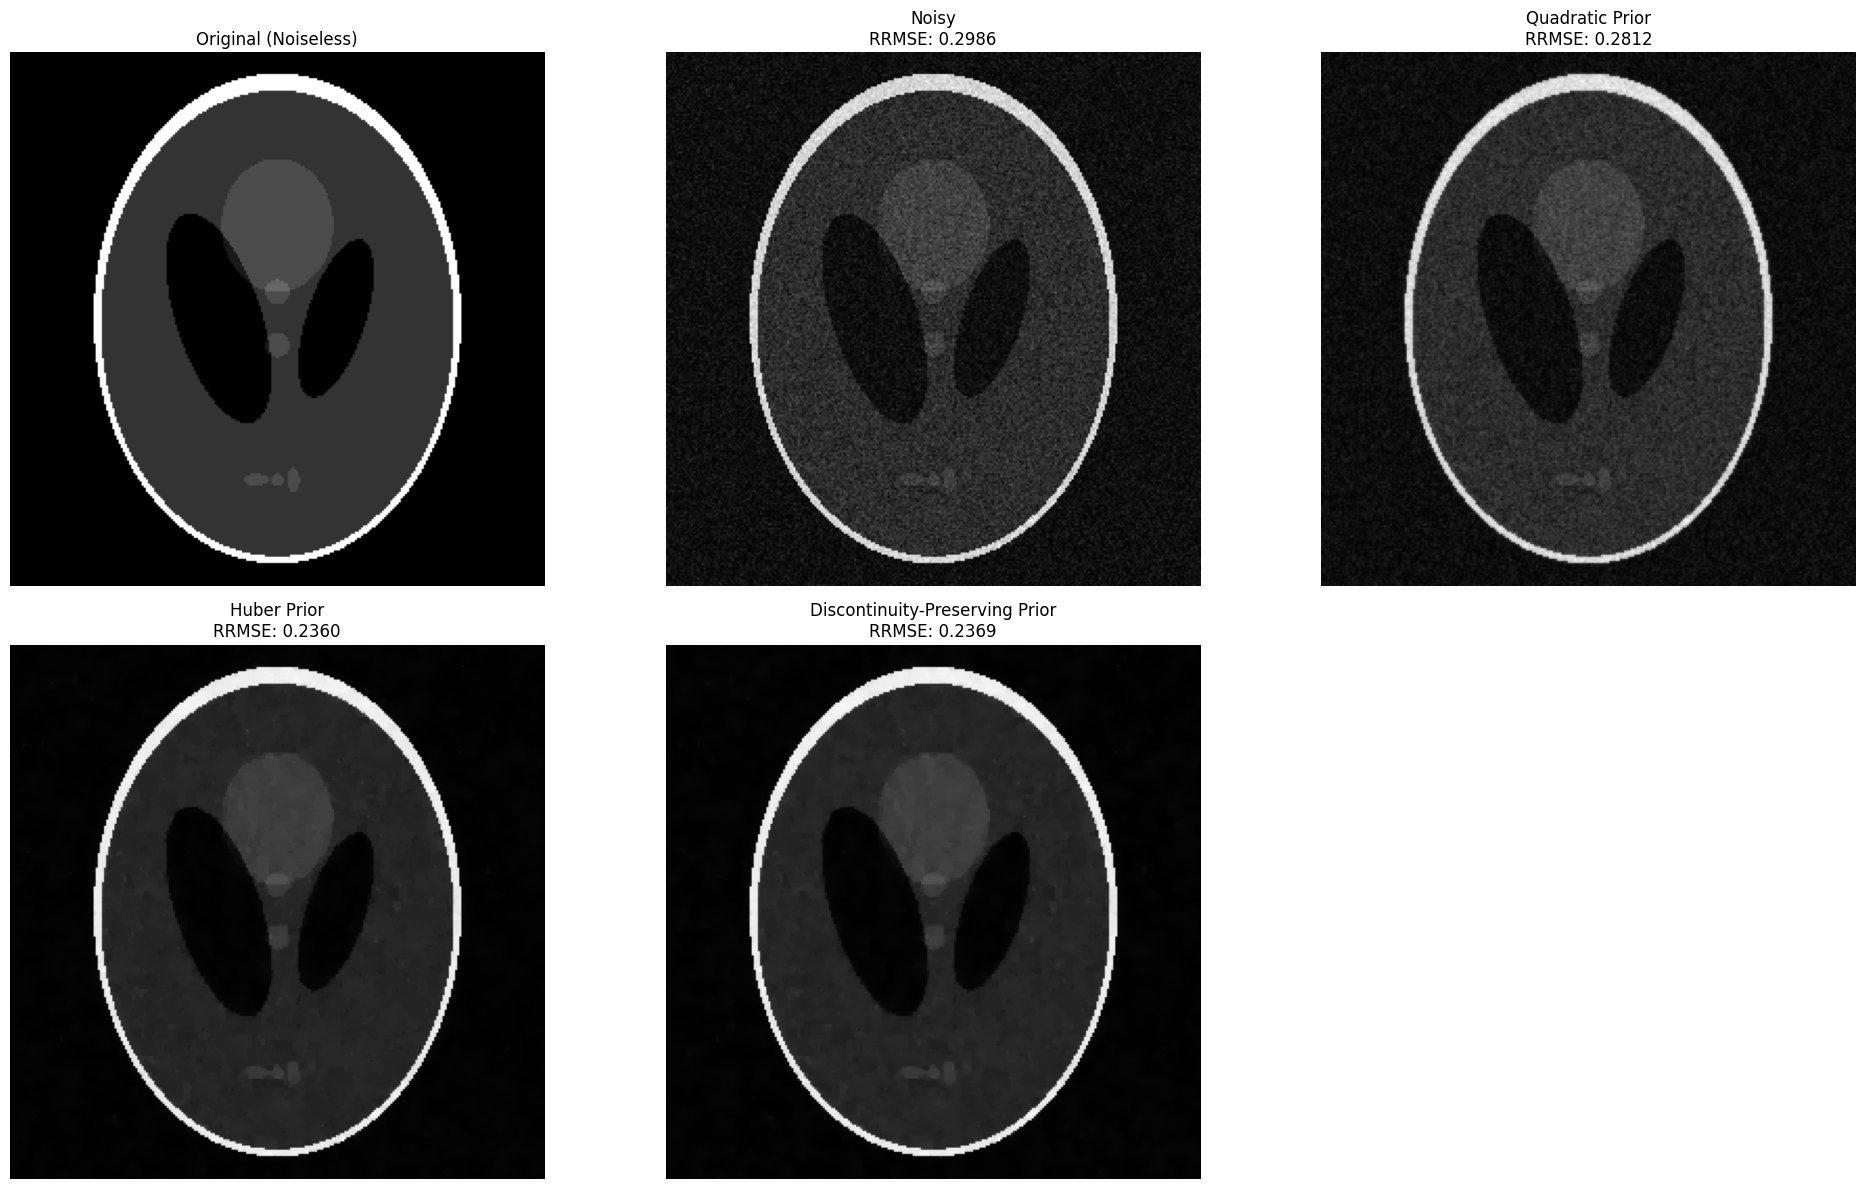

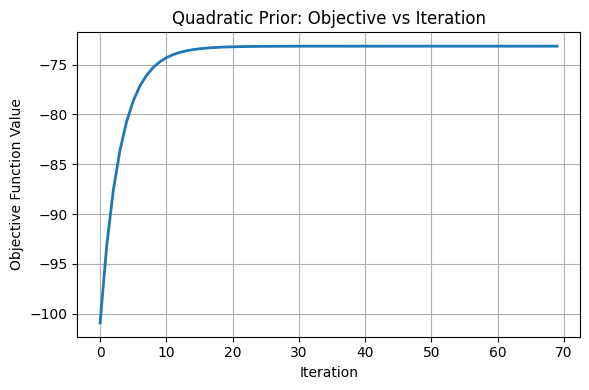

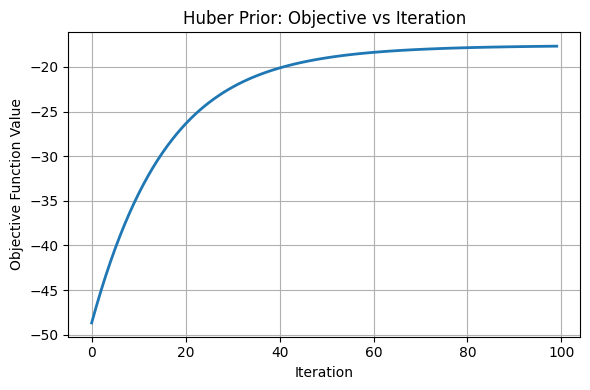

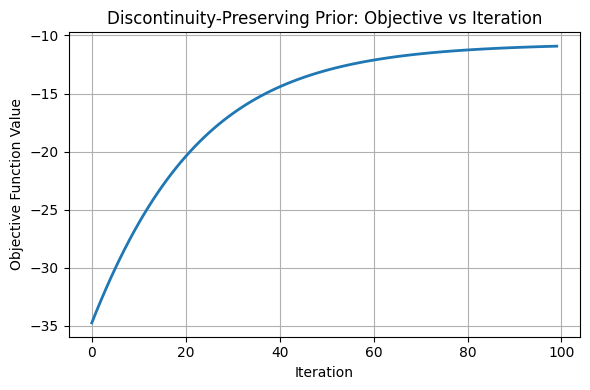


Detailed Parameter Summary:

QUADRATIC:
  α (alpha): 0.0278151493496485
  RRMSE: 0.281216
  MSE: 0.004796
  PSNR: 23.19 dB

HUBER:
  α (alpha): 0.8742201695929175
  γ (gamma): 0.0034769948587975077
  RRMSE: 0.236048
  MSE: 0.003379
  PSNR: 24.71 dB

DISCONTINUITY_PRESERVING:
  α (alpha): 0.942631377877297
  γ (gamma): 0.002521658104044622
  RRMSE: 0.236876
  MSE: 0.003403
  PSNR: 24.68 dB


In [64]:
final_results = {}

den_quad, obj_quad = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_quad,
    prior_type='quadratic',
    max_iterations=100,
    tolerance=1e-7
)
final_results['quadratic'] = {
    'denoised': den_quad,
    'rrmse': compute_rrmse(image_noiseless, den_quad),
    'alpha': best_alpha_quad,
    'gamma': None,
    'objective': obj_quad
}

den_huber, obj_huber = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_huber,
    prior_type='huber',
    gamma=best_gamma_huber,
    max_iterations=100,
    tolerance=1e-7
)
final_results['huber'] = {
    'denoised': den_huber,
    'rrmse': compute_rrmse(image_noiseless, den_huber),
    'alpha': best_alpha_huber,
    'gamma': best_gamma_huber,
    'objective': obj_huber
}

den_disc, obj_disc = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_disc,
    prior_type='discontinuity_preserving',
    gamma=best_gamma_disc,
    max_iterations=100,
    tolerance=1e-7
)
final_results['discontinuity_preserving'] = {
    'denoised': den_disc,
    'rrmse': compute_rrmse(image_noiseless, den_disc),
    'alpha': best_alpha_disc,
    'gamma': best_gamma_disc,
    'objective': obj_disc
}

plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
plt.imshow(image_noiseless, cmap='gray')
plt.title('Original (Noiseless)')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_noisy, cmap='gray')
plt.title(f'Noisy\nRRMSE: {compute_rrmse(image_noiseless, image_noisy):.4f}')
plt.axis('off')

methods = ['quadratic', 'huber', 'discontinuity_preserving']
titles = ['Quadratic Prior', 'Huber Prior', 'Discontinuity-Preserving Prior']

for i, (method, title) in enumerate(zip(methods, titles)):
    result = final_results[method]

    ax = plt.subplot(2, 3, 3 + i)
    ax.imshow(result['denoised'], cmap='gray')
    ax.set_title(f'{title}\nRRMSE: {result["rrmse"]:.4f}')
    ax.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['quadratic']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Quadratic Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['huber']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Huber Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['discontinuity_preserving']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Discontinuity-Preserving Prior: Objective vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()


print("\nDetailed Parameter Summary:")
print("=" * 60)

for method, result in final_results.items():
    print(f"\n{method.upper()}:")
    print(f"  α (alpha): {result['alpha']}")
    if result['gamma'] is not None:
        print(f"  γ (gamma): {result['gamma']}")
    print(f"  RRMSE: {result['rrmse']:.6f}")

    mse = np.mean((result['denoised'] - image_noiseless) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))

    print(f"  MSE: {mse:.6f}")
    print(f"  PSNR: {psnr:.2f} dB")
